# Loading packages

In [1]:
from __future__ import print_function, division 
import pandas as pd 
from pandas import Series, DataFrame 
from matplotlib import pyplot as plt
import numpy as np
from datetime import date
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

SavePlots = False

# Data

### Loading and splitting data

In [2]:
data = pd.read_csv('../Final-Project-AppML/feds200628.csv', skiprows=9)

remove non-essential rows, columns and Nan

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data1 = data[data['Date'] >= '1985-01-02']

col_to_keep = ['Date']
sveny_cols = [col for col in data.columns if col.startswith('SVENY')]
all_keep_cols = col_to_keep + sveny_cols
data2 = data1[all_keep_cols]
columns_to_drop = [f'SVENY{i}' for i in range(21, 31)]
data2 = data2.drop(columns=columns_to_drop, errors='ignore')

plot_data =data2
plot_data.rename(columns=lambda col: col[5:] if col.startswith('SVENY') else col, inplace=True)
plot_data.rename(columns=lambda col: str(int(col)) if col.isdigit() else col, inplace=True)

data = plot_data.dropna()
data['Date'] = pd.to_datetime(data['Date']).dt.date

train = data[data['Date'] >= date(1985, 1, 2)]
train = train[train['Date'] <= date(2017, 12, 31)] 

valid = data[data['Date'] >= date(2018, 1, 1)] 
valid = valid[valid['Date'] <= date(2024, 12, 31)] 

test = data[data['Date'] >= date(2025, 1, 1)] 

/var/folders/yn/lvxby3lj7nd2v75kj5sp86740000gn/T/ipykernel_89599/1234211664.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date']).dt.date


___

### Data overview

Histogram of yield 2 and 20

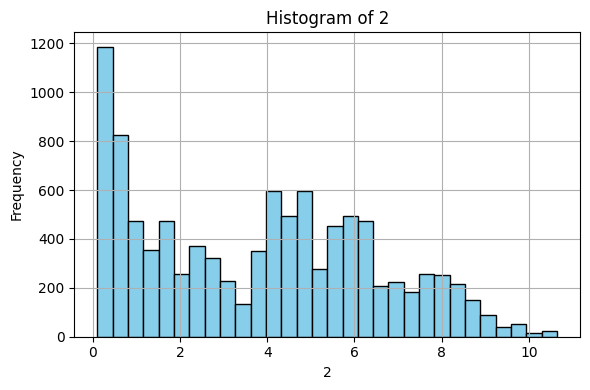

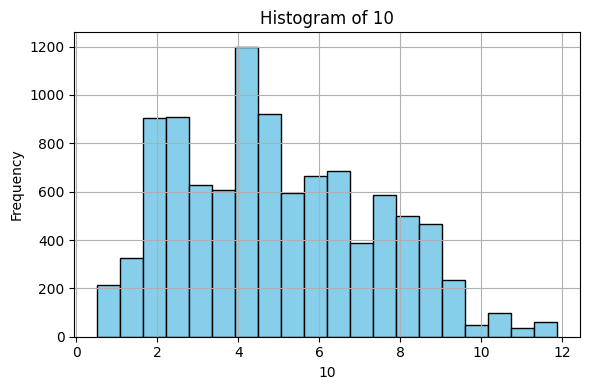

In [4]:
def plot_histogram(column_name, bins=30):
    if column_name not in plot_data.columns:
        print(f"Column '{column_name}' not found in data.")
        return

    plt.figure(figsize=(6, 4))
    plt.hist(plot_data[column_name].dropna(), bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_histogram('2')
plot_histogram('10', bins=20) 


3D plot of all type of yields

/var/folders/yn/lvxby3lj7nd2v75kj5sp86740000gn/T/ipykernel_89599/3572421373.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


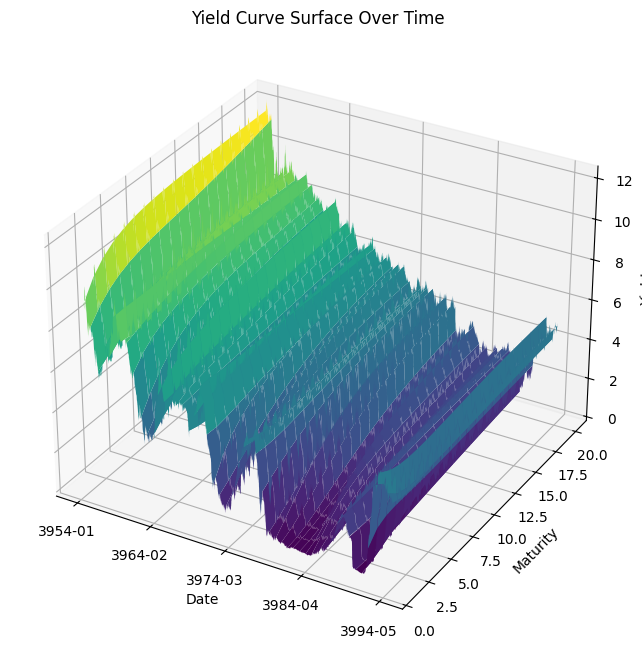

In [5]:
X = plot_data['Date'].map(pd.Timestamp.toordinal).values

maturity_cols = sorted([col for col in plot_data.columns if col.isdigit()], key=lambda x: int(x))
Y = np.array([int(m) for m in maturity_cols]) 

Z = plot_data[maturity_cols].values

X_mesh, Y_mesh = np.meshgrid(X, Y, indexing='ij')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_mesh, Y_mesh, Z, cmap='viridis')

ax.set_xlabel('Date')
ax.set_ylabel('Maturity')
ax.set_zlabel('Yield')
ax.set_title('Yield Curve Surface Over Time')

from matplotlib.dates import num2date
ax.set_xticks(np.linspace(X.min(), X.max(), 5))
ax.set_xticklabels([num2date(t).strftime('%Y-%m') for t in np.linspace(X.min(), X.max(), 5)])

plt.tight_layout()
plt.show()

Plot of all data of yield type 2 and 20

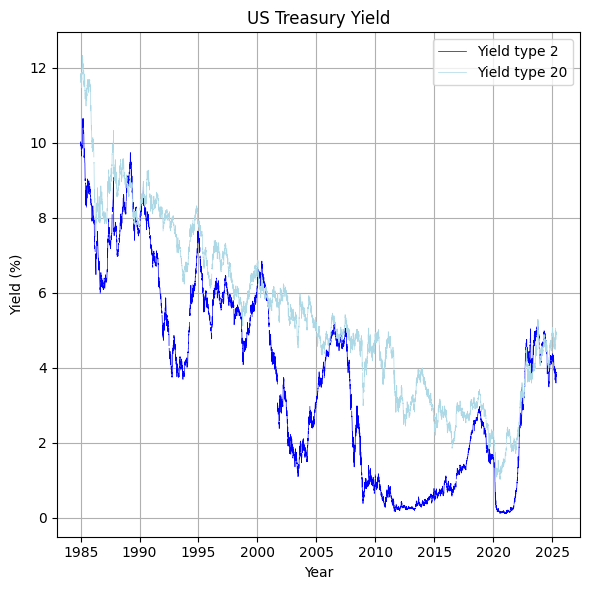

In [10]:
plt.figure(figsize=(6, 6))
plt.plot(plot_data['Date'], plot_data['2'], label='Yield type 2', color='blue', linewidth=0.5)
plt.plot(plot_data['Date'], plot_data['20'], label='Yield type 20', color='lightblue', linewidth=0.5)

plt.xlabel('Year')
plt.ylabel('Yield (%)')
plt.title('US Treasury Yield')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Date' is datetime
df['Date'] = pd.to_datetime(df['Date'])
print(df.columns.to_list)

In [ ]:
# Select features (exclude 'Date' and any non-numeric columns)
feature_cols = df.columns[(df.columns != 'Date') & (df.columns != 'Notes') ] #& (df.columns != 'Rate Change (bps)')

X = df[feature_cols]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Elbow method to find optimal k
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot inertia vs. number of clusters
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


#Chooses 4 or 6 cluster

In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
# Group by day and get dominant cluster for each date
df['DateOnly'] = df['Date'].dt.date
daily_clusters = df.groupby('DateOnly')['Cluster'].agg(lambda x: x.mode().iloc[0])


In [ ]:
# --------- Aggregate by Month and Get Dominant Cluster ---------
df['Month'] = df['Date'].dt.to_period('M')
monthly_clusters = df.groupby('Month')['Cluster'].agg(lambda x: x.mode().iloc[0])
monthly_clusters.index = monthly_clusters.index.to_timestamp()


# ---------  Plot ---------
plt.figure(figsize=(14, 4))
colors = sns.color_palette("hls", n_colors=n_clusters)
# Define a custom color list (as hex or RGB)
# colors = [
#     'coral', 
#     'cornflowerblue',
#     'royalblue',     
#     'lightblue',  
#     'salmon'
# ]


for i, (month, cluster) in enumerate(monthly_clusters.items()):
    plt.bar(i, 1, color=colors[cluster])  # No edgecolor

# Show only year ticks to reduce clutter
# years = [date.year for date in monthly_clusters.index]
# unique_years = sorted(set(years))
# year_ticks = [i for i, y in enumerate(years) if y in unique_years and (i == 0 or y != years[i - 1])]
# year_labels = [str(years[i]) for i in year_ticks]

#Show every fifth year
years = [date.year for date in monthly_clusters.index]
year_ticks = [i for i, y in enumerate(years) if y % 5 == 0 and (i == 0 or y != years[i - 1])]
year_labels = [str(years[i]) for i in year_ticks]


plt.xticks(ticks=year_ticks, labels=year_labels, rotation=0)
plt.xlabel('Year')
plt.ylabel('Dominant Cluster')
plt.title('Stove Data Clustering Over Time (Dominant Cluster per Month)')
plt.tight_layout()
plt.show()


### Comparing to theory

In [ ]:
# faster
# periods = [
#     ("1991-01-01", "2001-12-31", "IT boom, 90's"),
#     ("2002-01-01", "2007-12-31", "Housing bubble 00's"),
#     ("2008-01-01", "2009-12-31", "Financial crisis 2008"),
#     ("2010-01-01", "2020-02-29", "Long expansion 10's"),
#     ("2020-03-01", "2022-12-31", "COVID recovery"),
#     ("2023-01-01", "2025-06-01", "Recent slowdown after 2023"),
# ]
periods = [
    ("1991-01-01", "2001-12-31", 0),
    ("2002-01-01", "2007-12-31", 1),
    ("2008-01-01", "2009-12-31", 2),
    ("2010-01-01", "2020-02-29", 3),
    ("2020-03-01", "2022-12-31", 4),
    ("2023-01-01", "2025-06-01", 5),
]

# Create date boundaries and labels
boundaries = pd.to_datetime([
    "1991-01-01", "2002-01-01", "2008-01-01", "2010-01-01",
    "2020-03-01", "2023-01-01", "2025-06-02"
])

# labels = [
#     "IT boom", "Housing bubble", "Financial crisis",
#     "Long expansion", "COVID recovery", "Recent slowdown"
# ]
labels = [
    0,1,2,3,4,5
]

# Assign periods using cut
df_period = pd.DataFrame({'Date': pd.date_range("1991-01-01", "2025-06-01", freq='D')})
df_period['Period'] = pd.cut(df_period['Date'], bins=boundaries, labels=labels, right=False)


In [ ]:
df_confusion = df.merge(df_period, on='Date', how='left')

# Save result
df_confusion.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Extract true and predicted labels
y_true = df_confusion['Period'].astype(str)
y_pred = df_confusion['Cluster'].astype(str)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Custom label list (optional)
labels = sorted(df_confusion['Period'].unique())
labels_periods = [
    "IT boom", "Housing bubble", "Financial crisis",
    "Long expansion", "COVID recovery", "Recent slowdown"
]

# Plot with custom color map (e.g. Reds, Greens, Purples, etc.)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels_periods)

# Add labels
plt.xlabel('Predicted Cluster')
plt.ylabel('Actual Period')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels_periods)

# sns.heatmap(cm_normalized, annot=True, fmt='d', cmap='Blues',
#              xticklabels=labels, yticklabels=labels_periods,
#              linewidths=0.5, linecolor='gray')

### Finding: Bust graphs

In [ ]:
bust_df = df[df['Cluster'] == 1]
bust_df = bust_df.drop(columns=['DateOnly', 'Month', 'Cluster'])

In [ ]:
import matplotlib.pyplot as plt

# Column names
target_col = 'FEDFUNDS'
measurement_col = 'Close'

# Ensure datetime format and sort
bust_df['Date'] = pd.to_datetime(bust_df['Date'])
bust_df = bust_df.sort_values('Date').reset_index(drop=True)

# Create plot
fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

# Use index positions for x-axis (not continuous dates)
x = range(len(bust_df))

# Plot solid lines
color1 = 'goldenrod'
color2 = 'royalblue'

ax1.plot(x, bust_df[target_col], color=color1, linewidth=2.5, label=target_col)
ax2.plot(x, bust_df[measurement_col], color=color2, linewidth=2.5, label=measurement_col)

# Label axes
ax1.set_ylabel('FED Interest Rate ', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax2.set_ylabel('S&P Closing Price', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax1.set_xlabel('Date')

# Format x-ticks with actual dates
step = max(len(bust_df) // 10, 1)  # Show ~10 date labels
tick_locs = list(range(0, len(bust_df), step))
tick_labels = bust_df['Date'].dt.strftime('%Y-%m-%d').iloc[tick_locs]

ax1.set_xticks(tick_locs)
ax1.set_xticklabels(tick_labels, rotation=45)

# Final plot
plt.title(f'FED interest rate and stock prices in a cluster')
plt.tight_layout()
plt.show()

# Predicting yields

## Data

In [ ]:
from __future__ import print_function, division
import pandas as pd 
from pandas import Series, DataFrame 
from matplotlib import pyplot as plt
import numpy as np

SavePlots = False

import pandas as pd

data = pd.read_csv('../Final-Project-AppML/feds200628.csv', skiprows=9)

data.head(5)


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

data1 = data[data['Date'] >= '1985-01-02']

data1.head()


cols_to_keep = ['Date', 'BETA0', 'BETA1', 'BETA2']

sveny_cols = [col for col in data.columns if col.startswith('SVENY')]

all_keep_cols = cols_to_keep + sveny_cols

data2 = data1[all_keep_cols]

data2.head()

columns_to_drop = [f'SVENY{i}' for i in range(21, 31)]
data2 = data2.drop(columns=columns_to_drop, errors='ignore')

plot_data = data2

plot_data.rename(columns=lambda col: col[5:] if col.startswith('SVENY') else col, inplace=True)

plot_data.rename(columns=lambda col: str(int(col)) if col.isdigit() else col, inplace=True)

print(plot_data.columns)

In [ ]:
import pandas as pd

df = plot_data.dropna()

df = df.drop(columns=['BETA0', 'BETA1', 'BETA2'], errors='ignore')

df['Date'] = pd.to_datetime(df['Date'])

df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month

train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')

train_df = df[df['Date'] < train_end]
val_df = df[(df['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = df[df['Date'] >= val_end]

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

### Plotting

## Baseline/naive model

### Predicting tomorrow

In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd

val_df = val_df.copy()
val_df['naive_pred'] = val_df['2'].shift(1)
val_df = val_df.dropna(subset=['naive_pred'])

val_mse = mean_squared_error(val_df['2'], val_df['naive_pred'])
print(f"Naiv model MSE (validation): {val_mse:.4f}")

test_df = test_df.copy()
test_df['naive_pred'] = test_df['2'].shift(1)
test_df = test_df.dropna(subset=['naive_pred'])

test_mse = mean_squared_error(test_df['2'], test_df['naive_pred'])
print(f"Naiv model MSE (test): {test_mse:.4f}")


val_df = val_df.copy()
val_df['naive_pred'] = val_df['20'].shift(1)
val_df = val_df.dropna(subset=['naive_pred'])

val_mse = mean_squared_error(val_df['20'], val_df['naive_pred'])
print(f"Naiv model MSE (validation): {val_mse:.4f}")

test_df = test_df.copy()
test_df['naive_pred'] = test_df['20'].shift(1)
test_df = test_df.dropna(subset=['naive_pred'])

test_mse = mean_squared_error(test_df['20'], test_df['naive_pred'])
print(f"Naiv model MSE (test): {test_mse:.4f}")


Naiv model MSE (validation): 0.0032
Naiv model MSE (test): 0.0036
Naiv model MSE (validation): 0.0031
Naiv model MSE (test): 0.0037


### Predicting 10 days ahead

In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd


val_df_2 = val_df.copy()
val_df_2['naive_pred'] = val_df_2['2']
val_df_2['target'] = val_df_2['2'].shift(-10) 
val_df_2 = val_df_2.dropna(subset=['target'])

val_mse_2 = mean_squared_error(val_df_2['target'], val_df_2['naive_pred'])
print(f"Naiv model MSE (validation, col 2, 10-dages): {val_mse_2:.4f}")

test_df_2 = test_df.copy()
test_df_2['naive_pred'] = test_df_2['2']
test_df_2['target'] = test_df_2['2'].shift(-10)
test_df_2 = test_df_2.dropna(subset=['target'])

test_mse_2 = mean_squared_error(test_df_2['target'], test_df_2['naive_pred'])
print(f"Naiv model MSE (test, col 2, 10-dages): {test_mse_2:.4f}")



val_df_20 = val_df.copy()
val_df_20['naive_pred'] = val_df_20['20']
val_df_20['target'] = val_df_20['20'].shift(-10)
val_df_20 = val_df_20.dropna(subset=['target'])

val_mse_20 = mean_squared_error(val_df_20['target'], val_df_20['naive_pred'])
print(f"Naiv model MSE (validation, col 20, 10-dages): {val_mse_20:.4f}")

test_df_20 = test_df.copy()
test_df_20['naive_pred'] = test_df_20['20']
test_df_20['target'] = test_df_20['20'].shift(-10)
test_df_20 = test_df_20.dropna(subset=['target'])

test_mse_20 = mean_squared_error(test_df_20['target'], test_df_20['naive_pred'])
print(f"Naiv model MSE (test, col 20, 10-dages): {test_mse_20:.4f}")


Naiv model MSE (validation, col 2, 10-dages): 0.0328
Naiv model MSE (test, col 2, 10-dages): 0.0220
Naiv model MSE (validation, col 20, 10-dages): 0.0277
Naiv model MSE (test, col 20, 10-dages): 0.0264


## XGBoost - 1 day ahead

### Yield type 2

#### First model

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

target_col = "2"  
n_lags = 500
forecast_horizon = 1

def create_lag_features(df, col, n_lags=n_lags, forecast_horizon=forecast_horizon):
    df = df.sort_values("Date").copy()

    target = df[[col]].shift(-forecast_horizon).rename(columns={col: f"{col}_target"})

    lagged_features = [
        df[[col]].shift(lag - forecast_horizon).rename(columns={col: f"{col}_lag_{lag}"})
        for lag in range(1, n_lags + 1)
    ]

    calendar_features = pd.DataFrame({
        'day_of_week': df['Date'].dt.dayofweek,
        'day_of_month': df['Date'].dt.day,
        'month': df['Date'].dt.month
    }, index=df.index)

    df_lagged = pd.concat([df[['Date']], target] + lagged_features + [calendar_features], axis=1)

    return df_lagged.dropna()



df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "eta": 0.05,
    "verbosity": 0
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=20,
    verbose_eval=True
)

y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

naive_pred_val = df_lagged.loc[val_mask, "2_lag_1"]

val_dates = df_lagged.loc[val_mask, 'Date']
val_2024_mask = val_dates.dt.year == 2024

dates_2024 = val_dates[val_2024_mask]
y_val_2024 = y_val[val_2024_mask]
y_pred_val_2024 = y_pred_val[val_2024_mask]
naive_pred_val_2024 = naive_pred_val[val_2024_mask]

mse_xgb = mean_squared_error(y_val_2024, y_pred_val_2024)
mse_naive = mean_squared_error(y_val_2024, naive_pred_val_2024)



[0]	train-rmse:2.49291	eval-rmse:2.06703
[1]	train-rmse:2.36918	eval-rmse:1.96659
[2]	train-rmse:2.25155	eval-rmse:1.87166
[3]	train-rmse:2.13984	eval-rmse:1.78059
[4]	train-rmse:2.03364	eval-rmse:1.69461
[5]	train-rmse:1.93275	eval-rmse:1.61305
[6]	train-rmse:1.83688	eval-rmse:1.53457
[7]	train-rmse:1.74574	eval-rmse:1.46047
[8]	train-rmse:1.65914	eval-rmse:1.39041
[9]	train-rmse:1.57685	eval-rmse:1.32413
[10]	train-rmse:1.49866	eval-rmse:1.26081
[11]	train-rmse:1.42438	eval-rmse:1.20032
[12]	train-rmse:1.35377	eval-rmse:1.14349
[13]	train-rmse:1.28670	eval-rmse:1.08964
[14]	train-rmse:1.22296	eval-rmse:1.03788
[15]	train-rmse:1.16239	eval-rmse:0.98929
[16]	train-rmse:1.10486	eval-rmse:0.94237
[17]	train-rmse:1.05017	eval-rmse:0.89859
[18]	train-rmse:0.99822	eval-rmse:0.85676
[19]	train-rmse:0.94879	eval-rmse:0.81580
[20]	train-rmse:0.90189	eval-rmse:0.77783
[21]	train-rmse:0.85728	eval-rmse:0.74108
[22]	train-rmse:0.81490	eval-rmse:0.70585
[23]	train-rmse:0.77464	eval-rmse:0.67265
[2

In [ ]:
print(X_test.head())

       2_lag_1  2_lag_2  2_lag_3  2_lag_4  2_lag_5  2_lag_6  2_lag_7  2_lag_8  \
16581   4.2189   4.2273   4.2244   4.2905   4.2923   4.3071   4.3062   4.2666   
16582   4.2462   4.2189   4.2273   4.2244   4.2905   4.2923   4.3071   4.3062   
16583   4.2453   4.2462   4.2189   4.2273   4.2244   4.2905   4.2923   4.3071   
16584   4.2657   4.2453   4.2462   4.2189   4.2273   4.2244   4.2905   4.2923   
16585   4.2549   4.2657   4.2453   4.2462   4.2189   4.2273   4.2244   4.2905   

       2_lag_9  2_lag_10  ...  2_lag_491  2_lag_492  2_lag_493  2_lag_494  \
16581   4.2864    4.2954  ...     4.0428     4.1519     4.1953     4.1191   
16582   4.2666    4.2864  ...     4.0848     4.0428     4.1519     4.1953   
16583   4.3062    4.2666  ...     4.1360     4.0848     4.0428     4.1519   
16584   4.3071    4.3062  ...     4.1875     4.1360     4.0848     4.0428   
16585   4.2923    4.3071  ...     4.1669     4.1875     4.1360     4.0848   

       2_lag_495  2_lag_496  2_lag_497  2_lag_498 

#### Bayesian optimization

In [ ]:
from skopt import  gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

search_space = [
    Integer(1, 200, name='n_lags'),
    Integer(2, 15, name='max_depth'),
    Real(0.001, 0.3, name='eta')
]

tscv = TimeSeriesSplit(n_splits=3)

N_REPEATS = 3

@use_named_args(search_space)
def objective(n_lags, max_depth, eta):
    df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

    target = f"{target_col}_target"
    features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

    X = df_lagged[features]
    y = df_lagged[target]

    mse_repeats = []

    for repeat in range(N_REPEATS):
        mse_scores = []

        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)

            params = {
                "objective": "reg:squarederror",
                "max_depth": max_depth,
                "eta": eta,
                "verbosity": 0,
                "seed": 42 + repeat 
            }

            bst = xgb.train(
                params,
                dtrain,
                evals=[(dval, 'eval')],
                num_boost_round=1000,
                early_stopping_rounds=20,
                verbose_eval=False
            )

            y_pred_val = bst.predict(dval)
            mse = mean_squared_error(y_val, y_pred_val)
            mse_scores.append(mse)

        mse_repeats.append(np.mean(mse_scores))


    return np.mean(mse_repeats)


result = gp_minimize(
    objective,
    search_space,
    n_calls=100,
    #n_random_starts=10,
    random_state=42,
    verbose=True
)

print("\nBest MSE:", result.fun)
print("Best parameters:")
for name, val in zip([dim.name for dim in search_space], result.x):
    print(f"  {name}: {val}")


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.7165
Function value obtained: 0.4614
Current minimum: 0.4614
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 18.2775
Function value obtained: 0.5204
Current minimum: 0.4614
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.4078
Function value obtained: 0.5059
Current minimum: 0.4614
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.5861
Function value obtained: 0.4616
Current minimum: 0.4614
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.7742
Function value obtained: 0.4911
Current minimum: 0.4614
Iteration No: 6 started. Evaluatin

In [ ]:
n_lags = 30
params = {
    "objective": "reg:squarederror",
    "max_depth": 2,
    "eta": 0.2,
    "subsample": 1,
    "colsample_bytree": 1,
    "verbosity": 0
}



<Axes: >

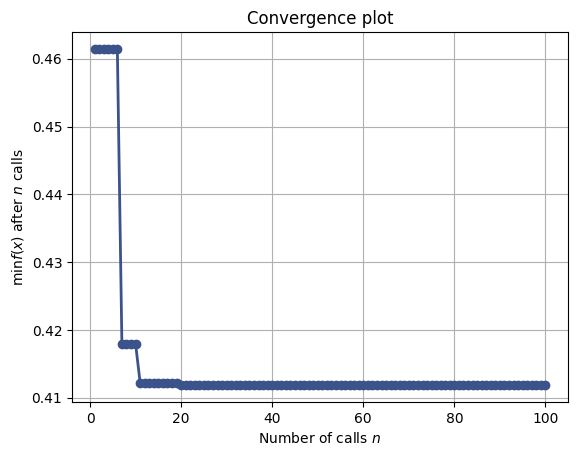

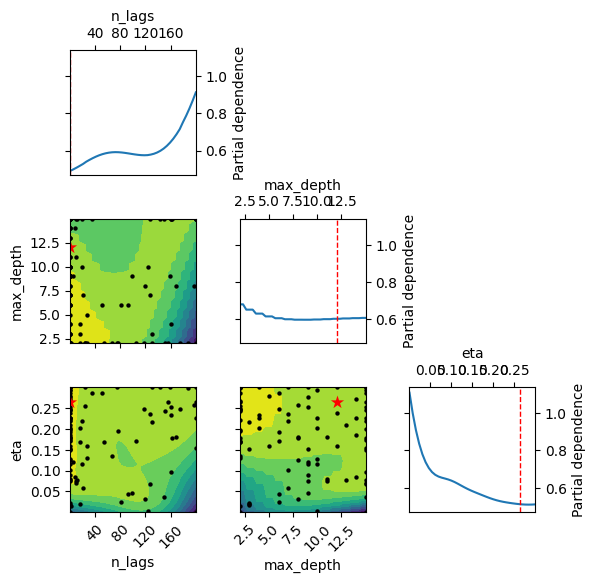

In [ ]:
from skopt.plots import plot_objective, plot_convergence
plot_convergence(result)
plot_objective(result)


#### Fitting on full training data

In [ ]:
df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

train_val_mask = train_mask | val_mask

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train_val = df_lagged.loc[train_val_mask, features]
y_train_val = df_lagged.loc[train_val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtest = xgb.DMatrix(X_test, label=y_test)

dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)


bst_final = xgb.train(
    params,
    dtrain_val,
    num_boost_round=1000,
    evals=[(dtrain_val, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)



#### Plotting

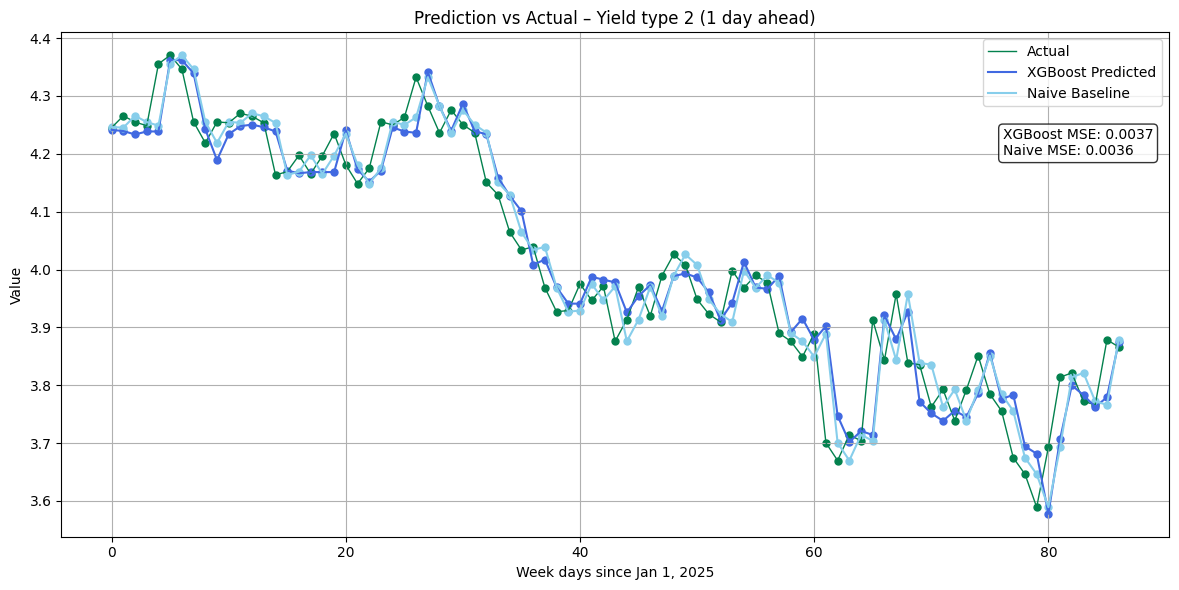

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

naive_pred_series = y_test.shift(forecast_horizon).dropna()
common_index = y_test.index.intersection(naive_pred_series.index)

naive_pred = naive_pred_series.loc[common_index]
y_test_aligned = y_test.loc[common_index]

y_pred_full = pd.Series(bst_final.predict(dtest), index=y_test.index)
y_pred_aligned = y_pred_full.loc[common_index]

actual_2 = y_test_aligned.copy()
xgb_pred_2 = y_pred_aligned.copy()
naive_pred_2 = naive_pred.copy()

x = np.arange(len(y_test_aligned))

mse_xgb = mean_squared_error(y_test_aligned, y_pred_aligned)
mse_naive = mean_squared_error(y_test_aligned, naive_pred)

plt.figure(figsize=(12, 6))

plt.plot(x, actual_2, label='Actual', color="#03814E", linewidth=1)
plt.scatter(x, actual_2, color='#03814E', s=25)

plt.plot(x, xgb_pred_2, label='XGBoost Predicted', color='royalblue')
plt.scatter(x, xgb_pred_2, color='royalblue', s=25)

plt.plot(x, naive_pred_2, label='Naive Baseline', color='skyblue')
plt.scatter(x, naive_pred_2, color='skyblue', s=25)

plt.title(f'Prediction vs Actual – Yield type {target_col} ({forecast_horizon} day ahead)')
plt.xlabel('Week days since Jan 1, 2025')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

textstr = '\n'.join((
    f'XGBoost MSE: {mse_xgb:.4f}',
    f'Naive MSE: {mse_naive:.4f}',
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.85, 0.75, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.utils import resample

def bootstrap_mse(y_true, y_pred, n_bootstrap=1000, ci=95):
    mses = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        indices = resample(np.arange(n), replace=True, n_samples=n)
        mses.append(mean_squared_error(y_true[indices], y_pred[indices]))
    lower = np.percentile(mses, (100 - ci) / 2)
    upper = np.percentile(mses, 100 - (100 - ci) / 2)
    return np.mean(mses), lower, upper

mean_xgb, lower_xgb, upper_xgb = bootstrap_mse(y_test_aligned.values, y_pred_aligned.values)
mean_naive, lower_naive, upper_naive = bootstrap_mse(y_test_aligned.values, naive_pred.values)

print(f"XGBoost MSE: {mean_xgb:.4f} (95% CI: {lower_xgb:.4f} - {upper_xgb:.4f})")
print(f"Naive MSE: {mean_naive:.4f} (95% CI: {lower_naive:.4f} - {upper_naive:.4f})")


XGBoost MSE: 0.0037 (95% CI: 0.0024 - 0.0051)
Naive MSE: 0.0036 (95% CI: 0.0025 - 0.0051)


### Yield type 20

#### First model

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

target_col = "20"  
n_lags = 500
forecast_horizon = 1

def create_lag_features(df, col, n_lags=n_lags, forecast_horizon=forecast_horizon):
    df = df.sort_values("Date").copy()

    target = df[[col]].shift(-forecast_horizon).rename(columns={col: f"{col}_target"})

    lagged_features = [
        df[[col]].shift(lag - forecast_horizon).rename(columns={col: f"{col}_lag_{lag}"})
        for lag in range(1, n_lags + 1)
    ]

    calendar_features = pd.DataFrame({
        'day_of_week': df['Date'].dt.dayofweek,
        'day_of_month': df['Date'].dt.day
    }, index=df.index)

    df_lagged = pd.concat([df[['Date']], target] + lagged_features + [calendar_features], axis=1)

    return df_lagged.dropna()



df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "eta": 0.05,
    "verbosity": 0
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=20,
    verbose_eval=True
)

y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

naive_pred_val = df_lagged.loc[val_mask, "20_lag_1"]

val_dates = df_lagged.loc[val_mask, 'Date']
val_2024_mask = val_dates.dt.year == 2024

dates_2024 = val_dates[val_2024_mask]
y_val_2024 = y_val[val_2024_mask]
y_pred_val_2024 = y_pred_val[val_2024_mask]
naive_pred_val_2024 = naive_pred_val[val_2024_mask]

mse_xgb = mean_squared_error(y_val_2024, y_pred_val_2024)
mse_naive = mean_squared_error(y_val_2024, naive_pred_val_2024)



[0]	train-rmse:1.86193	eval-rmse:2.78508
[1]	train-rmse:1.76963	eval-rmse:2.65936
[2]	train-rmse:1.68195	eval-rmse:2.54224
[3]	train-rmse:1.59861	eval-rmse:2.42920
[4]	train-rmse:1.51943	eval-rmse:2.32141
[5]	train-rmse:1.44414	eval-rmse:2.22278
[6]	train-rmse:1.37264	eval-rmse:2.12978
[7]	train-rmse:1.30468	eval-rmse:2.03715
[8]	train-rmse:1.24014	eval-rmse:1.95248
[9]	train-rmse:1.17878	eval-rmse:1.87008
[10]	train-rmse:1.12047	eval-rmse:1.78888
[11]	train-rmse:1.06506	eval-rmse:1.71731
[12]	train-rmse:1.01244	eval-rmse:1.64431
[13]	train-rmse:0.96242	eval-rmse:1.57369
[14]	train-rmse:0.91488	eval-rmse:1.50875
[15]	train-rmse:0.86971	eval-rmse:1.44673
[16]	train-rmse:0.82681	eval-rmse:1.38488
[17]	train-rmse:0.78603	eval-rmse:1.32648
[18]	train-rmse:0.74729	eval-rmse:1.27651
[19]	train-rmse:0.71048	eval-rmse:1.22369
[20]	train-rmse:0.67550	eval-rmse:1.17497
[21]	train-rmse:0.64228	eval-rmse:1.12728
[22]	train-rmse:0.61070	eval-rmse:1.08387
[23]	train-rmse:0.58071	eval-rmse:1.04036
[2

#### Bayesian optimization

In [ ]:
# from skopt import  gp_minimize
# from skopt.space import Integer, Real
# from skopt.utils import use_named_args

# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_squared_error
# import numpy as np

# search_space = [
#     Integer(1, 200, name='n_lags'),
#     Integer(2, 15, name='max_depth'),
#     Real(0.001, 0.3, name='eta')
# ]

# tscv = TimeSeriesSplit(n_splits=3)

# N_REPEATS = 3

# @use_named_args(search_space)
# def objective(n_lags, max_depth, eta):
#     df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

#     target = f"{target_col}_target"
#     features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

#     X = df_lagged[features]
#     y = df_lagged[target]

#     mse_repeats = []

#     for repeat in range(N_REPEATS):
#         mse_scores = []

#         for train_idx, val_idx in tscv.split(X):
#             X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#             y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#             dtrain = xgb.DMatrix(X_train, label=y_train)
#             dval = xgb.DMatrix(X_val, label=y_val)

#             params = {
#                 "objective": "reg:squarederror",
#                 "max_depth": max_depth,
#                 "eta": eta,
#                 "verbosity": 0,
#                 "seed": 42 + repeat 
#             }

#             bst = xgb.train(
#                 params,
#                 dtrain,
#                 evals=[(dval, 'eval')],
#                 num_boost_round=1000,
#                 early_stopping_rounds=20,
#                 verbose_eval=False
#             )

#             y_pred_val = bst.predict(dval)
#             mse = mean_squared_error(y_val, y_pred_val)
#             mse_scores.append(mse)

#         mse_repeats.append(np.mean(mse_scores))


#     return np.mean(mse_repeats)


# result = gp_minimize(
#     objective,
#     search_space,
#     n_calls=100,
#     #n_random_starts=10,
#     random_state=42,
#     verbose=True
# )

# print("\nBest MSE:", result.fun)
# print("Best parameters:")
# for name, val in zip([dim.name for dim in search_space], result.x):
#     print(f"  {name}: {val}")


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.5179
Function value obtained: 0.4748
Current minimum: 0.4748
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 22.1645
Function value obtained: 0.5026
Current minimum: 0.4748
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.6817
Function value obtained: 0.5678
Current minimum: 0.4748
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.9123
Function value obtained: 0.4885
Current minimum: 0.4748
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.4348
Function value obtained: 0.4788
Current minimum: 0.4748
Iteration No: 6 started. Evaluatin

In [ ]:
n_lags = 103
params = {
    "objective": "reg:squarederror",
    "max_depth": 3,
    "eta": 0.05,
    "subsample": 1,
    "colsample_bytree": 1,
    "verbosity": 0
}



<Axes: >

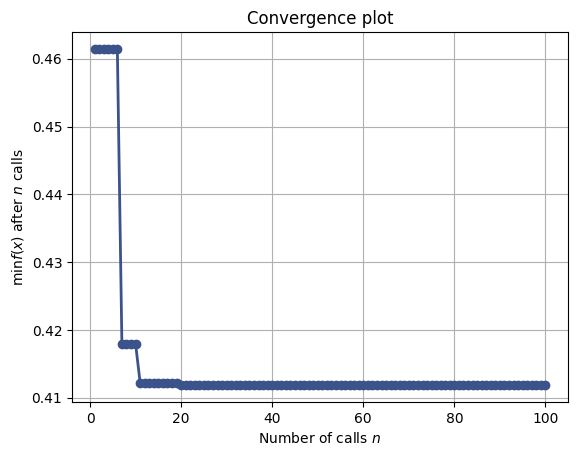

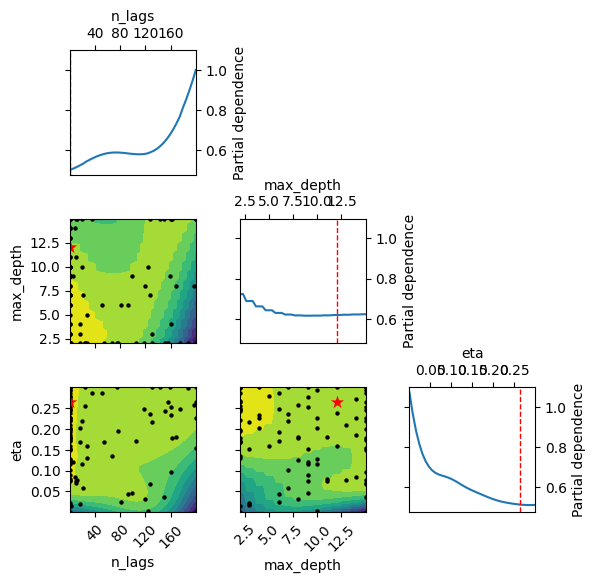

In [ ]:
from skopt.plots import plot_objective, plot_convergence
plot_convergence(result)
plot_objective(result)


#### Fitting on full training data

In [ ]:
df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

train_val_mask = train_mask | val_mask

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train_val = df_lagged.loc[train_val_mask, features]
y_train_val = df_lagged.loc[train_val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtest = xgb.DMatrix(X_test, label=y_test)

dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)


bst_final = xgb.train(
    params,
    dtrain_val,
    num_boost_round=1000,
    evals=[(dtrain_val, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)



#### Plotting

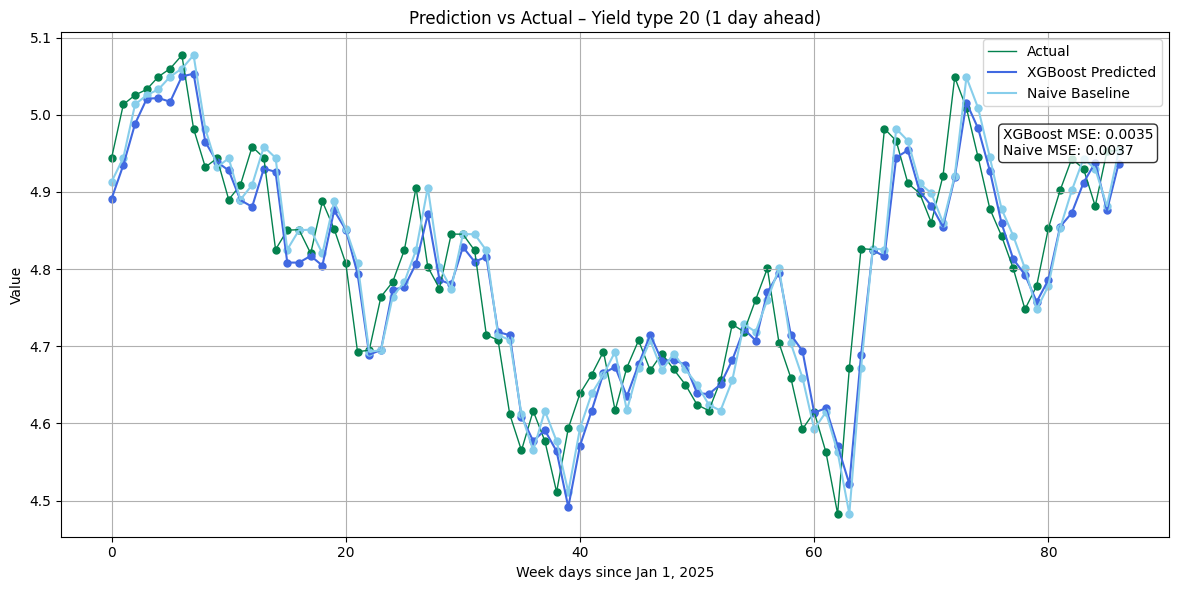

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

naive_pred_series = y_test.shift(forecast_horizon).dropna()
common_index = y_test.index.intersection(naive_pred_series.index)

naive_pred = naive_pred_series.loc[common_index]
y_test_aligned = y_test.loc[common_index]

y_pred_full = pd.Series(bst_final.predict(dtest), index=y_test.index)
y_pred_aligned = y_pred_full.loc[common_index]

actual_20 = y_test_aligned.copy()
xgb_pred_20 = y_pred_aligned.copy()
naive_pred_20 = naive_pred.copy()

x = np.arange(len(y_test_aligned))

mse_xgb = mean_squared_error(y_test_aligned, y_pred_aligned)
mse_naive = mean_squared_error(y_test_aligned, naive_pred)

plt.figure(figsize=(12, 6))

plt.plot(x, y_test_aligned, label='Actual', color='#03814E', linewidth=1)
plt.scatter(x, y_test_aligned, color='#03814E', s=25)

plt.plot(x, y_pred_aligned, label='XGBoost Predicted', color='royalblue')
plt.scatter(x, y_pred_aligned, color='royalblue', s=25)

plt.plot(x, naive_pred, label='Naive Baseline', color='skyblue')
plt.scatter(x, naive_pred, color='skyblue', s=25)

plt.title(f'Prediction vs Actual – Yield type {target_col} ({forecast_horizon} day ahead)')
plt.xlabel('Week days since Jan 1, 2025')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

textstr = '\n'.join((
    f'XGBoost MSE: {mse_xgb:.4f}',
    f'Naive MSE: {mse_naive:.4f}',
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.85, 0.75, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.utils import resample

def bootstrap_mse(y_true, y_pred, n_bootstrap=1000, ci=95):
    mses = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        indices = resample(np.arange(n), replace=True, n_samples=n)
        mses.append(mean_squared_error(y_true[indices], y_pred[indices]))
    lower = np.percentile(mses, (100 - ci) / 2)
    upper = np.percentile(mses, 100 - (100 - ci) / 2)
    return np.mean(mses), lower, upper

mean_xgb, lower_xgb, upper_xgb = bootstrap_mse(y_test_aligned.values, y_pred_aligned.values)
mean_naive, lower_naive, upper_naive = bootstrap_mse(y_test_aligned.values, naive_pred.values)

print(f"XGBoost MSE: {mean_xgb:.4f} (95% CI: {lower_xgb:.4f} - {upper_xgb:.4f})")
print(f"Naive MSE: {mean_naive:.4f} (95% CI: {lower_naive:.4f} - {upper_naive:.4f})")


XGBoost MSE: 0.0035 (95% CI: 0.0025 - 0.0046)
Naive MSE: 0.0038 (95% CI: 0.0027 - 0.0051)


### Combined plot

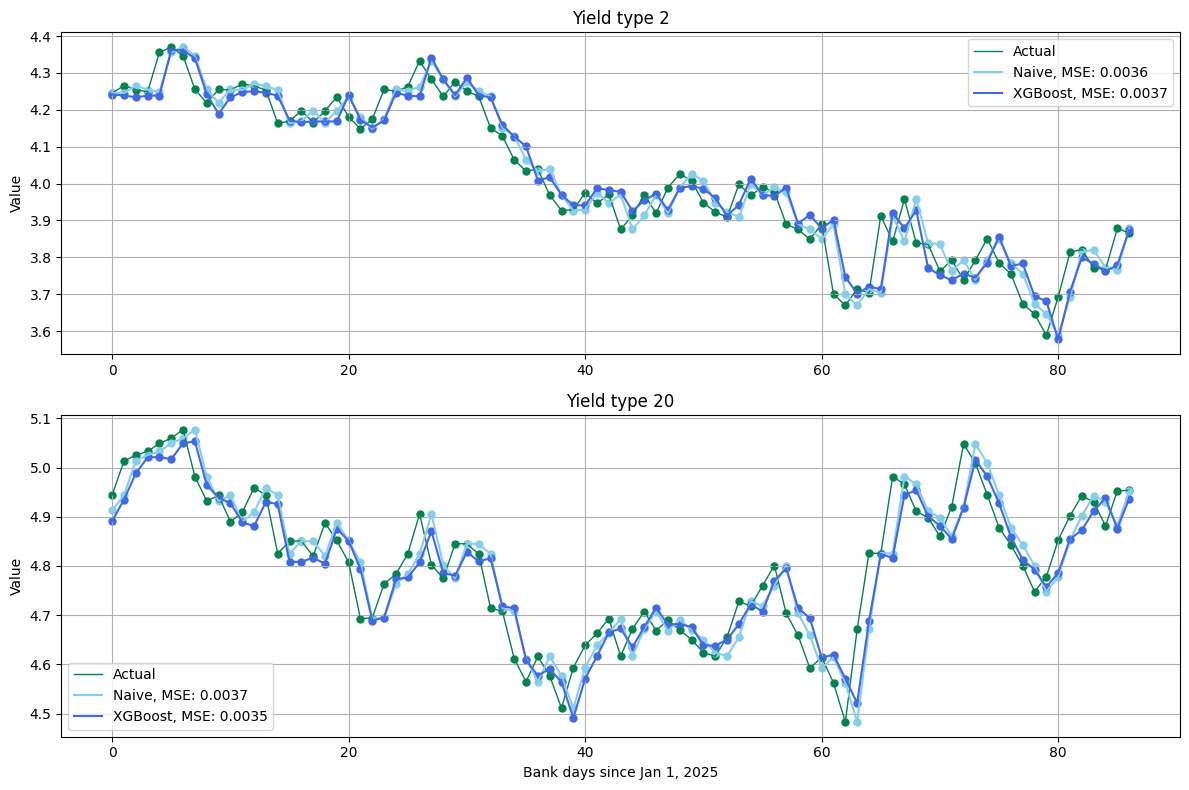

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

mse_xgb_2 = mean_squared_error(actual_2, xgb_pred_2)
mse_naive_2 = mean_squared_error(actual_2, naive_pred_2)

mse_xgb_20 = mean_squared_error(actual_20, xgb_pred_20)
mse_naive_20 = mean_squared_error(actual_20, naive_pred_20)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=False)


x_2 = np.arange(len(actual_2))
axs[0].plot(x_2, actual_2, label='Actual', color="#03814E", linewidth=1)
axs[0].scatter(x_2, actual_2, color="#03814E", s=25)

axs[0].plot(x_2, naive_pred_2, label=f'Naive, MSE: {mse_naive_2:.4f}', color='skyblue')
axs[0].scatter(x_2, naive_pred_2, color='skyblue', s=25)

axs[0].plot(x_2, xgb_pred_2, label=f'XGBoost, MSE: {mse_xgb_2:.4f}', color='royalblue')
axs[0].scatter(x_2, xgb_pred_2, color='royalblue', s=25)

axs[0].set_title(f'Yield type 2')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)


x_20 = np.arange(len(actual_20))
axs[1].plot(x_20, actual_20, label='Actual', color="#03814E", linewidth=1)
axs[1].scatter(x_20, actual_20, color="#03814E", s=25)

axs[1].plot(x_20, naive_pred_20, label=f'Naive, MSE: {mse_naive_20:.4f}', color='skyblue')
axs[1].scatter(x_20, naive_pred_20, color='skyblue', s=25)

axs[1].plot(x_20, xgb_pred_20, label=f'XGBoost, MSE: {mse_xgb_20:.4f}', color='royalblue')
axs[1].scatter(x_20, xgb_pred_20, color='royalblue', s=25)

axs[1].set_title(f'Yield type 20')
axs[1].set_xlabel('Bank days since Jan 1, 2025')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## GRU

### Fitting the model type 2

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



df = plot_data.dropna()

df = df.drop(columns=['BETA0', 'BETA1', 'BETA2'], errors='ignore')


df['Date'] = pd.to_datetime(df['Date'])

df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month


train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')


train_df = df[df['Date'] < train_end]
val_df = df[(df['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = df[df['Date'] >= val_end]

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")



Train set: 8234 rows
Validation set: 1750 rows
Test set: 89 rows


In [ ]:
target_col = '2'
features = [col for col in df.columns if col not in ['Date', target_col]]

def create_sliding_windows(df, target_col, seq_length=30):
    feature_cols = [col for col in df.columns if col not in ['Date', target_col]]
    data = df[feature_cols].values
    targets = df[target_col].values
    
    X, y = [], []
    for i in range(len(df) - seq_length):
        seq_x = data[i:i+seq_length]
        seq_y = targets[i+seq_length]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

seq_length = 30

X_train, y_train = create_sliding_windows(train_df, target_col, seq_length)
X_val, y_val = create_sliding_windows(val_df, target_col, seq_length)
val_tail = val_df[-seq_length:].copy()
test_with_context = pd.concat([val_tail, test_df], axis=0)

X_test, y_test = create_sliding_windows(test_with_context, target_col, seq_length)


print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()



Train shape: (8204, 30, 21)
Val shape: (1720, 30, 21)
Test shape: (89, 30, 21)


In [ ]:

gru_model = tf.keras.Sequential()
gru_model.add(tf.keras.layers.GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(tf.keras.layers.Dropout(0.5))
gru_model.add(tf.keras.layers.GRU(64))
gru_model.add(tf.keras.layers.Dense(1))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss='mse')



early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=2
)



Epoch 1/100


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



129/129 - 3s - 27ms/step - loss: 0.0599 - val_loss: 0.0059
Epoch 2/100
129/129 - 3s - 21ms/step - loss: 0.0081 - val_loss: 0.0093
Epoch 3/100
129/129 - 3s - 21ms/step - loss: 0.0058 - val_loss: 0.0086
Epoch 4/100
129/129 - 3s - 21ms/step - loss: 0.0049 - val_loss: 0.0062
Epoch 5/100


129/129 - 3s - 22ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 6/100


129/129 - 3s - 21ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 7/100
129/129 - 3s - 21ms/step - loss: 0.0036 - val_loss: 0.0077
Epoch 8/100


129/129 - 3s - 21ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 9/100
129/129 - 3s - 21ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 10/100
129/129 - 3s - 21ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 11/100
129/129 - 3s - 21ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 12/100
129/129 - 3s - 21ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 13/100
129/129 - 3s - 21ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 14/100
129/129 - 3s - 21ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 15/100
129/129 - 3s - 21ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 16/100


129/129 - 3s - 22ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 17/100
129/129 - 3s - 21ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 18/100
129/129 - 3s - 22ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 19/100
129/129 - 3s - 20ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 20/100
129/129 - 3s - 20ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 21/100
129/129 - 3s - 21ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 22/100
129/129 - 3s - 21ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 23/100
129/129 - 3s - 21ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 24/100
129/129 - 3s - 20ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 25/100


129/129 - 3s - 20ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 26/100
129/129 - 3s - 21ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 27/100
129/129 - 3s - 20ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 28/100
129/129 - 3s - 20ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 29/100
129/129 - 3s - 21ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 30/100
129/129 - 3s - 20ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 31/100


129/129 - 3s - 21ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 32/100
129/129 - 3s - 20ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 33/100
129/129 - 3s - 20ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 34/100
129/129 - 3s - 21ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 35/100
129/129 - 3s - 21ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 36/100
129/129 - 3s - 20ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 37/100
129/129 - 3s - 20ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 38/100
129/129 - 3s - 20ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 39/100
129/129 - 3s - 21ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 40/100


129/129 - 3s - 20ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 41/100
129/129 - 3s - 22ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 42/100
129/129 - 3s - 23ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 43/100
129/129 - 3s - 23ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 44/100
129/129 - 3s - 23ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 45/100
129/129 - 3s - 23ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 46/100
129/129 - 3s - 24ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 47/100
129/129 - 3s - 23ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 48/100
129/129 - 3s - 23ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 49/100
129/129 - 3s - 23ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 50/100
129/129 - 3s - 22ms/step - loss: 0.0016 - val_loss: 0.0019


#### Bayesian optimization

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

search_space = [
    Integer(32, 256, name='gru_units_1'),
    Integer(16, 128, name='gru_units_2'),
    Real(0.0, 0.5, name='dropout_rate'),
    Real(1e-4, 1e-2, name='learning_rate'),
    Integer(32, 128, name='batch_size')
]


def build_model(input_shape, gru_units_1, gru_units_2, dropout_rate, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(int(gru_units_1), return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.GRU(int(gru_units_2)),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model



tscv = TimeSeriesSplit(n_splits=3)

@use_named_args(search_space)
def objective(gru_units_1, gru_units_2, dropout_rate, learning_rate, batch_size):
    mse_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_tr, y_val_fold = y_train[train_idx], y_train[val_idx]

        model = build_model(
            input_shape=(X_train.shape[1], X_train.shape[2]),
            gru_units_1=gru_units_1,
            gru_units_2=gru_units_2,
            dropout_rate=dropout_rate,
            learning_rate=learning_rate
        )

        model.fit(
            X_tr, y_tr,
            epochs=50,
            batch_size=batch_size,
            verbose=0,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            ]
        )

        y_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_pred)
        mse_scores.append(mse)

    mean_mse = np.mean(mse_scores)
    print(f"MSE: {mean_mse:.5f} | Params: {gru_units_1}, {gru_units_2}, dropout={dropout_rate:.3f}, lr={learning_rate:.4f}, batch={batch_size}")
    return mean_mse





In [ ]:
result = gp_minimize(
    objective,
    search_space,
    n_calls=30,
    random_state=42,
    verbose=True
)

print("\n✅ Best MSE:", result.fun)
print("✅ Best Parameters:")
for name, val in zip([dim.name for dim in search_space], result.x):
    print(f"  {name}: {val}")


Iteration No: 1 started. Evaluating function at random point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
MSE: 0.00367 | Params: 210, 37, dropout=0.390, lr=0.0060, batch=75
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 126.8438
Function value obtained: 0.0037
Current minimum: 0.0037
Iteration No: 2 started. Evaluating function at random point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE: 0.00291 | Params: 54, 67, dropout=0.167, lr=0.0015, batch=94
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 59.3129
Function value obtained: 0.0029
Current minimum: 0.0029
Iteration No: 3 started. Evaluating function at random point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE: 0.01215 | Params: 45, 97, dropout=0.469, lr=0.0001, batch=127
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 59.9436
Function value obtained: 0.0121
Current minimum: 0.0029
Iteration No: 4 started. Evaluating function at random point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
MSE: 0.00349 | Params: 170, 85, dropout=0.004, lr=0.0003, batch=82
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 172.2149
Function value obtained: 0.0035
Current minimum: 0.0029
Iteration No: 5 started. Evaluating function at random point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MSE: 0.00253 | Params: 122, 21, dropout=0.487, lr=0.0024, batch=41
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 70.4059
Function value obtained: 0.0025
Current minimum: 0.0025
Iteration No: 6 started. Evaluating function at random point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
MSE: 0.00292 | Params: 171, 59, dropout=0.492, lr=0.0047, batch=115
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 112.4195
Function value obtained: 0.0029
Current minimum: 0.0025
Iteration No: 7 started. Evaluating function at random point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
MSE: 0.03424 | Params: 184, 66, dropout=0.007, lr=0.0094, batch=86
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 164.5587
Function value obtained: 0.0342
Current minimum: 0.0025
Iteration No: 8 started. Evaluating function at random point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MSE: 0.00313 | Params: 118, 18, dropout=0.115, lr=0.0025, batch=98
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 68.3154
Function value obtained: 0.0031
Current minimum: 0.0025
Iteration No: 9 started. Evaluating function at random point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
MSE: 0.00223 | Params: 169, 109, dropout=0.087, lr=0.0040, batch=49
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 134.7040
Function value obtained: 0.0022
Current minimum: 0.0022
Iteration No: 10 started. Evaluating function at random point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MSE: 0.00215 | Params: 201, 64, dropout=0.104, lr=0.0057, batch=35
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 193.2677
Function value obtained: 0.0021
Current minimum: 0.0021
Iteration No: 11 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
MSE: 0.00167 | Params: 256, 128, dropout=0.000, lr=0.0017, batch=32
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 409.2204
Function value obtained: 0.0017
Current minimum: 0.0017
Iteration No: 12 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MSE: 0.00288 | Params: 32, 128, dropout=0.000, lr=0.0056, batch=32
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 140.0054
Function value obtained: 0.0029
Current minimum: 0.0017
Iteration No: 13 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 0.00301 | Params: 32, 16, dropout=0.500, lr=0.0048, batch=32
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 51.1029
Function value obtained: 0.0030
Current minimum: 0.0017
Iteration No: 14 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
MSE: 0.11869 | Params: 167, 87, dropout=0.495, lr=0.0100, batch=111
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 168.1562
Function value obtained: 0.1187
Current minimum: 0.0017
Iteration No: 15 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
MSE: 0.23962 | Params: 256, 128, dropout=0.000, lr=0.0071, batch=32
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 569.0839
Function value obtained: 0.2396
Current minimum: 0.0017
Iteration No: 16 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
MSE: 0.00124 | Params: 256, 128, dropout=0.000, lr=0.0008, batch=32
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 392.3261
Function value obtained: 0.0012
Current minimum: 0.0012
Iteration No: 17 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 0.00690 | Params: 32, 16, dropout=0.000, lr=0.0100, batch=32
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 54.7349
Function value obtained: 0.0069
Current minimum: 0.0012
Iteration No: 18 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MSE: 0.14139 | Params: 256, 16, dropout=0.000, lr=0.0100, batch=32
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 310.1293
Function value obtained: 0.1414
Current minimum: 0.0012
Iteration No: 19 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MSE: 0.02707 | Params: 200, 16, dropout=0.396, lr=0.0079, batch=128
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 142.2905
Function value obtained: 0.0271
Current minimum: 0.0012
Iteration No: 20 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MSE: 0.00354 | Params: 207, 16, dropout=0.500, lr=0.0041, batch=105
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 130.1824
Function value obtained: 0.0035
Current minimum: 0.0012
Iteration No: 21 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MSE: 0.00371 | Params: 183, 93, dropout=0.342, lr=0.0038, batch=98
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 184.2486
Function value obtained: 0.0037
Current minimum: 0.0012
Iteration No: 22 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MSE: 0.00433 | Params: 68, 80, dropout=0.427, lr=0.0061, batch=118
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 63.2399
Function value obtained: 0.0043
Current minimum: 0.0012
Iteration No: 23 started. Searching for the next optimal point.


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



42/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

KeyboardInterrupt: 

In [ ]:
print("\n✅ Best MSE so far:", result.fun)
print("✅ Best Parameters so far:")
for name, val in zip([dim.name for dim in search_space], result.x):
    print(f"  {name}: {val}")


✅ Best MSE so far: 0.4078714752165331
✅ Best Parameters so far:
  gru_units_1: 2
  gru_units_2: 13
  dropout_rate: 0.07836913500020315


### Fitting final model

In [ ]:
from tensorflow.keras.layers import GRU, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import random
import numpy as np
import tensorflow as tf
import os

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"



seq_length = 30

X_train, y_train = create_sliding_windows(train_df, target_col, seq_length)
X_val, y_val = create_sliding_windows(val_df, target_col, seq_length)
val_tail = val_df[-seq_length:].copy()
test_with_context = pd.concat([val_tail, test_df], axis=0)


X_test, y_test = create_sliding_windows(test_with_context, target_col, seq_length)


print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


X_final_train = np.concatenate([X_train, X_val], axis=0)
y_final_train = np.concatenate([y_train, y_val], axis=0)


final_model = tf.keras.Sequential()
final_model.add(tf.keras.layers.GRU(64, return_sequences=True, input_shape=(X_final_train.shape[1], X_final_train.shape[2])))
final_model.add(tf.keras.layers.Dropout(0.2))
final_model.add(tf.keras.layers.GRU(64, return_sequences=False))
final_model.add(LeakyReLU(alpha=0.1))
final_model.add(tf.keras.layers.Dense(1))


final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')


history_final = final_model.fit(
    X_final_train, y_final_train,
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)



y_pred_final_scaled = final_model.predict(X_test).flatten()


y_pred_final = scaler_y.inverse_transform(y_pred_final_scaled.reshape(-1, 1)).flatten()
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


mse_final = mean_squared_error(y_test_unscaled, y_pred_final)
print(f"Final MSE on Test (unscaled): {mse_final:.4f}")

gru_pred_series_2 = pd.Series(y_pred_final, index=test_df.index[:len(y_pred_final)])



Train shape: (8231, 3, 21)
Val shape: (1747, 3, 21)
Test shape: (89, 3, 21)
Epoch 1/30


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



312/312 - 1s - 4ms/step - loss: 0.0687
Epoch 2/30


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



312/312 - 0s - 1ms/step - loss: 0.0063
Epoch 3/30
312/312 - 0s - 1ms/step - loss: 0.0048
Epoch 4/30
312/312 - 0s - 1ms/step - loss: 0.0041
Epoch 5/30
312/312 - 0s - 1ms/step - loss: 0.0036
Epoch 6/30
312/312 - 0s - 1ms/step - loss: 0.0033
Epoch 7/30
312/312 - 0s - 1ms/step - loss: 0.0031
Epoch 8/30
312/312 - 0s - 1ms/step - loss: 0.0028
Epoch 9/30
312/312 - 0s - 1ms/step - loss: 0.0027
Epoch 10/30
312/312 - 0s - 1ms/step - loss: 0.0026
Epoch 11/30
312/312 - 0s - 1ms/step - loss: 0.0024
Epoch 12/30
312/312 - 0s - 1ms/step - loss: 0.0023
Epoch 13/30
312/312 - 0s - 1ms/step - loss: 0.0022
Epoch 14/30
312/312 - 0s - 1ms/step - loss: 0.0022
Epoch 15/30
312/312 - 0s - 1ms/step - loss: 0.0022
Epoch 16/30
312/312 - 0s - 1ms/step - loss: 0.0020
Epoch 17/30
312/312 - 0s - 1ms/step - loss: 0.0020
Epoch 18/30
312/312 - 0s - 1ms/step - loss: 0.0019
Epoch 19/30
312/312 - 0s - 1ms/step - loss: 0.0019
Epoch 20/30
312/312 - 0s - 1ms/step - loss: 0.0019
Epoch 21/30
312/312 - 0s - 1ms/step - loss: 0.0018

### Fitting the model type 20

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



df = plot_data.dropna()

df = df.drop(columns=['BETA0', 'BETA1', 'BETA2'], errors='ignore')


df['Date'] = pd.to_datetime(df['Date'])

df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month


train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')


train_df = df[df['Date'] < train_end]
val_df = df[(df['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = df[df['Date'] >= val_end]

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")



Train set: 8234 rows
Validation set: 1750 rows
Test set: 89 rows


In [ ]:
target_col = '20'
features = [col for col in df.columns if col not in ['Date', target_col]]

def create_sliding_windows(df, target_col, seq_length=30):
    feature_cols = [col for col in df.columns if col not in ['Date', target_col]]
    data = df[feature_cols].values
    targets = df[target_col].values
    
    X, y = [], []
    for i in range(len(df) - seq_length):
        seq_x = data[i:i+seq_length]
        seq_y = targets[i+seq_length]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

seq_length = 30

X_train, y_train = create_sliding_windows(train_df, target_col, seq_length)
X_val, y_val = create_sliding_windows(val_df, target_col, seq_length)
val_tail = val_df[-seq_length:].copy()
test_with_context = pd.concat([val_tail, test_df], axis=0)

X_test, y_test = create_sliding_windows(test_with_context, target_col, seq_length)


print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()



Train shape: (8204, 30, 21)
Val shape: (1720, 30, 21)
Test shape: (89, 30, 21)


In [ ]:
from tensorflow.keras.layers import GRU, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping




print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


X_final_train = np.concatenate([X_train, X_val], axis=0)
y_final_train = np.concatenate([y_train, y_val], axis=0)


final_model = tf.keras.Sequential()
final_model.add(tf.keras.layers.GRU(128, return_sequences=True, input_shape=(X_final_train.shape[1], X_final_train.shape[2])))
final_model.add(tf.keras.layers.Dropout(0.2))
final_model.add(tf.keras.layers.GRU(64, return_sequences=False)) 
final_model.add(LeakyReLU(alpha=0.1))
final_model.add(tf.keras.layers.Dense(1))


final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')


history_final = final_model.fit(
    X_final_train, y_final_train,
    epochs=20,
    batch_size=32,
    verbose=2
)


y_pred_final_scaled = final_model.predict(X_test).flatten()


y_pred_final = scaler_y.inverse_transform(y_pred_final_scaled.reshape(-1, 1)).flatten()
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


mse_final = mean_squared_error(y_test_unscaled, y_pred_final)
print(f"Final MSE on Test (unscaled): {mse_final:.4f}")



gru_pred_series_20 = pd.Series(y_pred_final, index=test_df.index[:len(y_pred_final)])



Train shape: (19850, 30, 21)
Val shape: (1, 30, 21)
Test shape: (1, 30, 21)
Epoch 1/20


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



621/621 - 9s - 15ms/step - loss: 0.0144
Epoch 2/20
621/621 - 9s - 14ms/step - loss: 0.0047
Epoch 3/20
621/621 - 9s - 14ms/step - loss: 0.0039
Epoch 4/20
621/621 - 8s - 14ms/step - loss: 0.0034
Epoch 5/20
621/621 - 8s - 13ms/step - loss: 0.0029
Epoch 6/20
621/621 - 8s - 13ms/step - loss: 0.0029
Epoch 7/20
621/621 - 8s - 13ms/step - loss: 0.0028
Epoch 8/20
621/621 - 8s - 13ms/step - loss: 0.0028
Epoch 9/20
621/621 - 8s - 13ms/step - loss: 0.0027
Epoch 10/20
621/621 - 8s - 13ms/step - loss: 0.0026
Epoch 11/20
621/621 - 8s - 13ms/step - loss: 0.0026
Epoch 12/20
621/621 - 8s - 13ms/step - loss: 0.0024
Epoch 13/20
621/621 - 8s - 13ms/step - loss: 0.0024
Epoch 14/20
621/621 - 8s - 13ms/step - loss: 0.0024
Epoch 15/20
621/621 - 8s - 14ms/step - loss: 0.0023
Epoch 16/20
621/621 - 8s - 13ms/step - loss: 0.0022
Epoch 17/20
621/621 - 8s - 14ms/step - loss: 0.0022
Epoch 18/20
621/621 - 8s - 13ms/step - loss: 0.0021
Epoch 19/20
621/621 - 8s - 13ms/step - loss: 0.0021
Epoch 20/20
621/621 - 8s - 13ms/

### Bayesian optimization

In [ ]:
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters

def build_optimized_gru_model(hp):
    model = Sequential()
    
    model.add(GRU(
        units=hp.Int('gru_units_1', min_value=64, max_value=256, step=32),
        return_sequences=True,
        input_shape=(X_final_train.shape[1], X_final_train.shape[2])
    ))
    
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    model.add(GRU(
        units=hp.Int('gru_units_2', min_value=32, max_value=128, step=32),
        return_sequences=False
    ))
    
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mse'
    )
    
    return model


tuner = BayesianOptimization(
    build_optimized_gru_model,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=1,
    directory='opt_gru',
    project_name='gru_bo_tuning'
)

tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=30,
             batch_size=32,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
             verbose=2)

best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_final_train, y_final_train,
    epochs=40,
    batch_size=best_hps.get('batch_size'),
    verbose=2
)

y_pred_final_scaled = best_model.predict(X_test).flatten()
y_pred_final = scaler_y.inverse_transform(y_pred_final_scaled.reshape(-1, 1)).flatten()
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

mse_final = mean_squared_error(y_test_unscaled, y_pred_final)
print(f"Optimized GRU - Final MSE on Test (unscaled): {mse_final:.4f}")

gru_pred_series_20 = pd.Series(y_pred_final, index=test_df.index[:len(y_pred_final)])


Trial 15 Complete [00h 02m 02s]
val_loss: 0.002103579230606556

Best val_loss So Far: 0.0015492881648242474
Total elapsed time: 01h 56m 31s


KeyError: 'batch_size does not exist.'

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")


NameError: name 'tuner' is not defined

### Fiting final model

In [ ]:
from tensorflow.keras.layers import GRU, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


seq_length = 30

X_train, y_train = create_sliding_windows(train_df, target_col, seq_length)
X_val, y_val = create_sliding_windows(val_df, target_col, seq_length)
val_tail = val_df[-seq_length:].copy()
test_with_context = pd.concat([val_tail, test_df], axis=0)


X_test, y_test = create_sliding_windows(test_with_context, target_col, seq_length)


print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


X_final_train = np.concatenate([X_train, X_val], axis=0)
y_final_train = np.concatenate([y_train, y_val], axis=0)


final_model = tf.keras.Sequential()
final_model.add(tf.keras.layers.GRU(128, return_sequences=True, input_shape=(X_final_train.shape[1], X_final_train.shape[2])))
final_model.add(tf.keras.layers.Dropout(0.2))
final_model.add(tf.keras.layers.GRU(64, return_sequences=False))
final_model.add(LeakyReLU(alpha=0.1))
final_model.add(tf.keras.layers.Dense(1))


final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')


history_final = final_model.fit(
    X_final_train, y_final_train,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)



y_pred_final_scaled = final_model.predict(X_test).flatten()


y_pred_final = scaler_y.inverse_transform(y_pred_final_scaled.reshape(-1, 1)).flatten()
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


mse_final = mean_squared_error(y_test_unscaled, y_pred_final)
print(f"Final MSE on Test (unscaled): {mse_final:.4f}")

gru_pred_series_20 = pd.Series(y_pred_final, index=test_df.index[:len(y_pred_final)])


Train shape: (8204, 30, 21)
Val shape: (1720, 30, 21)
Test shape: (89, 30, 21)
Epoch 1/20


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



311/311 - 5s - 16ms/step - loss: 0.0157
Epoch 2/20


/opt/anaconda3/envs/appml25/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



311/311 - 4s - 14ms/step - loss: 0.0038
Epoch 3/20
311/311 - 4s - 14ms/step - loss: 0.0032
Epoch 4/20
311/311 - 4s - 13ms/step - loss: 0.0031
Epoch 5/20
311/311 - 4s - 13ms/step - loss: 0.0026
Epoch 6/20
311/311 - 4s - 13ms/step - loss: 0.0026
Epoch 7/20
311/311 - 4s - 13ms/step - loss: 0.0024
Epoch 8/20
311/311 - 4s - 13ms/step - loss: 0.0025
Epoch 9/20
311/311 - 4s - 13ms/step - loss: 0.0022
Epoch 10/20
311/311 - 4s - 13ms/step - loss: 0.0023
Epoch 11/20
311/311 - 4s - 13ms/step - loss: 0.0021
Epoch 12/20
311/311 - 5s - 14ms/step - loss: 0.0019
Epoch 13/20
311/311 - 4s - 14ms/step - loss: 0.0020
Epoch 14/20
311/311 - 4s - 13ms/step - loss: 0.0019
Epoch 15/20
311/311 - 4s - 14ms/step - loss: 0.0019
Epoch 16/20
311/311 - 4s - 14ms/step - loss: 0.0019
Epoch 17/20
311/311 - 4s - 14ms/step - loss: 0.0018
Epoch 18/20
311/311 - 4s - 14ms/step - loss: 0.0016
Epoch 19/20
311/311 - 4s - 13ms/step - loss: 0.0020
Epoch 20/20
311/311 - 4s - 14ms/step - loss: 0.0016
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57m

## Plotting

In [ ]:
gru_pred_aligned_2 = gru_pred_series_2.shift(-1).dropna()

common_idx = actual_2.index.intersection(gru_pred_aligned_2.index)

actual_2_aligned = actual_2.loc[common_idx]
gru_pred_aligned_2 = gru_pred_aligned_2.loc[common_idx]



gru_pred_aligned_20 = gru_pred_series_20.shift(-1).dropna()

common_idx = actual_20.index.intersection(gru_pred_aligned_20.index)

actual_20_aligned = actual_20.loc[common_idx]
gru_pred_aligned_20 = gru_pred_aligned_20.loc[common_idx]

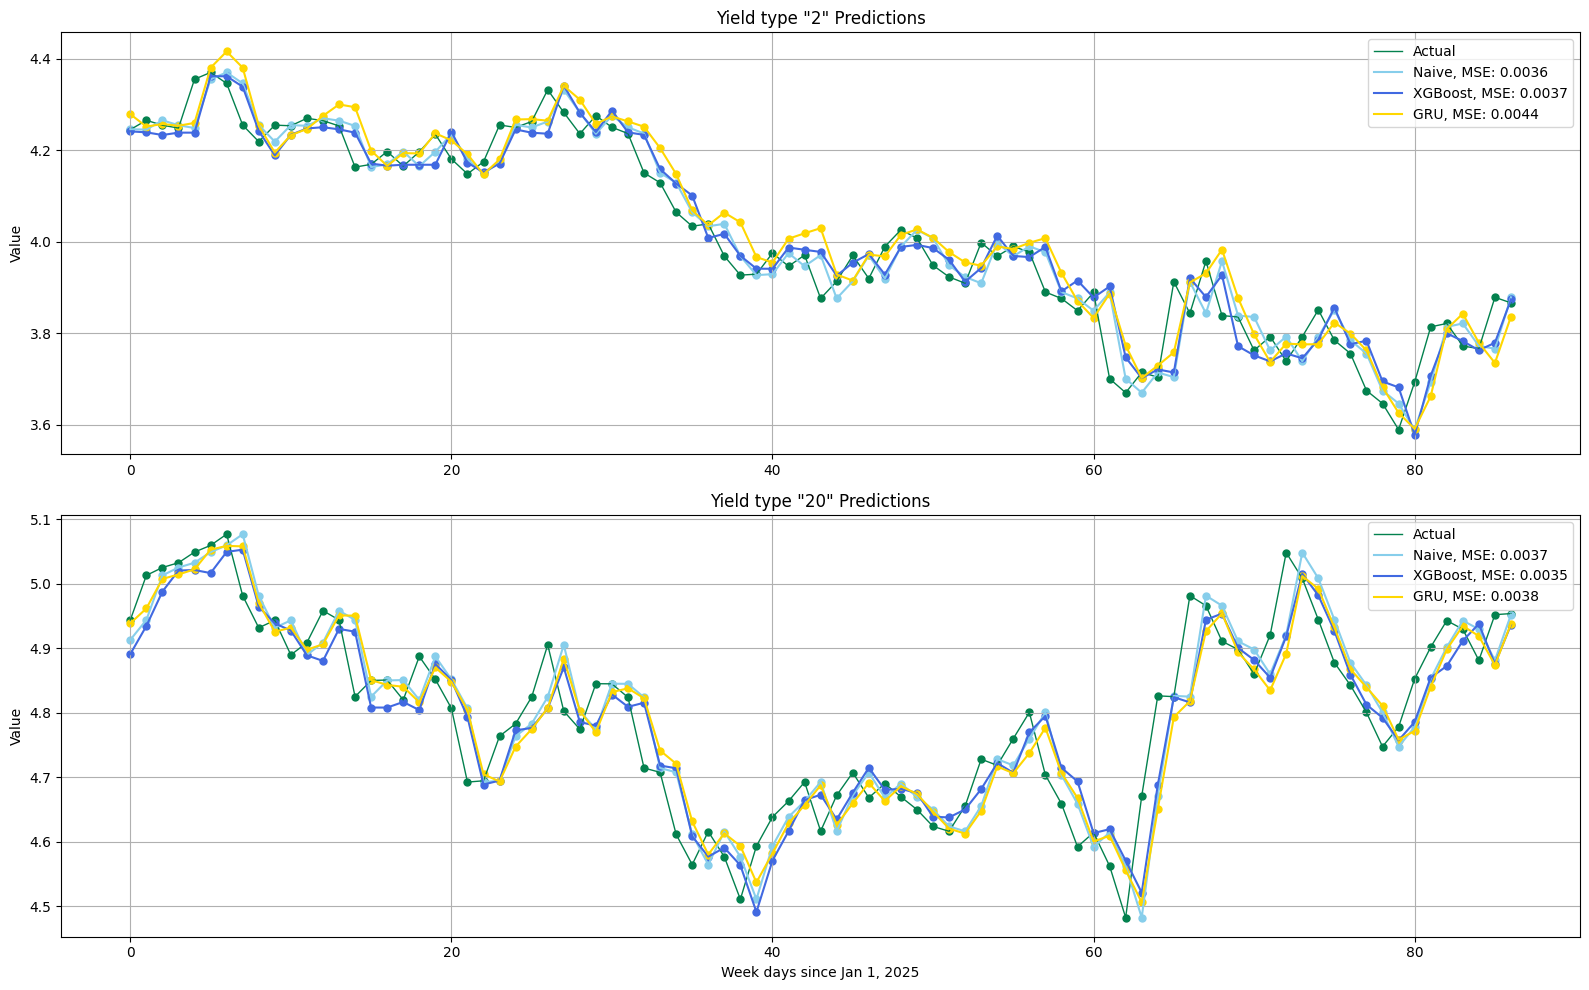

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

mse_xgb_2 = mean_squared_error(actual_2, xgb_pred_2)
mse_naive_2 = mean_squared_error(actual_2, naive_pred_2)
mse_gru_2 = mean_squared_error(actual_2_aligned, gru_pred_aligned_2)


mse_xgb_20 = mean_squared_error(actual_20, xgb_pred_20)
mse_naive_20 = mean_squared_error(actual_20, naive_pred_20)
mse_gru_20 = mean_squared_error(actual_20, gru_pred_aligned_20)


fig, axs = plt.subplots(2, 1, figsize=(16, 10), sharex=False)


x_2 = np.arange(len(actual_2))
axs[0].plot(x_2, actual_2, label='Actual', color="#03814E", linewidth=1)
axs[0].scatter(x_2, actual_2, color="#03814E", s=25)

axs[0].plot(x_2, naive_pred_2, label=f'Naive, MSE: {mse_naive_2:.4f}', color='skyblue')
axs[0].scatter(x_2, naive_pred_2, color='skyblue', s=25)

axs[0].plot(x_2, xgb_pred_2, label=f'XGBoost, MSE: {mse_xgb_2:.4f}', color='royalblue')
axs[0].scatter(x_2, xgb_pred_2, color='royalblue', s=25)

axs[0].plot(x_2, gru_pred_aligned_2, label=f'GRU, MSE: {mse_gru_2:.4f}', color='gold')
axs[0].scatter(x_2, gru_pred_aligned_2, color='gold', s=25)

axs[0].set_title(f'Yield type "2" Predictions')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)



x_20 = np.arange(len(actual_20))
axs[1].plot(x_20, actual_20, label='Actual', color="#03814E", linewidth=1)
axs[1].scatter(x_20, actual_20, color="#03814E", s=25)

axs[1].plot(x_20, naive_pred_20, label=f'Naive, MSE: {mse_naive_20:.4f}', color='skyblue')
axs[1].scatter(x_20, naive_pred_20, color='skyblue', s=25)

axs[1].plot(x_20, xgb_pred_20, label=f'XGBoost, MSE: {mse_xgb_20:.4f}', color='royalblue')
axs[1].scatter(x_20, xgb_pred_20, color='royalblue', s=25)

axs[1].plot(x_20, gru_pred_aligned_20, label=f'GRU, MSE: {mse_gru_20:.4f}', color='gold')
axs[1].scatter(x_20, gru_pred_aligned_20, color='gold', s=25)

axs[1].set_title(f'Yield type "20" Predictions')
axs[1].set_xlabel('Week days since Jan 1, 2025')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## GRU evaluation

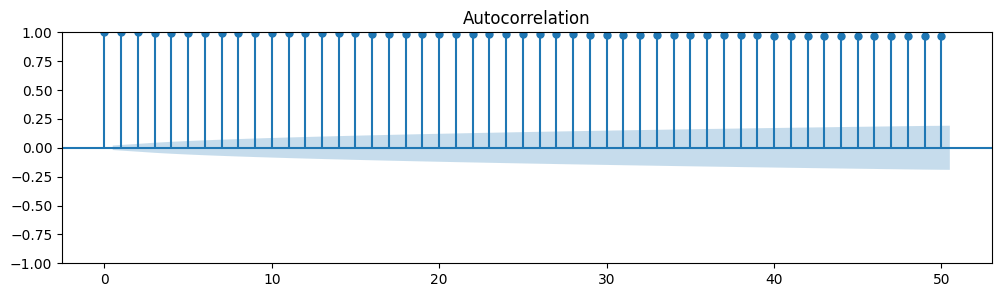

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

yield_series = df['20'].values


fig, ax = plt.subplots(figsize=(12, 3)) 
plot_acf(yield_series, lags=50, ax=ax) 
plt.show()



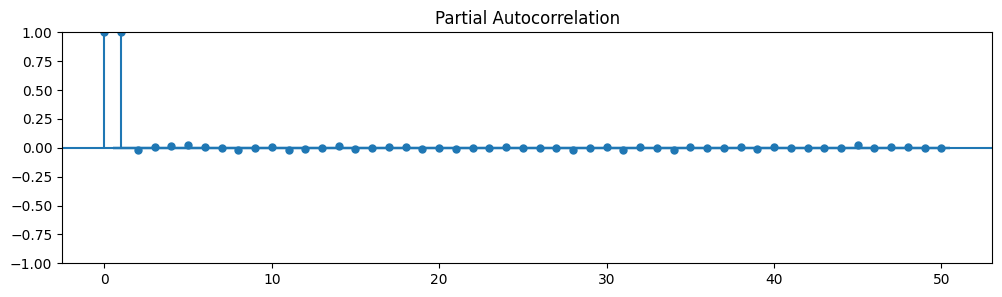

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12, 3)) 
plot_pacf(yield_series, lags=50, ax=ax) 
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(yield_series)
print(f'p-værdi: {result[1]}')


p-værdi: 0.1825586884229462


## XGBoost - 5 days ahead

### Yield type 2

#### First model

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

target_col = "2"  
n_lags = 200
forecast_horizon = 5

def create_lag_features(df, col, n_lags=n_lags, forecast_horizon=forecast_horizon):
    df = df.sort_values("Date").copy()

    target = df[[col]].shift(-forecast_horizon).rename(columns={col: f"{col}_target"})

    lagged_features = [
        df[[col]].shift(lag - forecast_horizon).rename(columns={col: f"{col}_lag_{lag}"})
        for lag in range(1, n_lags + 1)
    ]

    calendar_features = pd.DataFrame({
        'day_of_week': df['Date'].dt.dayofweek,
        'day_of_month': df['Date'].dt.day,
        'month': df['Date'].dt.month
    }, index=df.index)

    df_lagged = pd.concat([df[['Date']], target] + lagged_features + [calendar_features], axis=1)

    return df_lagged.dropna()


df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "eta": 0.05,
    "verbosity": 0
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=20,
    verbose_eval=True
)

y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

naive_pred_val = df_lagged.loc[val_mask, "2_lag_10"]


[0]	train-rmse:2.51987	eval-rmse:2.14074
[1]	train-rmse:2.39475	eval-rmse:2.03666
[2]	train-rmse:2.27587	eval-rmse:1.93766
[3]	train-rmse:2.16290	eval-rmse:1.84323
[4]	train-rmse:2.05554	eval-rmse:1.75395
[5]	train-rmse:1.95354	eval-rmse:1.66928
[6]	train-rmse:1.85665	eval-rmse:1.58868
[7]	train-rmse:1.76449	eval-rmse:1.51240
[8]	train-rmse:1.67691	eval-rmse:1.43952
[9]	train-rmse:1.59372	eval-rmse:1.37073
[10]	train-rmse:1.51467	eval-rmse:1.30497
[11]	train-rmse:1.43953	eval-rmse:1.24295
[12]	train-rmse:1.36817	eval-rmse:1.18403
[13]	train-rmse:1.30032	eval-rmse:1.12685
[14]	train-rmse:1.23587	eval-rmse:1.07298
[15]	train-rmse:1.17465	eval-rmse:1.02157
[16]	train-rmse:1.11646	eval-rmse:0.97366
[17]	train-rmse:1.06118	eval-rmse:0.92814
[18]	train-rmse:1.00865	eval-rmse:0.88466
[19]	train-rmse:0.95875	eval-rmse:0.84281
[20]	train-rmse:0.91132	eval-rmse:0.80277
[21]	train-rmse:0.86626	eval-rmse:0.76547
[22]	train-rmse:0.82345	eval-rmse:0.72954
[23]	train-rmse:0.78274	eval-rmse:0.69480
[2

#### Bayesian optimization

In [ ]:
from skopt import  gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

search_space = [
    Integer(1, 200, name='n_lags'),
    Integer(2, 15, name='max_depth'),
    Real(0.001, 0.3, name='eta')
]

tscv = TimeSeriesSplit(n_splits=3)

N_REPEATS = 3

@use_named_args(search_space)
def objective(n_lags, max_depth, eta):
    df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

    target = f"{target_col}_target"
    features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

    X = df_lagged[features]
    y = df_lagged[target]

    mse_repeats = []

    for repeat in range(N_REPEATS):
        mse_scores = []

        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)

            params = {
                "objective": "reg:squarederror",
                "max_depth": max_depth,
                "eta": eta,
                "verbosity": 0,
                "seed": 42 + repeat 
            }

            bst = xgb.train(
                params,
                dtrain,
                evals=[(dval, 'eval')],
                num_boost_round=1000,
                early_stopping_rounds=20,
                verbose_eval=False
            )

            y_pred_val = bst.predict(dval)
            mse = mean_squared_error(y_val, y_pred_val)
            mse_scores.append(mse)

        mse_repeats.append(np.mean(mse_scores))


    return np.mean(mse_repeats)


result = gp_minimize(
    objective,
    search_space,
    n_calls=100,
    #n_random_starts=10,
    random_state=42,
    verbose=True
)

print("\nBest MSE:", result.fun)
print("Best parameters:")
for name, val in zip([dim.name for dim in search_space], result.x):
    print(f"  {name}: {val}")


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.7535
Function value obtained: 0.4614
Current minimum: 0.4614
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 18.3206
Function value obtained: 0.5204
Current minimum: 0.4614
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.4186
Function value obtained: 0.5059
Current minimum: 0.4614
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.3017
Function value obtained: 0.4616
Current minimum: 0.4614
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.8064
Function value obtained: 0.4911
Current minimum: 0.4614
Iteration No: 6 started. Evaluatin

In [ ]:
n_lags = 455
params = {
    "objective": "reg:squarederror",
    "max_depth": 5,
    "eta": 0.01,
    "subsample": 0.75,
    "colsample_bytree": 0.75,
    "verbosity": 0
}



#### Fitting on full training data

In [ ]:
df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

train_val_mask = train_mask | val_mask

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train_val = df_lagged.loc[train_val_mask, features]
y_train_val = df_lagged.loc[train_val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtest = xgb.DMatrix(X_test, label=y_test)

dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)


bst_final = xgb.train(
    params,
    dtrain_val,
    num_boost_round=1000,
    evals=[(dtrain_val, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)



#### Plotting

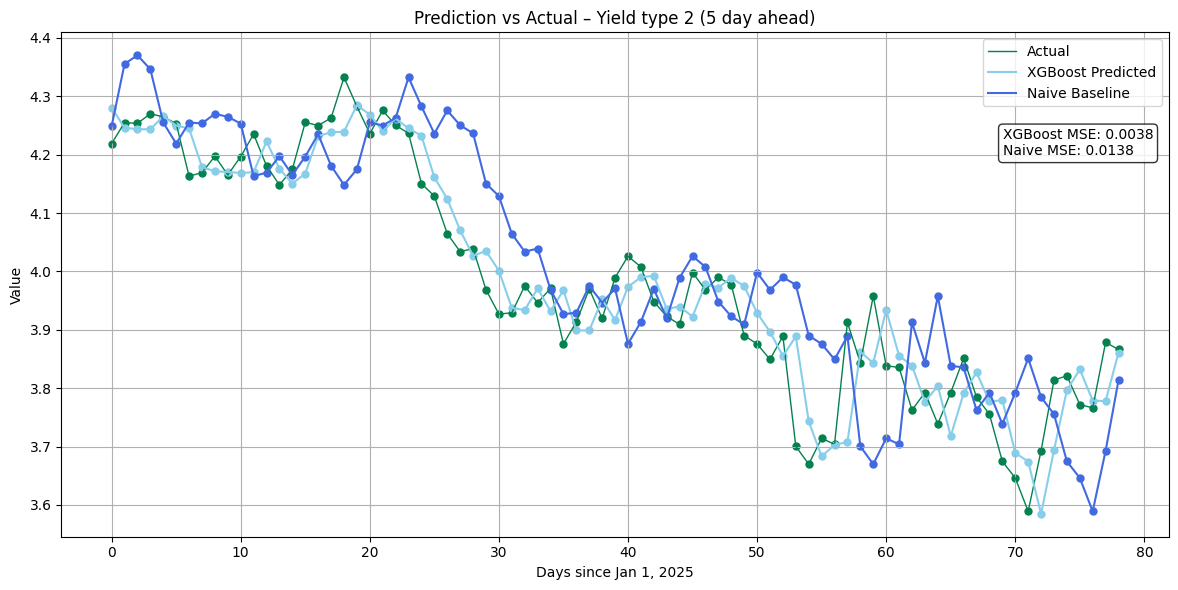

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

naive_pred_series = y_test.shift(forecast_horizon).dropna()
common_index = y_test.index.intersection(naive_pred_series.index)

naive_pred = naive_pred_series.loc[common_index]
y_test_aligned = y_test.loc[common_index]

y_pred_full = pd.Series(bst_final.predict(dtest), index=y_test.index)
y_pred_aligned = y_pred_full.loc[common_index]


actual_2 = y_test_aligned.copy()
xgb_pred_2 = y_pred_aligned.copy()
naive_pred_2 = naive_pred.copy()


x = np.arange(len(y_test_aligned))

mse_xgb = mean_squared_error(y_test_aligned, y_pred_aligned)
mse_naive = mean_squared_error(y_test_aligned, naive_pred)

plt.figure(figsize=(12, 6))


plt.plot(x, y_test_aligned, label='Actual', color='#03814E', linewidth=1)
plt.scatter(x, y_test_aligned, color='#03814E', s=25)

plt.plot(x, y_pred_aligned, label='XGBoost Predicted', color='skyblue')
plt.scatter(x, y_pred_aligned, color='skyblue', s=25)

plt.plot(x, naive_pred, label='Naive Baseline', color='royalblue')
plt.scatter(x, naive_pred, color='royalblue', s=25)

plt.title(f'Prediction vs Actual – Yield type {target_col} ({forecast_horizon} day ahead)')
plt.xlabel('Days since Jan 1, 2025')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

textstr = '\n'.join((
    f'XGBoost MSE: {mse_xgb:.4f}',
    f'Naive MSE: {mse_naive:.4f}',
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.85, 0.75, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.utils import resample

def bootstrap_mse(y_true, y_pred, n_bootstrap=1000, ci=95):
    mses = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        indices = resample(np.arange(n), replace=True, n_samples=n)
        mses.append(mean_squared_error(y_true[indices], y_pred[indices]))
    lower = np.percentile(mses, (100 - ci) / 2)
    upper = np.percentile(mses, 100 - (100 - ci) / 2)
    return np.mean(mses), lower, upper

mean_xgb, lower_xgb, upper_xgb = bootstrap_mse(y_test_aligned.values, y_pred_aligned.values)
mean_naive, lower_naive, upper_naive = bootstrap_mse(y_test_aligned.values, naive_pred.values)

print(f"XGBoost MSE: {mean_xgb:.4f} (95% CI: {lower_xgb:.4f} - {upper_xgb:.4f})")
print(f"Naive MSE: {mean_naive:.4f} (95% CI: {lower_naive:.4f} - {upper_naive:.4f})")


XGBoost MSE: 0.0038 (95% CI: 0.0025 - 0.0055)
Naive MSE: 0.0138 (95% CI: 0.0101 - 0.0181)


### Yield type 20

#### First model

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

target_col = "20"  
n_lags = 500
forecast_horizon = 5

def create_lag_features(df, col, n_lags=n_lags, forecast_horizon=forecast_horizon):
    df = df.sort_values("Date").copy()

    target = df[[col]].shift(-forecast_horizon).rename(columns={col: f"{col}_target"})

    lagged_features = [
        df[[col]].shift(lag - forecast_horizon).rename(columns={col: f"{col}_lag_{lag}"})
        for lag in range(1, n_lags + 1)
    ]

    calendar_features = pd.DataFrame({
        'day_of_week': df['Date'].dt.dayofweek,
        'day_of_month': df['Date'].dt.day,
        'month': df['Date'].dt.month
    }, index=df.index)

    df_lagged = pd.concat([df[['Date']], target] + lagged_features + [calendar_features], axis=1)

    return df_lagged.dropna()



df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "eta": 0.05,
    "verbosity": 0
}

evallist = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=20,
    verbose_eval=True
)

y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

naive_pred_val = df_lagged.loc[val_mask, "20_lag_1"]

val_dates = df_lagged.loc[val_mask, 'Date']
val_2024_mask = val_dates.dt.year == 2024

dates_2024 = val_dates[val_2024_mask]
y_val_2024 = y_val[val_2024_mask]
y_pred_val_2024 = y_pred_val[val_2024_mask]
naive_pred_val_2024 = naive_pred_val[val_2024_mask]

mse_xgb = mean_squared_error(y_val_2024, y_pred_val_2024)
mse_naive = mean_squared_error(y_val_2024, naive_pred_val_2024)



[0]	train-rmse:1.86257	eval-rmse:2.78055
[1]	train-rmse:1.77023	eval-rmse:2.65524
[2]	train-rmse:1.68251	eval-rmse:2.53649
[3]	train-rmse:1.59915	eval-rmse:2.42756
[4]	train-rmse:1.51993	eval-rmse:2.32445
[5]	train-rmse:1.44465	eval-rmse:2.22194
[6]	train-rmse:1.37312	eval-rmse:2.12670
[7]	train-rmse:1.30517	eval-rmse:2.03383
[8]	train-rmse:1.24056	eval-rmse:1.95016
[9]	train-rmse:1.17917	eval-rmse:1.86497
[10]	train-rmse:1.12087	eval-rmse:1.78669
[11]	train-rmse:1.06544	eval-rmse:1.70975
[12]	train-rmse:1.01278	eval-rmse:1.63680
[13]	train-rmse:0.96273	eval-rmse:1.56979
[14]	train-rmse:0.91518	eval-rmse:1.50179
[15]	train-rmse:0.87001	eval-rmse:1.43750
[16]	train-rmse:0.82707	eval-rmse:1.38131
[17]	train-rmse:0.78629	eval-rmse:1.32524
[18]	train-rmse:0.74753	eval-rmse:1.27256
[19]	train-rmse:0.71069	eval-rmse:1.21985
[20]	train-rmse:0.67571	eval-rmse:1.16975
[21]	train-rmse:0.64247	eval-rmse:1.12229
[22]	train-rmse:0.61090	eval-rmse:1.07736
[23]	train-rmse:0.58089	eval-rmse:1.03660
[2

#### Bayesian optimization

In [ ]:
# from skopt import gp_minimize
# from skopt.space import Integer, Real
# from skopt.utils import use_named_args

# search_space = [
#     Integer(1, 500, name='n_lags'),
#     Integer(2, 15, name='max_depth'),
#     Real(0.01, 0.3, name='eta'),
#     Real(0.5, 1.0, name='subsample'),
#     Real(0.5, 1.0, name='colsample_bytree')
# ]

# @use_named_args(search_space)
# def objective(n_lags, max_depth, eta, subsample, colsample_bytree):
#     df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

#     train_mask = df_lagged['Date'] < train_end
#     val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)

#     target = f"{target_col}_target"
#     features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

#     X_train, y_train = df_lagged.loc[train_mask, features], df_lagged.loc[train_mask, target]
#     X_val, y_val = df_lagged.loc[val_mask, features], df_lagged.loc[val_mask, target]

#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dval = xgb.DMatrix(X_val, label=y_val)

#     params = {
#         "objective": "reg:squarederror",
#         "max_depth": max_depth,
#         "eta": eta,
#         "subsample": subsample,
#         "colsample_bytree": colsample_bytree,
#         "verbosity": 0
#     }

#     bst = xgb.train(
#         params,
#         dtrain,
#         evals=[(dval, 'eval')],
#         num_boost_round = 1000,
#         early_stopping_rounds=20,
#         verbose_eval=False
#     )

#     y_pred_val = pd.Series(bst.predict(dval), index=y_val.index)

#     val_dates = df_lagged.loc[val_mask, 'Date']
#     val_2024_mask = val_dates.dt.year == 2024

#     y_val_2024 = y_val[val_2024_mask]
#     y_pred_val_2024 = y_pred_val[val_2024_mask]

#     return mean_squared_error(y_val_2024, y_pred_val_2024)


# result = gp_minimize(
#     objective,
#     search_space,
#     n_calls=100,
#     random_state=42,
#     verbose=False
# )

# print("\nBest MSE:", result.fun)
# print("Best parameters:")
# for name, val in zip([dim.name for dim in search_space], result.x):
#     print(f"  {name}: {val}")


In [ ]:
n_lags = 398
params = {
    "objective": "reg:squarederror",
    "max_depth": 4,
    "eta": 0.23,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "verbosity": 0
}



#### Fitting on full training data

In [ ]:
df_lagged = create_lag_features(df, target_col, n_lags, forecast_horizon)

train_mask = df_lagged['Date'] < train_end
val_mask = (df_lagged['Date'] >= train_end) & (df_lagged['Date'] < val_end)
test_mask = df_lagged['Date'] >= val_end

train_val_mask = train_mask | val_mask

target = f"{target_col}_target"
features = [col for col in df_lagged.columns if col.startswith(f"{target_col}_lag_")]

X_train_val = df_lagged.loc[train_val_mask, features]
y_train_val = df_lagged.loc[train_val_mask, target]
X_test, y_test = df_lagged.loc[test_mask, features], df_lagged.loc[test_mask, target]

dtest = xgb.DMatrix(X_test, label=y_test)

dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)


bst_final = xgb.train(
    params,
    dtrain_val,
    num_boost_round=1000,
    evals=[(dtrain_val, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)



#### Plotting

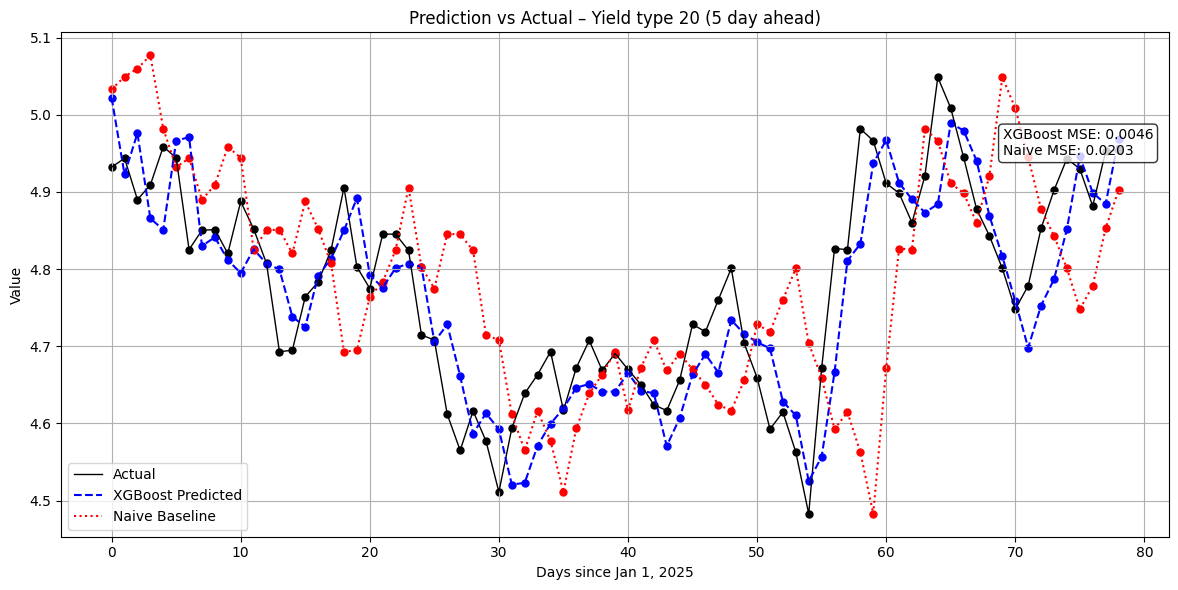

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

naive_pred_series = y_test.shift(forecast_horizon).dropna()
common_index = y_test.index.intersection(naive_pred_series.index)

naive_pred = naive_pred_series.loc[common_index]
y_test_aligned = y_test.loc[common_index]

y_pred_full = pd.Series(bst_final.predict(dtest), index=y_test.index)
y_pred_aligned = y_pred_full.loc[common_index]


actual_20 = y_test_aligned.copy()
xgb_pred_20 = y_pred_aligned.copy()
naive_pred_20 = naive_pred.copy()


x = np.arange(len(y_test_aligned))

mse_xgb = mean_squared_error(y_test_aligned, y_pred_aligned)
mse_naive = mean_squared_error(y_test_aligned, naive_pred)

plt.figure(figsize=(12, 6))

plt.plot(x, y_test_aligned, label='Actual', color='black', linewidth=1)
plt.scatter(x, y_test_aligned, color='black', s=25)

plt.plot(x, y_pred_aligned, label='XGBoost Predicted', linestyle='--', color='blue')
plt.scatter(x, y_pred_aligned, color='blue', s=25)

plt.plot(x, naive_pred, label='Naive Baseline', linestyle=':', color='red')
plt.scatter(x, naive_pred, color='red', s=25)

plt.title(f'Prediction vs Actual – Yield type {target_col} ({forecast_horizon} day ahead)')
plt.xlabel('Days since Jan 1, 2025')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

textstr = '\n'.join((
    f'XGBoost MSE: {mse_xgb:.4f}',
    f'Naive MSE: {mse_naive:.4f}',
))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.85, 0.75, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.utils import resample

def bootstrap_mse(y_true, y_pred, n_bootstrap=1000, ci=95):
    mses = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        indices = resample(np.arange(n), replace=True, n_samples=n)
        mses.append(mean_squared_error(y_true[indices], y_pred[indices]))
    lower = np.percentile(mses, (100 - ci) / 2)
    upper = np.percentile(mses, 100 - (100 - ci) / 2)
    return np.mean(mses), lower, upper

mean_xgb, lower_xgb, upper_xgb = bootstrap_mse(y_test_aligned.values, y_pred_aligned.values)
mean_naive, lower_naive, upper_naive = bootstrap_mse(y_test_aligned.values, naive_pred.values)

print(f"XGBoost MSE: {mean_xgb:.4f} (95% CI: {lower_xgb:.4f} - {upper_xgb:.4f})")
print(f"Naive MSE: {mean_naive:.4f} (95% CI: {lower_naive:.4f} - {upper_naive:.4f})")


XGBoost MSE: 0.0046 (95% CI: 0.0034 - 0.0060)
Naive MSE: 0.0203 (95% CI: 0.0132 - 0.0292)


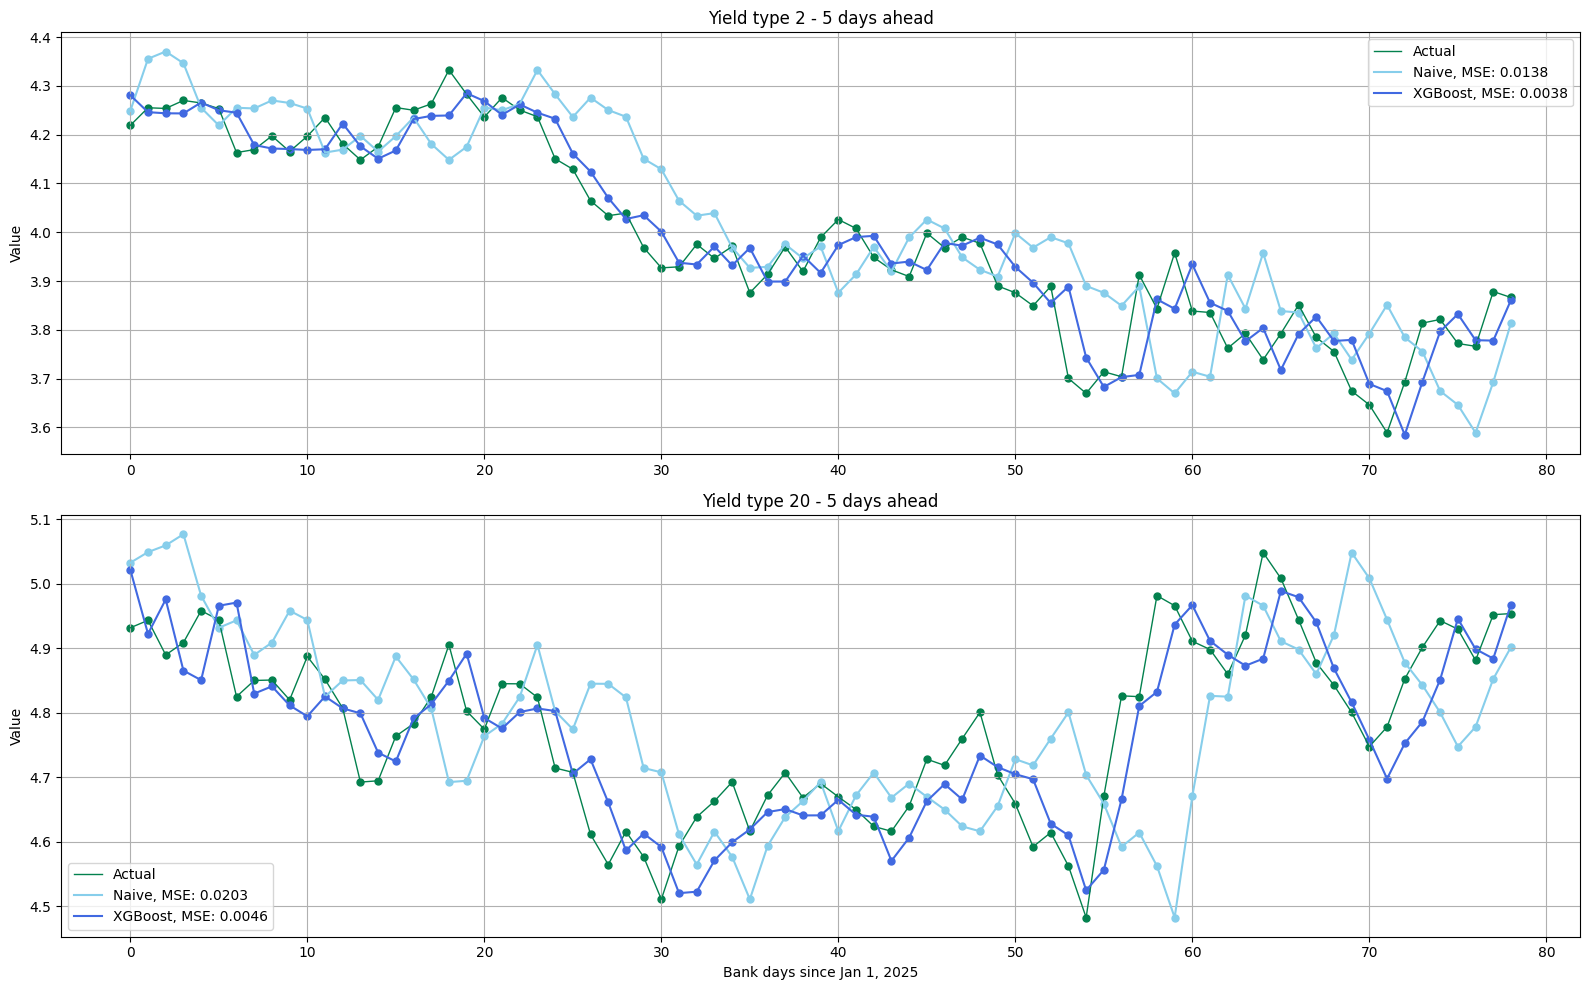

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

mse_xgb_2 = mean_squared_error(actual_2, xgb_pred_2)
mse_naive_2 = mean_squared_error(actual_2, naive_pred_2)

mse_xgb_20 = mean_squared_error(actual_20, xgb_pred_20)
mse_naive_20 = mean_squared_error(actual_20, naive_pred_20)

fig, axs = plt.subplots(2, 1, figsize=(16, 10), sharex=False)

x_2 = np.arange(len(actual_2))
axs[0].plot(x_2, actual_2, label='Actual', color="#03814E", linewidth=1)
axs[0].scatter(x_2, actual_2, color="#03814E", s=25)

axs[0].plot(x_2, naive_pred_2, label=f'Naive, MSE: {mse_naive_2:.4f}', color='skyblue')
axs[0].scatter(x_2, naive_pred_2, color='skyblue', s=25)

axs[0].plot(x_2, xgb_pred_2, label=f'XGBoost, MSE: {mse_xgb_2:.4f}', color='royalblue')
axs[0].scatter(x_2, xgb_pred_2, color='royalblue', s=25)

axs[0].set_title(f'Yield type 2 - 5 days ahead')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)


x_20 = np.arange(len(actual_20))
axs[1].plot(x_20, actual_20, label='Actual', color="#03814E", linewidth=1)
axs[1].scatter(x_20, actual_20, color="#03814E", s=25)

axs[1].plot(x_20, naive_pred_20, label=f'Naive, MSE: {mse_naive_20:.4f}', color='skyblue')
axs[1].scatter(x_20, naive_pred_20, color='skyblue', s=25)

axs[1].plot(x_20, xgb_pred_20, label=f'XGBoost, MSE: {mse_xgb_20:.4f}', color='royalblue')
axs[1].scatter(x_20, xgb_pred_20, color='royalblue', s=25)

axs[1].set_title(f'Yield type 20 - 5 days ahead')
axs[1].set_xlabel('Bank days since Jan 1, 2025')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Data for predicting stock prices and interest rates

## Importing and filtering

In [ ]:
import pandas as pd
data = pd.read_csv('../Final-Project-AppML/feds200628.csv', skiprows=9)

data['Date'] = pd.to_datetime(data['Date'])

data1 = data[data['Date'] >= '1985-01-02']

cols_to_keep = ['Date', 'BETA0', 'BETA1', 'BETA2']

sveny_cols = [col for col in data.columns if col.startswith('SVENY')]

all_keep_cols = cols_to_keep + sveny_cols

data2 = data1[all_keep_cols]

columns_to_drop = [f'SVENY{i}' for i in range(21, 31)]
data2 = data2.drop(columns=columns_to_drop, errors='ignore')

SP_500_historic = pd.read_csv('../Final-Project-AppML/SP_historic.csv', skiprows=2, header=0)

SP_500_historic['Date'] = pd.to_datetime(SP_500_historic['Date'])

SP_500_historic['Date'] = SP_500_historic['Date'].dt.strftime('%Y-%m-%d')

SP_500_historic.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

fed_interest = pd.read_csv('../Final-Project-AppML/FED_interest.csv')

data2['Date'] = pd.to_datetime(data2['Date'])
SP_500_historic['Date'] = pd.to_datetime(SP_500_historic['Date'])
fed_interest['Date'] = pd.to_datetime(fed_interest['Date'])

data_w_SP = pd.merge(data2, SP_500_historic, on='Date', how='left')

data_w_SP = pd.merge(data_w_SP, fed_interest, on='Date', how='left')

data_w_SP['Date'] = pd.to_datetime(data_w_SP['Date'])

data_w_SP = data_w_SP[data_w_SP['Date'] >= '1991-01-09']

data_w_SP = data_w_SP.loc[:, ~data_w_SP.columns.str.startswith('BETA')]
data_w_SP = data_w_SP.drop(columns='Target Rate (%)', errors='ignore')

for col in ['Notes', 'Rate Change (bps)']:
    if col in data_w_SP.columns:
        data_w_SP[col] = pd.to_numeric(data_w_SP[col], errors='coerce').astype('Int64') 

In [13]:
df = data_w_SP.dropna()

## Splitting the data

In [ ]:
import pandas as pd

df['Date'] = pd.to_datetime(df['Date'])

train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')

train_df = df[df['Date'] < train_end]
val_df = df[(df['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = df[df['Date'] >= val_end]

# Optionally check the sizes
print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")


Train set: 6722 rows
Validation set: 1748 rows
Test set: 88 rows


/var/folders/lj/7sv2y2pj44184gp5gwhj9d5w0000gn/T/ipykernel_97567/160201209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


# Predicting stock prices

## Making a XGboost models - Validation set

### Predicting with XGboost with time series

#### Predicting with all data

In [ ]:
df.head()

Date   SVENY01   SVENY02   SVENY03   SVENY04   SVENY05   SVENY06  \
1570 1991-01-09  6.841287  7.133531  7.389677  7.613145  7.807043  7.974199   
1571 1991-01-10  6.799324  7.089104  7.339749  7.555624  7.740626  7.898230   
1572 1991-01-11  6.773037  7.085764  7.351627  7.576813  7.766714  7.926027   
1573 1991-01-14  6.777678  7.110425  7.385916  7.613962  7.802602  7.958424   
1574 1991-01-15  6.752939  7.099241  7.371627  7.591270  7.772313  7.924163   

       SVENY07   SVENY08   SVENY09  ...   SVENY20       Close        High  \
1570  8.117182  8.238325  8.339752  ...  8.597437  311.489990  320.730011   
1571  8.031535  8.143304  8.236000  ...  8.481158  314.529999  314.769989   
1572  8.058841  8.168714  8.258740  ...  8.504820  315.230011  315.239990   
1573  8.086828  8.192242  8.278296  ...  8.520263  312.489990  315.230011   
1574  8.053062  8.163160  8.257241  ...  8.562148  313.730011  313.730011   

             Low        Open       Volume  FEDFUNDS  Notes  Rate Change (bps)  \
1570  310.929993  314.899994  191100000.0      6.91      0                -25   
1571  311.510010  311.510010  124510000.0      6.91      0                  0   
1572  313.589996  314.529999  123050000.0      6.91      0                  0   
1573  309.350006  315.230011  120830000.0      6.91      0                  0   
1574  311.839996  312.489990  110000000.0      6.91      0                  0   

      year  
1570  1991  
1571  1991  
1572  1991  
1573  1991  
1574  1991  

[5 rows x 30 columns]

In [ ]:
def add_date_features(df, date_col='Date'):
    df = df.copy()
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['weekday'] = df[date_col].dt.weekday
    df['dayofyear'] = df[date_col].dt.dayofyear
    return df

def prepare_lagged_data_with_date_features(train_df, val_df, target_col, lags=[1, 2, 3], date_col='Date'):
    def create_lags(df, target_col, lags):
        df = df.copy()
        for lag in lags:
            df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
        return df

    train_df = add_date_features(train_df, date_col)
    val_df = add_date_features(val_df, date_col)

    train_data = create_lags(train_df, target_col, lags)
    val_data = create_lags(val_df, target_col, lags)

    train_data = train_data.dropna()
    val_data = val_data.dropna()

    X_train = train_data.drop(columns=[target_col, date_col])
    y_train = train_data[target_col]

    X_val = val_data.drop(columns=[target_col, date_col])
    y_val = val_data[target_col]

    return X_train, y_train, X_val, y_val


target = 'Close'
X_train, y_train, X_val, y_val = prepare_lagged_data_with_date_features(train_df, val_df, target)



In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(y_val, y_pred)

mean_abs_actual = abs(y_val).mean()
relative_mae = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 1331.3236
Relative MAE: 0.3456
Time used by XGBoost: 191.0 ms


#### Feature importance

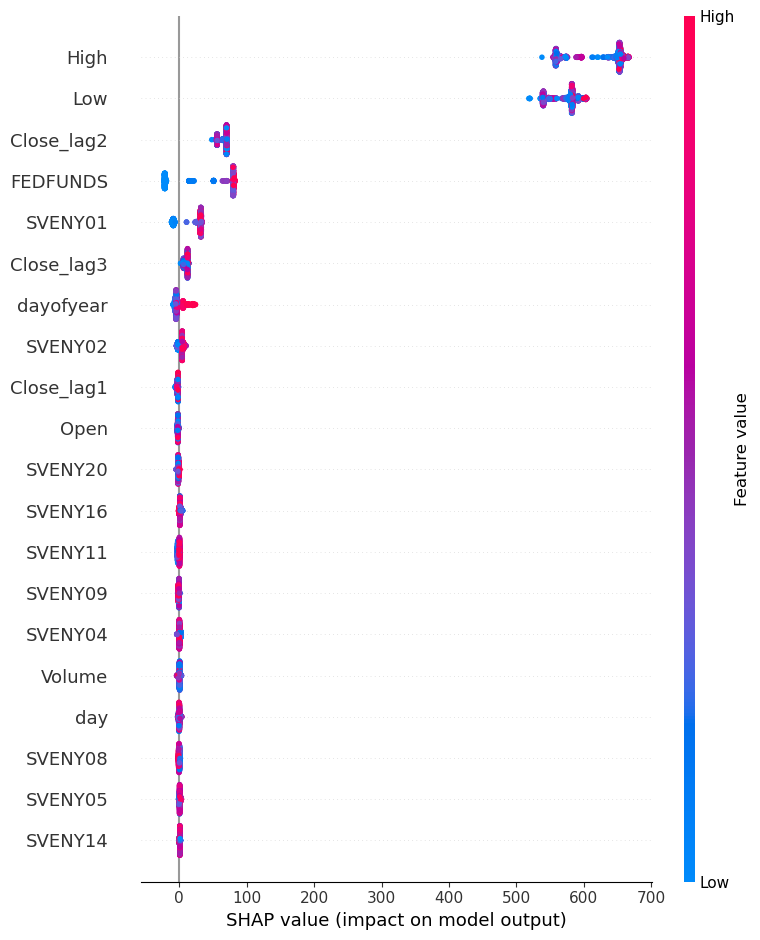

In [ ]:
import shap

explainer = shap.Explainer(xgb_model)

shap_values = explainer(X_val)

shap.summary_plot(shap_values, X_val)


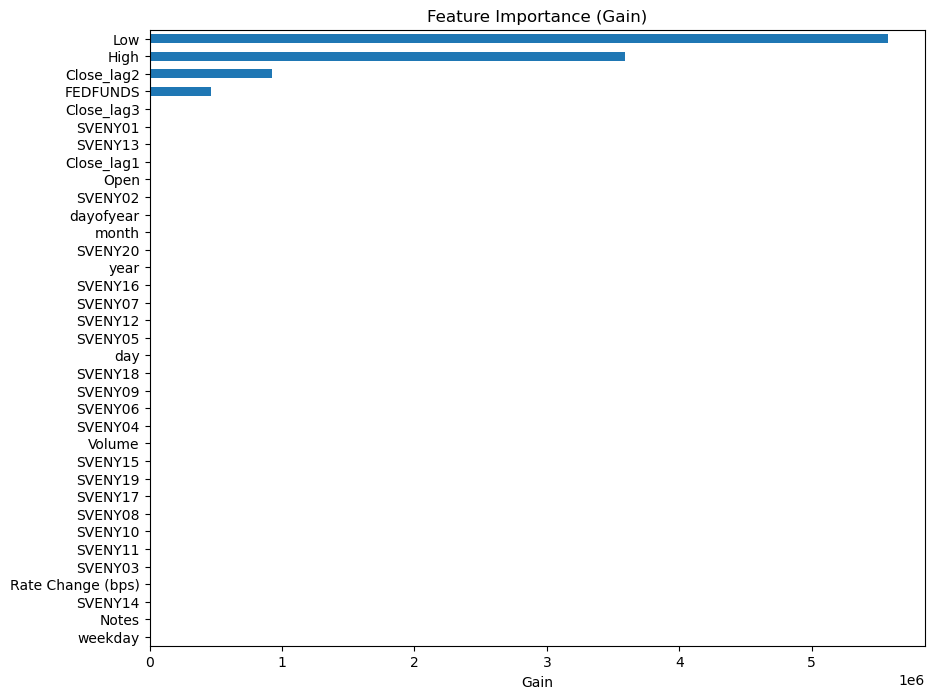

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

importance = xgb_model.get_score(importance_type='gain')

import pandas as pd
importance_series = pd.Series(importance).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importance_series.plot(kind='barh')
plt.xlabel('Gain')
plt.title('Feature Importance (Gain)')
plt.show()


#### Only predicting on ZCB data but with lags

In [ ]:
data_ZCB = df.drop(columns=['Open', 'High', 'Low', 'Volume'])

In [ ]:
import pandas as pd

data_ZCB['Date'] = pd.to_datetime(data_ZCB['Date'])

train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')

train_df = data_ZCB[data_ZCB['Date'] < train_end]
val_df = data_ZCB[(data_ZCB['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = data_ZCB[data_ZCB['Date'] >= val_end]

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 6722 rows
Validation set: 1748 rows
Test set: 88 rows


In [ ]:
def add_date_features(df, date_col='Date'):
    df = df.copy()
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['weekday'] = df[date_col].dt.weekday
    df['dayofyear'] = df[date_col].dt.dayofyear
    return df

def prepare_lagged_data_with_date_features(train_df, val_df, target_col, lags=[1, 2, 3], date_col='Date'):
    def create_lags(df, target_col, lags):
        df = df.copy()
        for lag in lags:
            df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
        return df

    train_df = add_date_features(train_df, date_col)
    val_df = add_date_features(val_df, date_col)

    train_data = create_lags(train_df, target_col, lags)
    val_data = create_lags(val_df, target_col, lags)

    train_data = train_data.dropna()
    val_data = val_data.dropna()

    X_train = train_data.drop(columns=[target_col, date_col])
    y_train = train_data[target_col]

    X_val = val_data.drop(columns=[target_col, date_col])
    y_val = val_data[target_col]

    return X_train, y_train, X_val, y_val

target = 'Close'
X_train, y_train, X_val, y_val = prepare_lagged_data_with_date_features(train_df, val_df, target)

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_ZCB = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(y_val, y_pred)

mean_abs_actual = abs(y_val).mean()
relative_mae_wo_stock = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 1331.3236
Relative MAE: 0.3456
Time used by XGBoost: 132.9 ms


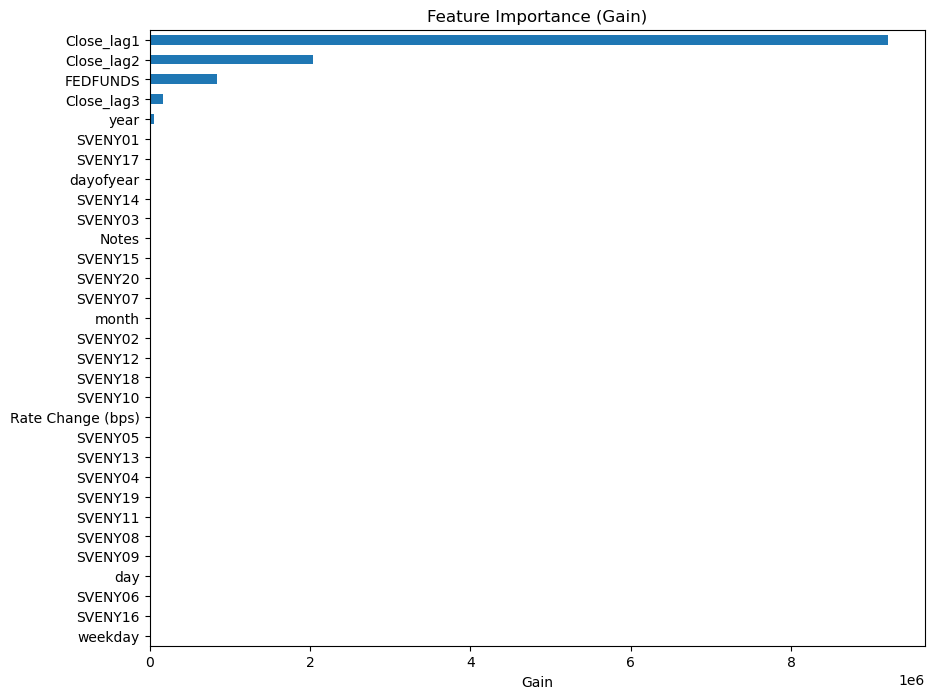

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importance scores by 'gain'
importance = xgb_model.get_score(importance_type='gain')

# Convert to pandas Series for easier plotting and sorting
import pandas as pd
importance_series = pd.Series(importance).sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 8))
importance_series.plot(kind='barh')
plt.xlabel('Gain')
plt.title('Feature Importance (Gain)')
plt.show()

#### Only predicting on stock but with lags

In [ ]:
data_stock = df[['Date', 'Open', 'High', 'Low', 'Volume', 'Close']]

In [ ]:
import pandas as pd

data_stock['Date'] = pd.to_datetime(data_stock['Date'])

train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')

train_df = data_stock[data_stock['Date'] < train_end]
val_df = data_stock[(data_stock['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = data_stock[data_stock['Date'] >= val_end]

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 6722 rows
Validation set: 1748 rows
Test set: 88 rows


/var/folders/lj/7sv2y2pj44184gp5gwhj9d5w0000gn/T/ipykernel_23476/2003686780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_stock['Date'] = pd.to_datetime(data_stock['Date'])


In [ ]:
def add_date_features(df, date_col='Date'):
    df = df.copy()
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['weekday'] = df[date_col].dt.weekday
    df['dayofyear'] = df[date_col].dt.dayofyear
    return df

def prepare_lagged_data_with_date_features(train_df, val_df, target_col, lags=[1, 2, 3], date_col='Date'):
    def create_lags(df, target_col, lags):
        df = df.copy()
        for lag in lags:
            df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
        return df

    train_df = add_date_features(train_df, date_col)
    val_df = add_date_features(val_df, date_col)

    train_data = create_lags(train_df, target_col, lags)
    val_data = create_lags(val_df, target_col, lags)

    train_data = train_data.dropna()
    val_data = val_data.dropna()

    X_train = train_data.drop(columns=[target_col, date_col])
    y_train = train_data[target_col]

    X_val = val_data.drop(columns=[target_col, date_col])
    y_val = val_data[target_col]

    return X_train, y_train, X_val, y_val


target = 'Close'
X_train, y_train, X_val, y_val = prepare_lagged_data_with_date_features(train_df, val_df, target)

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_stock = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(y_val, y_pred)

mean_abs_actual = abs(y_val).mean()
relative_mae_stock = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 1331.3236
Relative MAE: 0.3456
Time used by XGBoost: 163.1 ms


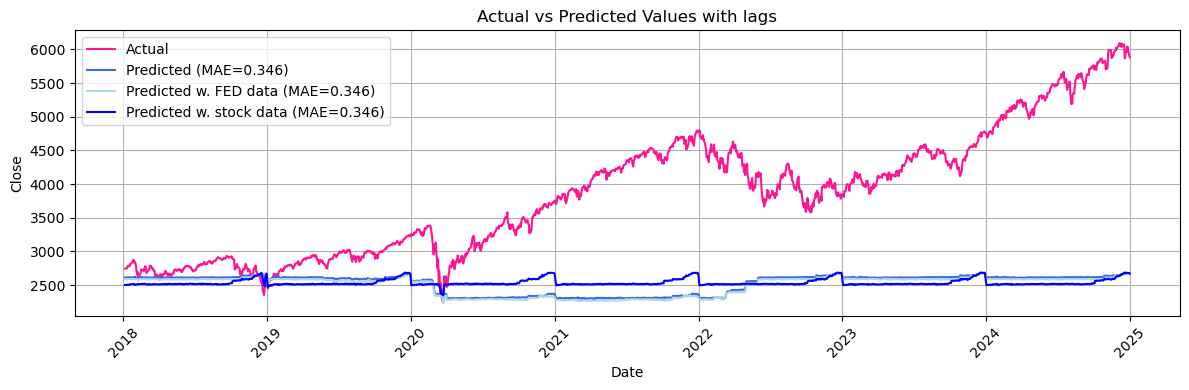

In [ ]:
import matplotlib.pyplot as plt

dates = val_df.loc[y_val.index, 'Date']

plt.figure(figsize=(12, 4))
plt.plot(dates, y_val, label='Actual', color='deeppink')
plt.plot(dates, y_pred, label=f'Predicted (MAE={relative_mae:.3f})', color='royalblue')
plt.plot(dates, y_pred_ZCB, label=f'Predicted w. FED data (MAE={relative_mae_wo_stock:.3f})', color='lightblue')
plt.plot(dates, y_pred_stock, label=f'Predicted w. stock data (MAE={relative_mae_stock:.3f})', color='blue')

plt.xlabel('Date')
plt.ylabel(target)  # Assuming 'target' is defined elsewhere
plt.title('Actual vs Predicted Values with lags')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



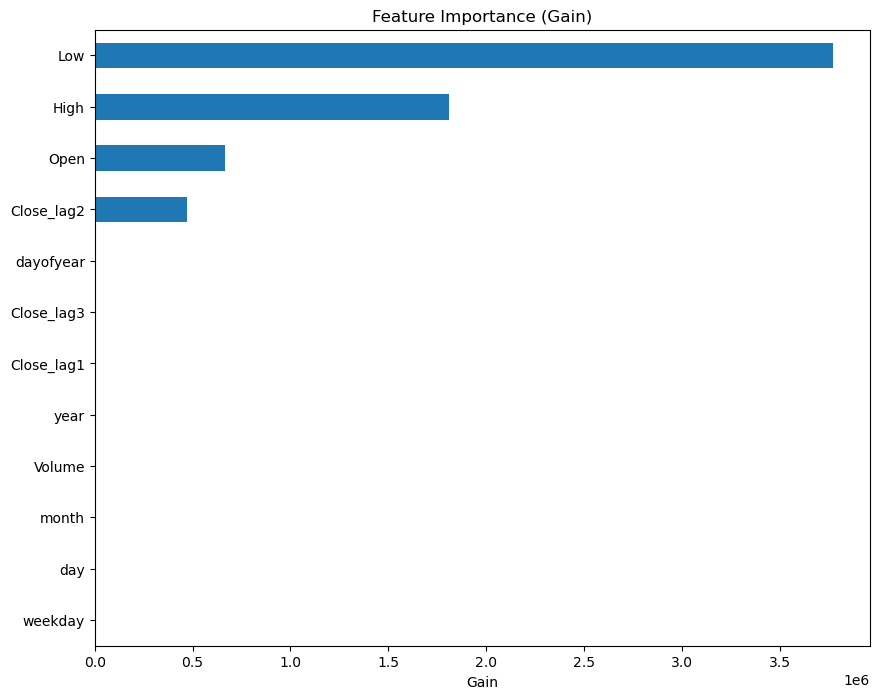

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

importance = xgb_model.get_score(importance_type='gain')

import pandas as pd
importance_series = pd.Series(importance).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importance_series.plot(kind='barh')
plt.xlabel('Gain')
plt.title('Feature Importance (Gain)')
plt.show()

### Predicting with XGboost

In [ ]:
import pandas as pd

df['Date'] = pd.to_datetime(df['Date'])

train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')

train_df = df[df['Date'] < train_end]
val_df = df[(df['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = df[df['Date'] >= val_end]

print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 6722 rows
Validation set: 1748 rows
Test set: 88 rows


#### Predicting with stock data

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

target = 'Close'

start = time.time()

train_data_clean = train_df.dropna()
val_data_clean = val_df.dropna()

X_train = train_data_clean.drop(columns=[target, 'Date'])
y_train = train_data_clean[target]

X_val = val_data_clean.drop(columns=[target, 'Date'])
y_val = val_data_clean[target]

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(y_val, y_pred)
relative_mae = mae / abs(y_val).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")



Mean Absolute Error: 1292.4242
Relative MAE: 0.3357
Time used by XGBoost: 263.1 ms


#### Predicting without stock data

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

train_data_clean = train_df.dropna()
val_data_clean = val_df.dropna()

cols_to_drop = [target, 'Date', 'Open', 'High', 'Low', 'Volume']

X_train = train_data_clean.drop(columns=cols_to_drop)
y_train = train_data_clean[target]

X_val = val_data_clean.drop(columns=cols_to_drop)
y_val = val_data_clean[target]

start = time.time()

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_ZCB = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(y_val, y_pred_ZCB)
relative_mae_wo_stock = mae / abs(y_val).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 1429.8386
Relative MAE: 0.3357
Time used by XGBoost: 107.3 ms


#### Predicting only stock data

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

train_data_clean = train_df.dropna()
val_data_clean = val_df.dropna()

feature_cols = ['Open', 'High', 'Low', 'Volume']

X_train = train_data_clean[feature_cols]
y_train = train_data_clean[target]

X_val = val_data_clean[feature_cols]
y_val = val_data_clean[target]

start = time.time()

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_stock = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(y_val, y_pred_stock)
relative_mae_stock = mae / abs(y_val).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 1203.7324
Relative MAE: 0.3357
Time used by XGBoost: 76.3 ms


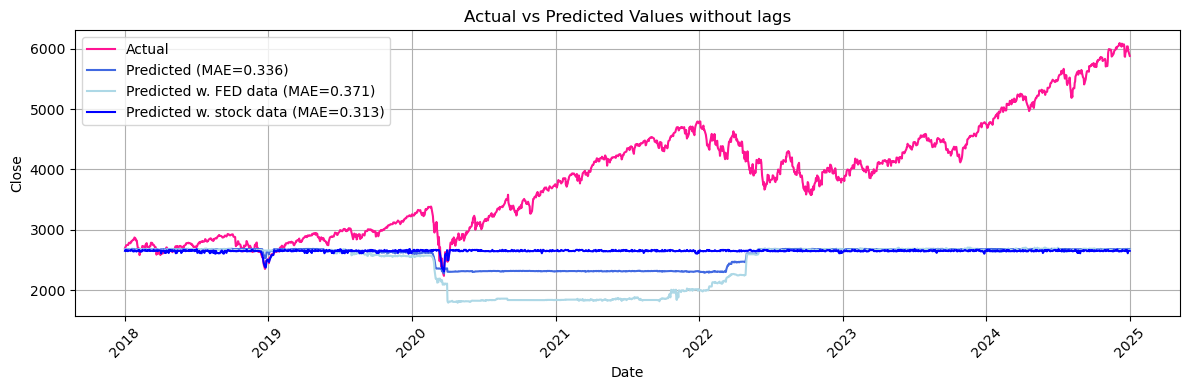

In [ ]:
import matplotlib.pyplot as plt

y_pred_stock = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))

plt.figure(figsize=(12, 4))
plt.plot(val_data_clean['Date'], y_val, label='Actual', color='deeppink')
plt.plot(val_data_clean['Date'], y_pred, label=f'Predicted (MAE={relative_mae:.3f})', color='royalblue')
plt.plot(val_data_clean['Date'], y_pred_ZCB, label=f'Predicted w. FED data (MAE={relative_mae_wo_stock:.3f})', color='lightblue')
plt.plot(val_data_clean['Date'], y_pred_stock, label=f'Predicted w. stock data (MAE={relative_mae_stock:.3f})', color='blue')

plt.xlabel('Date')
plt.ylabel(target)
plt.title('Actual vs Predicted Values without lags')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Predicting using an expanding window

### Predicting using a time window using all features

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

target = 'Close'
start_train_year = 2000
end_val_year = 2025 

df = df.sort_values('Date').copy()
df['year'] = df['Date'].dt.year

results = []

for val_year in range(start_train_year + 1, end_val_year + 1):
    print(f"\n🔁 Training up to {val_year - 1}, validating on {val_year}")

    train_data = df[df['year'] < val_year]
    val_data = df[df['year'] == val_year]

    if val_data.empty:
        print(f"⚠️ No validation data for {val_year}")
        continue

    X_train = train_data.drop(columns=[target, 'Date', 'year'])
    y_train = train_data[target]
    X_val = val_data.drop(columns=[target, 'Date', 'year'])
    y_val = val_data[target]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'verbosity': 0
    }

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dvalid, 'val')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    y_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))

    mae = mean_absolute_error(y_val, y_pred)
    rel_mae = mae / abs(y_val.mean())
    results.append({
        'Validation Year': val_year,
        'MAE': mae,
        'Relative MAE': rel_mae
    })
    print(f"✅ MAE: {mae:.4f}, Relative MAE: {rel_mae:.4f}")

cv_results = pd.DataFrame(results)
print("\n📊 Cross-Validation Summary:")
print(cv_results)



🔁 Training up to 2000, validating on 2001
✅ MAE: 9.0085, Relative MAE: 0.0075

🔁 Training up to 2001, validating on 2002
✅ MAE: 8.9977, Relative MAE: 0.0090

🔁 Training up to 2002, validating on 2003
✅ MAE: 8.1686, Relative MAE: 0.0085

🔁 Training up to 2003, validating on 2004
✅ MAE: 4.2623, Relative MAE: 0.0038

🔁 Training up to 2004, validating on 2005
✅ MAE: 5.3569, Relative MAE: 0.0044

🔁 Training up to 2005, validating on 2006
✅ MAE: 6.6739, Relative MAE: 0.0051

🔁 Training up to 2006, validating on 2007
✅ MAE: 12.9979, Relative MAE: 0.0088

🔁 Training up to 2007, validating on 2008
✅ MAE: 10.8117, Relative MAE: 0.0088

🔁 Training up to 2008, validating on 2009
✅ MAE: 7.2828, Relative MAE: 0.0077

🔁 Training up to 2009, validating on 2010
✅ MAE: 7.5074, Relative MAE: 0.0066

🔁 Training up to 2010, validating on 2011
✅ MAE: 12.9215, Relative MAE: 0.0102

🔁 Training up to 2011, validating on 2012
✅ MAE: 5.6348, Relative MAE: 0.0041

🔁 Training up to 2012, validating on 2013
✅ MAE:

In [ ]:

print("\n📊 Cross-Validation Summary (sorted by year):")
print(cv_results.to_string(index=False))



📊 Cross-Validation Summary (sorted by year):
 Validation Year        MAE  Relative MAE
            2001   9.008517      0.007538
            2002   8.997678      0.009043
            2003   8.168606      0.008469
            2004   4.262258      0.003770
            2005   5.356858      0.004437
            2006   6.673918      0.005093
            2007  12.997901      0.008800
            2008  10.811740      0.008837
            2009   7.282839      0.007691
            2010   7.507383      0.006588
            2011  12.921546      0.010191
            2012   5.634759      0.004086
            2013 119.281513      0.072599
            2014 119.810708      0.062040
            2015  29.513303      0.014319
            2016  39.444598      0.018836
            2017 238.159892      0.097226
            2018  94.853576      0.034546
            2019  73.860869      0.025360
            2020 311.644307      0.096929
            2021 596.718559      0.139697
            2022  87.818681   

### Predicting using a time window using stock features

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

target = 'Close'
features = ['High', 'Low', 'Open', 'Volume']
start_train_year = 2000
end_val_year = 2025 

df = df.sort_values('Date').copy()
df['year'] = df['Date'].dt.year

results = []

for val_year in range(start_train_year + 1, end_val_year + 1):
    print(f"\n🔁 Training up to {val_year - 1}, validating on {val_year}")

    train_data = df[df['year'] < val_year]
    val_data = df[df['year'] == val_year]

    if val_data.empty:
        print(f"⚠️ No validation data for {val_year}")
        continue

    X_train = train_data[features]
    y_train = train_data[target]
    X_val = val_data[features]
    y_val = val_data[target]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'verbosity': 0
    }

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dvalid, 'val')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    y_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))

    mae = mean_absolute_error(y_val, y_pred)
    rel_mae = mae / abs(y_val.mean())
    results.append({
        'Validation Year': val_year,
        'MAE': mae,
        'Relative MAE': rel_mae
    })
    print(f"✅ MAE: {mae:.4f}, Relative MAE: {rel_mae:.4f}")

cv_result_stock = pd.DataFrame(results)
print("\n📊 Cross-Validation Summary:")
print(cv_result_stock)



🔁 Training up to 2000, validating on 2001
✅ MAE: 9.1709, Relative MAE: 0.0077

🔁 Training up to 2001, validating on 2002
✅ MAE: 8.6610, Relative MAE: 0.0087

🔁 Training up to 2002, validating on 2003
✅ MAE: 5.4016, Relative MAE: 0.0056

🔁 Training up to 2003, validating on 2004
✅ MAE: 4.1486, Relative MAE: 0.0037

🔁 Training up to 2004, validating on 2005
✅ MAE: 5.2737, Relative MAE: 0.0044

🔁 Training up to 2005, validating on 2006
✅ MAE: 6.0672, Relative MAE: 0.0046

🔁 Training up to 2006, validating on 2007
✅ MAE: 9.2904, Relative MAE: 0.0063

🔁 Training up to 2007, validating on 2008
✅ MAE: 10.5677, Relative MAE: 0.0086

🔁 Training up to 2008, validating on 2009
✅ MAE: 6.4786, Relative MAE: 0.0068

🔁 Training up to 2009, validating on 2010
✅ MAE: 4.6829, Relative MAE: 0.0041

🔁 Training up to 2010, validating on 2011
✅ MAE: 5.4420, Relative MAE: 0.0043

🔁 Training up to 2011, validating on 2012
✅ MAE: 4.1659, Relative MAE: 0.0030

🔁 Training up to 2012, validating on 2013
✅ MAE: 1

In [ ]:

print("\n📊 Cross-Validation Summary (sorted by year):")
print(cv_result_stock.to_string(index=False))



📊 Cross-Validation Summary (sorted by year):
 Validation Year        MAE  Relative MAE
            2001   9.170886      0.007674
            2002   8.661017      0.008704
            2003   5.401616      0.005600
            2004   4.148603      0.003670
            2005   5.273700      0.004369
            2006   6.067173      0.004630
            2007   9.290449      0.006290
            2008  10.567721      0.008637
            2009   6.478553      0.006842
            2010   4.682944      0.004109
            2011   5.442037      0.004292
            2012   4.165873      0.003021
            2013 103.844098      0.063203
            2014 123.491721      0.063947
            2015  22.544793      0.010938
            2016  33.423914      0.015961
            2017 213.278972      0.087069
            2018 111.348531      0.040553
            2019  68.424555      0.023494
            2020 171.720537      0.053409
            2021 582.592014      0.136390
            2022  44.673202   

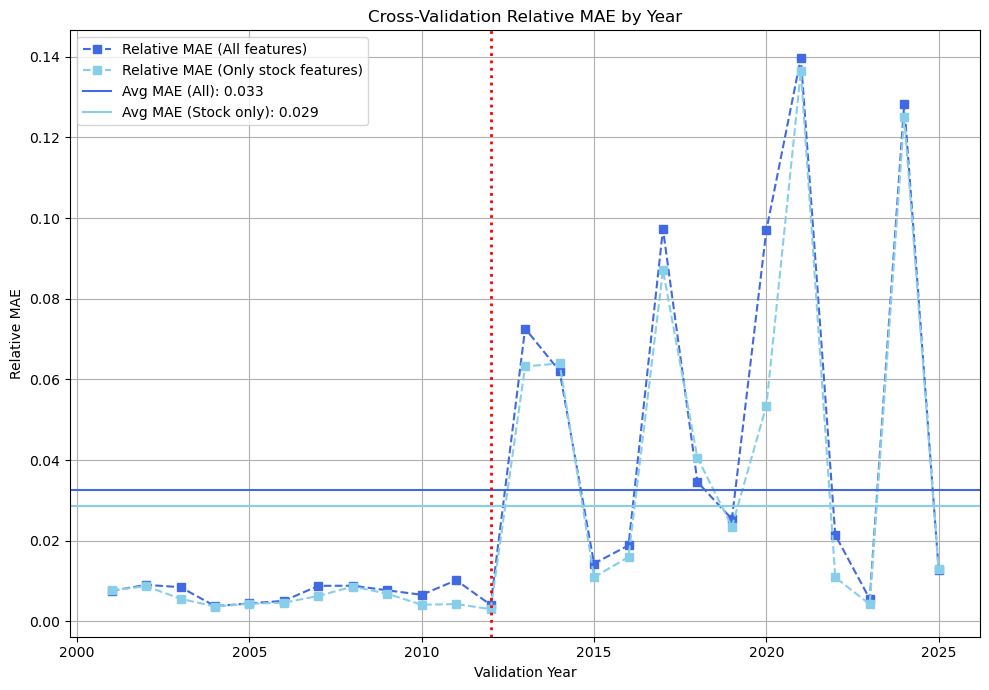

In [ ]:
import matplotlib.pyplot as plt

cv_results_sorted = cv_results.sort_values(by='Validation Year')
cv_results_stock_sorted = cv_result_stock.sort_values(by='Validation Year')

avg_mae = cv_results_sorted['Relative MAE'].mean()
avg_mae_stock = cv_results_stock_sorted['Relative MAE'].mean()


plt.figure(figsize=(10, 7))

plt.plot(cv_results_sorted['Validation Year'], cv_results_sorted['Relative MAE'], 
         marker='s', linestyle='--', color='royalblue', label='Relative MAE (All features)')
plt.plot(cv_results_stock_sorted['Validation Year'], cv_results_stock_sorted['Relative MAE'], 
         marker='s', linestyle='--', color='skyblue', label='Relative MAE (Only stock features)')

plt.axhline(avg_mae, color='royalblue', linestyle='-', linewidth=1.5, label=f'Avg MAE (All): {avg_mae:.3f}')
plt.axhline(avg_mae_stock, color='skyblue', linestyle='-', linewidth=1.5, label=f'Avg MAE (Stock only): {avg_mae_stock:.3f}')

plt.axvline(2012, color='red', linestyle=':', linewidth=2)

plt.xlabel('Validation Year')
plt.ylabel('Relative MAE')
plt.title('Cross-Validation Relative MAE by Year')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Random search

In [ ]:
# import pandas as pd
# import numpy as np
# import xgboost as xgb
# from sklearn.metrics import mean_absolute_error
# import random

# # --- Configuration ---
# target = 'Close'
# features = ['High', 'Low', 'Open', 'Volume']
# start_train_year = 2000
# end_val_year = 2024  # inclusive
# n_iterations = 30  # number of random parameter sets to try

# # Ensure data is sorted
# df = df.sort_values('Date').copy()
# df['year'] = df['Date'].dt.year

# import random

# # Continuous hyperparameter ranges
# param_grid = {
#     'max_depth': (3, 10),              # integer
#     'learning_rate': (0.01, 0.3),      # float
#     'subsample': (0.6, 1.0),           # float
#     'colsample_bytree': (0.6, 1.0)     # float
# }

# # Randomly sample from the continuous space
# def sample_params(grid):
#     return {
#         'max_depth': random.randint(*grid['max_depth']),
#         'learning_rate': round(random.uniform(*grid['learning_rate']), 4),
#         'subsample': round(random.uniform(*grid['subsample']), 4),
#         'colsample_bytree': round(random.uniform(*grid['colsample_bytree']), 4)
#     }

# # --- Optimization Loop ---
# best_score = float('inf')
# best_params = None
# all_results = []

# for i in range(n_iterations):
#     print(f"\n Trial {i + 1}/{n_iterations}")
#     params = sample_params(param_grid)
#     rel_maes = []

#     for val_year in range(start_train_year + 1, end_val_year + 1):
#         train_data = df[df['year'] < val_year]
#         val_data = df[df['year'] == val_year]

#         if val_data.empty:
#             continue

#         X_train = train_data[features]
#         y_train = train_data[target]
#         X_val = val_data[features]
#         y_val = val_data[target]

#         dtrain = xgb.DMatrix(X_train, label=y_train)
#         dvalid = xgb.DMatrix(X_val, label=y_val)

#         full_params = {
#             'booster': 'gbtree',
#             'objective': 'reg:squarederror',
#             'eval_metric': 'mae',
#             'verbosity': 0,
#             **params
#         }

#         model = xgb.train(
#             params=full_params,
#             dtrain=dtrain,
#             num_boost_round=1000,
#             evals=[(dtrain, 'train'), (dvalid, 'val')],
#             early_stopping_rounds=20,
#             verbose_eval=False
#         )

#         y_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
#         mae = mean_absolute_error(y_val, y_pred)
#         rel_mae = mae / abs(y_val.mean())
#         rel_maes.append(rel_mae)

#     avg_rel_mae = np.mean(rel_maes)
#     print(f" Avg Relative MAE: {avg_rel_mae:.4f} with params: {params}")

#     all_results.append({
#         'params': params,
#         'avg_relative_mae': avg_rel_mae
#     })

#     if avg_rel_mae < best_score:
#         best_score = avg_rel_mae
#         best_params = params

# # --- Results ---
# print("\n Best Parameters Found:")
# print(best_params)
# print(f"With Avg Relative MAE: {best_score:.4f}")

# # Optional: Convert all results to a DataFrame
# results_df = pd.DataFrame([{
#     **r['params'],
#     'avg_relative_mae': r['avg_relative_mae']
# } for r in all_results])


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

target = 'Close'
features = ['High', 'Low', 'Open', 'Volume']
start_train_year = 2000
end_val_year = 2025  

optimal_params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0,
    'max_depth': 5,
    'learning_rate': 0.1478,
    'subsample': 0.6858,
    'colsample_bytree': 0.8885
}

df = df.sort_values('Date').copy()
df['year'] = df['Date'].dt.year

results = []

for val_year in range(start_train_year + 1, end_val_year + 1):
    print(f"\n🔁 Training up to {val_year - 1}, validating on {val_year}")

    train_data = df[df['year'] < val_year]
    val_data = df[df['year'] == val_year]

    if val_data.empty:
        print(f"⚠️ No validation data for {val_year}")
        continue

    X_train = train_data[features]
    y_train = train_data[target]
    X_val = val_data[features]
    y_val = val_data[target]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(
        params=optimal_params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dvalid, 'val')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    y_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))

    mae = mean_absolute_error(y_val, y_pred)
    rel_mae = mae / abs(y_val.mean())
    results.append({
        'Validation Year': val_year,
        'MAE': mae,
        'Relative MAE': rel_mae
    })
    print(f"✅ MAE: {mae:.4f}, Relative MAE: {rel_mae:.4f}")

cv_result_optimal = pd.DataFrame(results)
print("\n📊 Cross-Validation Summary:")
print(cv_result_optimal)



🔁 Training up to 2000, validating on 2001
✅ MAE: 8.6519, Relative MAE: 0.0072

🔁 Training up to 2001, validating on 2002
✅ MAE: 8.0764, Relative MAE: 0.0081

🔁 Training up to 2002, validating on 2003
✅ MAE: 5.0260, Relative MAE: 0.0052

🔁 Training up to 2003, validating on 2004
✅ MAE: 3.8854, Relative MAE: 0.0034

🔁 Training up to 2004, validating on 2005
✅ MAE: 4.1435, Relative MAE: 0.0034

🔁 Training up to 2005, validating on 2006
✅ MAE: 4.6513, Relative MAE: 0.0035

🔁 Training up to 2006, validating on 2007
✅ MAE: 10.2947, Relative MAE: 0.0070

🔁 Training up to 2007, validating on 2008
✅ MAE: 10.2786, Relative MAE: 0.0084

🔁 Training up to 2008, validating on 2009
✅ MAE: 7.9936, Relative MAE: 0.0084

🔁 Training up to 2009, validating on 2010
✅ MAE: 4.8881, Relative MAE: 0.0043

🔁 Training up to 2010, validating on 2011
✅ MAE: 5.8286, Relative MAE: 0.0046

🔁 Training up to 2011, validating on 2012
✅ MAE: 4.1493, Relative MAE: 0.0030

🔁 Training up to 2012, validating on 2013
✅ MAE: 

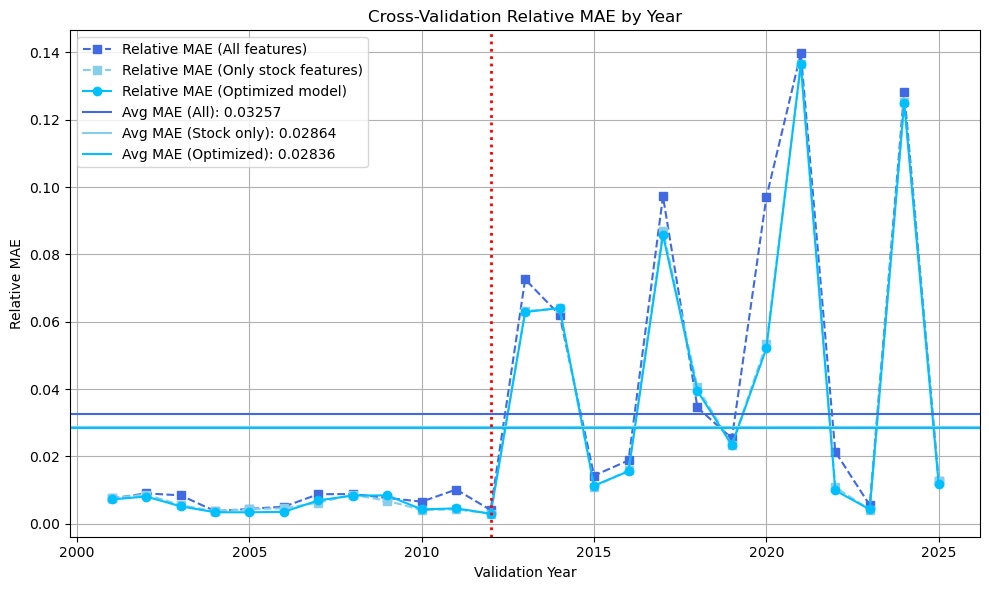

In [ ]:
import matplotlib.pyplot as plt

cv_results_sorted = cv_results.sort_values(by='Validation Year')
cv_results_stock_sorted = cv_result_stock.sort_values(by='Validation Year')
cv_result_optimal_sorted = cv_result_optimal.sort_values(by='Validation Year')  

avg_mae = cv_results_sorted['Relative MAE'].mean()
avg_mae_stock = cv_results_stock_sorted['Relative MAE'].mean()
avg_mae_optimal = cv_result_optimal_sorted['Relative MAE'].mean()

plt.figure(figsize=(10, 6))

plt.plot(cv_results_sorted['Validation Year'], cv_results_sorted['Relative MAE'], 
         marker='s', linestyle='--', color='royalblue', label='Relative MAE (All features)')
plt.plot(cv_results_stock_sorted['Validation Year'], cv_results_stock_sorted['Relative MAE'], 
         marker='s', linestyle='--', color='skyblue', label='Relative MAE (Only stock features)')
plt.plot(cv_result_optimal_sorted['Validation Year'], cv_result_optimal_sorted['Relative MAE'], 
         marker='o', linestyle='-', color='deepskyblue', label='Relative MAE (Optimized model)')

plt.axhline(avg_mae, color='royalblue', linestyle='-', linewidth=1.5, label=f'Avg MAE (All): {avg_mae:.5f}')
plt.axhline(avg_mae_stock, color='skyblue', linestyle='-', linewidth=1.5, label=f'Avg MAE (Stock only): {avg_mae_stock:.5f}')
plt.axhline(avg_mae_optimal, color='deepskyblue', linestyle='-', linewidth=1.5, label=f'Avg MAE (Optimized): {avg_mae_optimal:.5f}')

plt.axvline(2012, color='red', linestyle=':', linewidth=2)

plt.xlabel('Validation Year')
plt.ylabel('Relative MAE')
plt.title('Cross-Validation Relative MAE by Year')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Researching variance

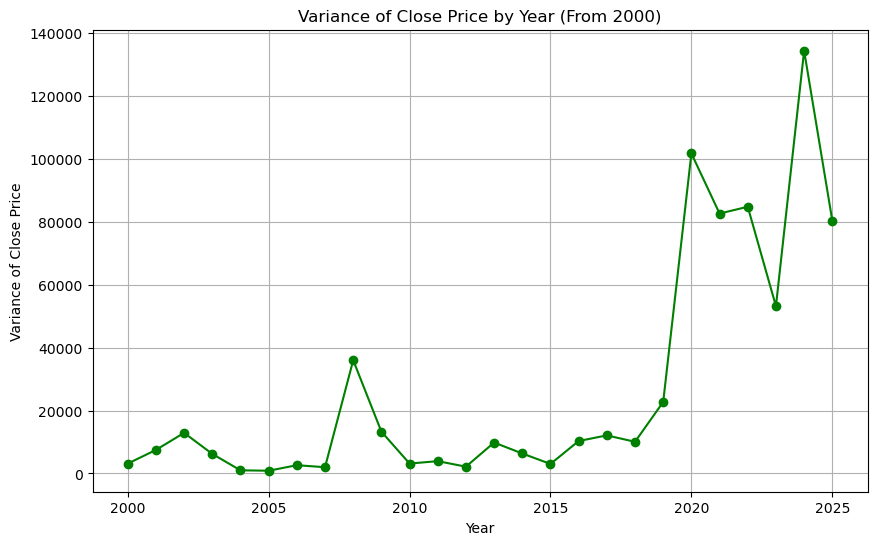

In [ ]:
import matplotlib.pyplot as plt

# Calculate variance of Close price for each year
var_close = df.groupby('year')['Close'].var().reset_index()

# Filter to years >= 2000
var_close_filtered = var_close[var_close['year'] >= 2000]

# Plot variance over the years from 2000 onward
plt.figure(figsize=(10, 6))
plt.plot(var_close_filtered['year'], var_close_filtered['Close'], marker='o', linestyle='-', color='green')
plt.xlabel('Year')
plt.ylabel('Variance of Close Price')
plt.title('Variance of Close Price by Year (From 2000)')
plt.grid(True)
plt.show()

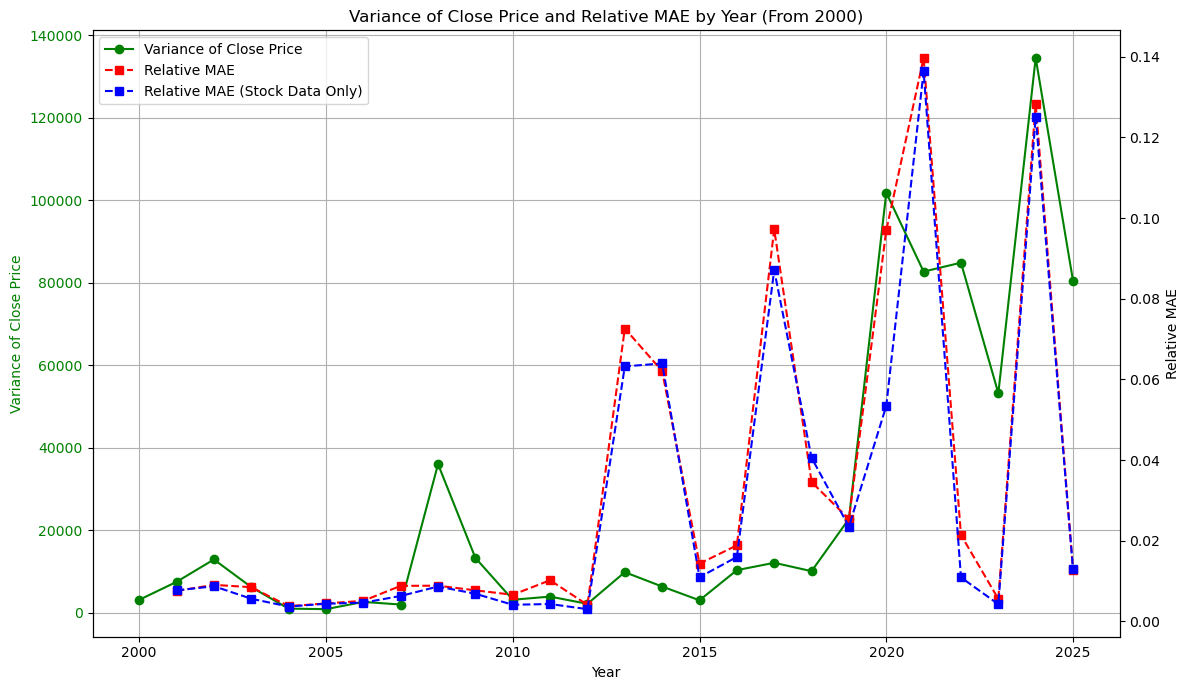

In [ ]:
import matplotlib.pyplot as plt

# Filter data from year 2000 onwards
var_close_filtered = var_close[var_close['year'] >= 2000]
cv_results_sorted_filtered = cv_results[cv_results['Validation Year'] >= 2000].sort_values(by='Validation Year')
cv_results_stock_sorted_filtered = cv_result_stock[cv_result_stock['Validation Year'] >= 2000].sort_values(by='Validation Year')

fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot variance of Close price on primary y-axis
ax1.plot(var_close_filtered['year'], var_close_filtered['Close'], marker='o', color='green', label='Variance of Close Price')
ax1.set_xlabel('Year')
ax1.set_ylabel('Variance of Close Price', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True)

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot Relative MAE on secondary y-axis
ax2.plot(cv_results_sorted_filtered['Validation Year'], cv_results_sorted_filtered['Relative MAE'], 
         marker='s', linestyle='--', color='red', label='Relative MAE')
ax2.plot(cv_results_stock_sorted_filtered['Validation Year'], cv_results_stock_sorted_filtered['Relative MAE'], 
         marker='s', linestyle='--', color='blue', label='Relative MAE (Stock Data Only)')
ax2.set_ylabel('Relative MAE', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Variance of Close Price and Relative MAE by Year (From 2000)')
plt.tight_layout()
plt.show()



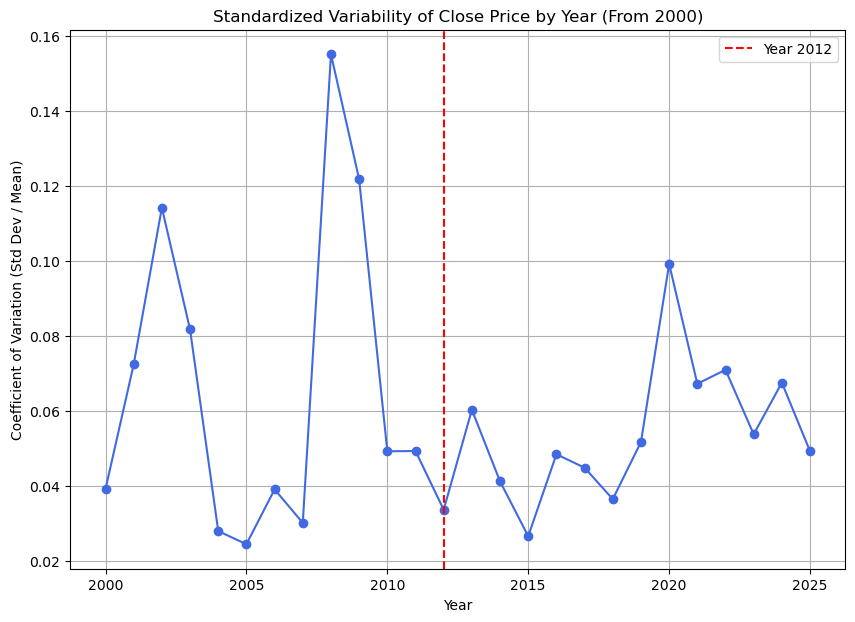

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and variance of Close price for each year
stats = df.groupby('year')['Close'].agg(['mean', 'var']).reset_index()

# Filter to years >= 2000
stats_filtered = stats[stats['year'] >= 2000].copy()

# Calculate Coefficient of Variation = std dev / mean
stats_filtered['cv'] = np.sqrt(stats_filtered['var']) / stats_filtered['mean']

# Plot CV over the years from 2000 onward
plt.figure(figsize=(10, 7))
plt.plot(stats_filtered['year'], stats_filtered['cv'], marker='o', linestyle='-', color='royalblue')  # changed to blue
plt.axvline(x=2012, color='red', linestyle='--', label='Year 2012')  # added vertical line
plt.xlabel('Year')
plt.ylabel('Coefficient of Variation (Std Dev / Mean)')
plt.title('Standardized Variability of Close Price by Year (From 2000)')
plt.grid(True)
plt.legend()
plt.show()


## Making a XGboost models - Test set (2025)

### Predicting with XGboost with time series

#### Predicting on all data

In [ ]:
split_date = pd.Timestamp('2025-01-01')

train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]


In [ ]:
def create_lags(df, target_col, lags=[1,2,3]):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df

train_data = create_lags(train_data, target)
test_data = create_lags(test_data, target)

train_data = train_data.dropna()
test_data = test_data.dropna()

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]
X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]


In [ ]:
def add_date_features(df):
    df = df.copy()
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['weekday'] = df['Date'].dt.weekday
    df['dayofyear'] = df['Date'].dt.dayofyear
    return df

train_data = add_date_features(train_data)
test_data = add_date_features(test_data)

X_train = train_data.drop(columns=[target, 'Date'])
X_test = test_data.drop(columns=[target, 'Date'])


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred)

mean_abs_actual = abs(Y_test).mean()
relative_mae = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 140.6899
Relative MAE: 0.0245
Time used by XGBoost: 250.2 ms


#### Feature importance

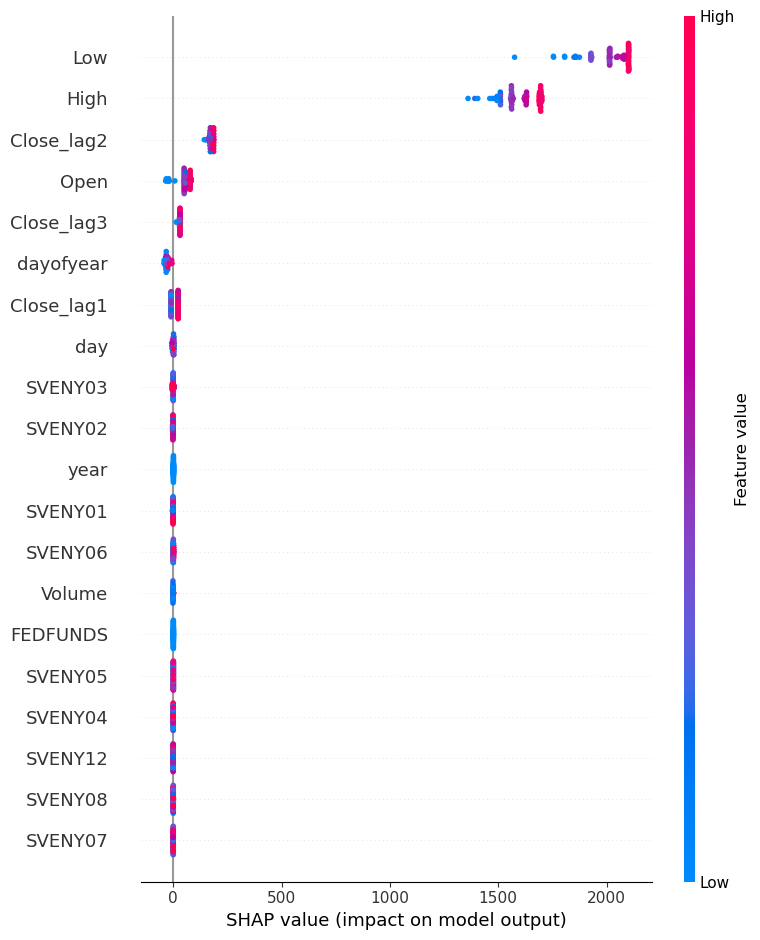

In [ ]:
import shap

explainer = shap.Explainer(xgb_model)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


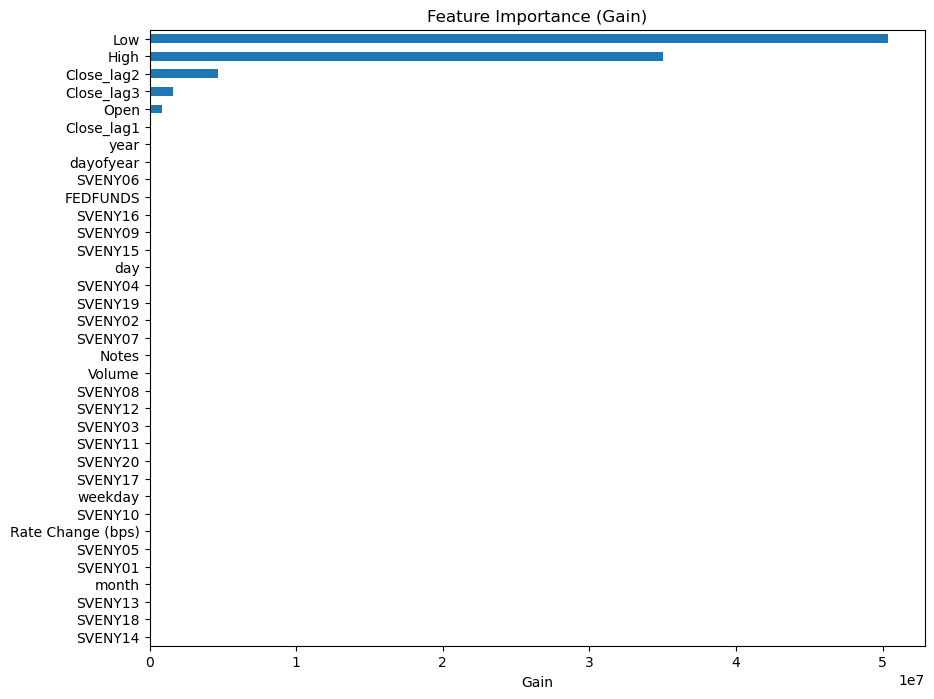

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

importance = xgb_model.get_score(importance_type='gain')

import pandas as pd
importance_series = pd.Series(importance).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importance_series.plot(kind='barh')
plt.xlabel('Gain')
plt.title('Feature Importance (Gain)')
plt.show()


#### Only predicting on ZCB data but with lags

In [ ]:
data_ZCB = df.drop(columns=['Open', 'High', 'Low', 'Volume'])

In [ ]:
split_date = pd.Timestamp('2025-01-01')

train_data = data_ZCB[data_ZCB['Date'] < split_date]
test_data = data_ZCB[data_ZCB['Date'] >= split_date]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]


In [ ]:
def create_lags(df, target_col, lags=[1,2,3]):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df

train_data = create_lags(train_data, target)
test_data = create_lags(test_data, target)

train_data = train_data.dropna()
test_data = test_data.dropna()

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]
X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_ZCB = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred_ZCB)

mean_abs_actual = abs(Y_test).mean()
relative_mae_wo_stock = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 96.8515
Relative MAE: 0.0245
Time used by XGBoost: 86.1 ms


#### Only predicting on stock data but with lags

In [ ]:
data_stock = df[['Date', 'Close', 'High', 'Low', 'Volume', 'Open']]

In [ ]:

split_date = pd.Timestamp('2025-01-01')

train_data = data_stock[data_stock['Date'] < split_date]
test_data = data_stock[data_stock['Date'] >= split_date]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]


In [ ]:
def create_lags(df, target_col, lags=[1,2,3]):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df

train_data = create_lags(train_data, target)
test_data = create_lags(test_data, target)

train_data = train_data.dropna()
test_data = test_data.dropna()

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]
X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_stock = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred_stock)

mean_abs_actual = abs(Y_test).mean()
relative_mae_stock = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 73.1933
Relative MAE: 0.0245
Time used by XGBoost: 162.9 ms


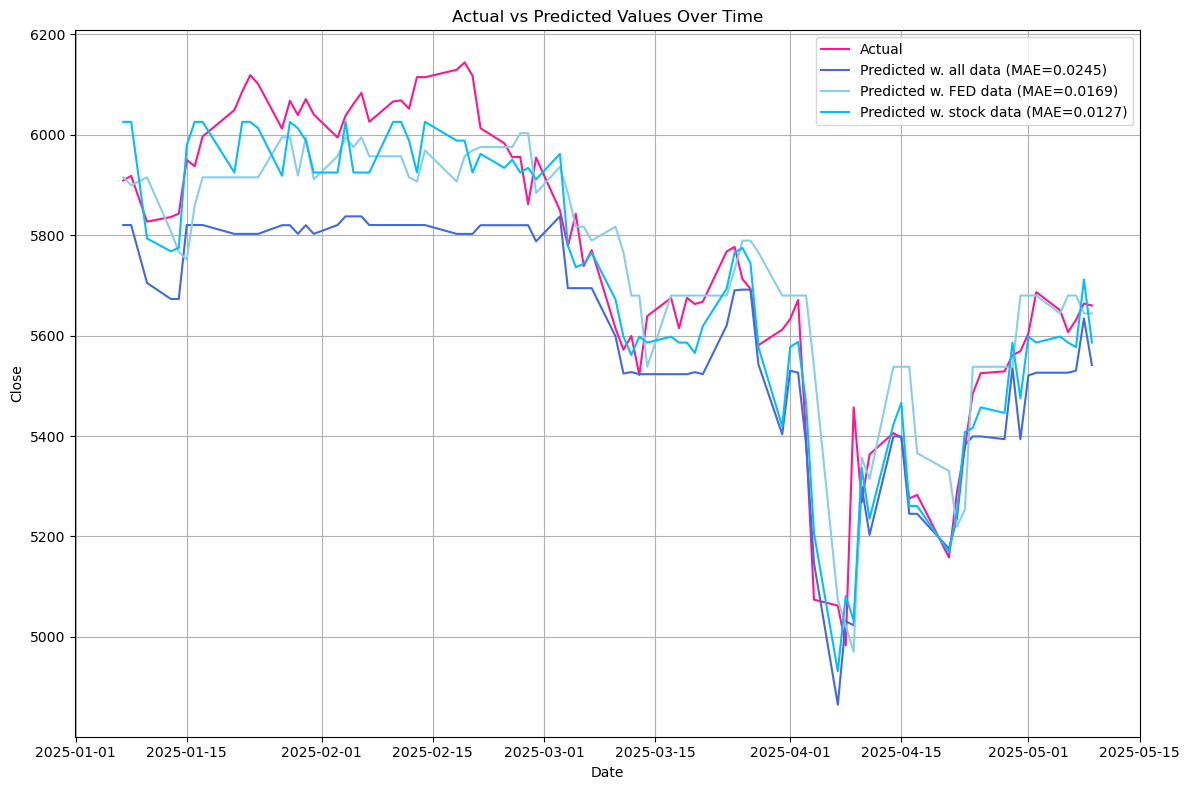

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(test_data['Date'], Y_test, label='Actual', color='deeppink')
plt.plot(test_data['Date'], y_pred, 
         label=f'Predicted w. all data (MAE={relative_mae:.4f})', 
         color='royalblue')
plt.plot(test_data['Date'], y_pred_ZCB, 
         label=f'Predicted w. FED data (MAE={relative_mae_wo_stock:.4f})', 
         color='skyblue')
plt.plot(test_data['Date'], y_pred_stock, 
         label=f'Predicted w. stock data (MAE={relative_mae_stock:.4f})', 
         color='deepskyblue')

plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid(True) 
plt.tight_layout()      
plt.show()



### Predicting with XGboost

#### Predicting with stock data

In [ ]:

split_date = pd.Timestamp('2025-01-01')

train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

split_date = pd.Timestamp('2025-01-01')

train_data = data_w_SP[data_w_SP['Date'] < split_date]
test_data = data_w_SP[data_w_SP['Date'] >= split_date]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]

start = time.time()

train_data_clean = train_data.dropna()
test_data_clean = test_data.dropna()

X_train = train_data_clean.drop(columns=[target, 'Date'])
Y_train = train_data_clean[target]

X_test = test_data_clean.drop(columns=[target, 'Date'])
Y_test = test_data_clean[target]

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred)
relative_mae = mae / abs(Y_test).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")



Mean Absolute Error: 73.5767
Relative MAE: 0.0128
Time used by XGBoost: 188.9 ms


#### Predicting without stock data

In [ ]:
split_date = pd.Timestamp('2025-01-01')

train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]

target = 'Close'

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

train_data_clean = train_data.dropna()
test_data_clean = test_data.dropna()

cols_to_drop = [target, 'Date', 'Open', 'High', 'Low', 'Volume']

X_train = train_data_clean.drop(columns=cols_to_drop)
Y_train = train_data_clean[target]

X_test = test_data_clean.drop(columns=cols_to_drop)
Y_test = test_data_clean[target]

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_ZCB = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred_ZCB)
relative_mae_wo_stock = mae / abs(Y_test).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae_wo_stock:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 502.8794
Relative MAE: 0.0875
Time used by XGBoost: 146.2 ms


#### Predicting only stock data

In [ ]:
split_date = pd.Timestamp('2025-01-01')

train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]

target = 'Close'

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

train_data_clean = train_data.dropna()
test_data_clean = test_data.dropna()

feature_cols = ['Open', 'High', 'Low', 'Volume']

X_train = train_data_clean[feature_cols]
Y_train = train_data_clean[target]

X_test = test_data_clean[feature_cols]
Y_test = test_data_clean[target]

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_stock = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred_stock)
relative_mae_stock = mae / abs(Y_test).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae_stock:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 72.7207
Relative MAE: 0.0126
Time used by XGBoost: 80.8 ms


NameError: name 'y_pred' is not defined

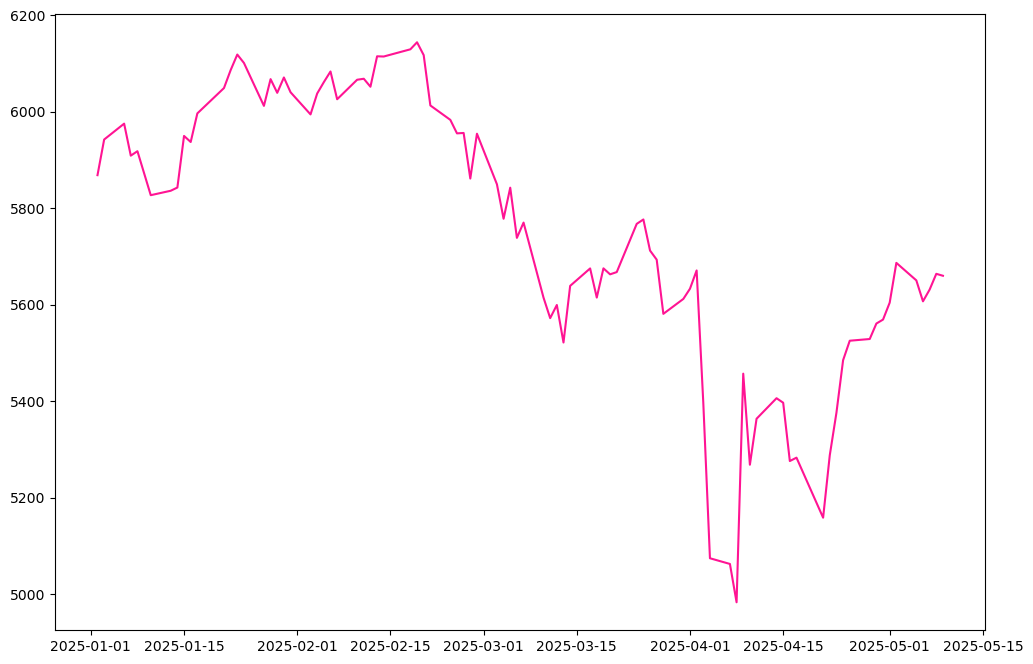

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(test_data_clean['Date'], Y_test, label='Actual', color='deeppink')
plt.plot(test_data_clean['Date'], y_pred, label=f'Predicted w. all data (MAE={relative_mae:.4f})', color='royalblue')
plt.plot(test_data_clean['Date'], y_pred_ZCB, label=f'Predicted w. FED data (MAE={relative_mae_wo_stock:.4f})', color='skyblue')
plt.plot(test_data_clean['Date'], y_pred_stock, label=f'Predicted w. stock data (MAE={relative_mae_stock:.4f})', color='deepskyblue')

plt.xlabel('Date')
plt.ylabel(target)
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


## Making XGboost models - 2024

### Predicting with XGboost with time series 2024

#### Predicting with all data

In [ ]:
split_date = pd.Timestamp('2024-01-01')

train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]


In [ ]:
def create_lags(df, target_col, lags=[1,2,3]):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df

train_data = create_lags(train_data, target)
test_data = create_lags(test_data, target)

train_data = train_data.dropna()
test_data = test_data.dropna()

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]
X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]


In [ ]:
def add_date_features(df):
    df = df.copy()
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['weekday'] = df['Date'].dt.weekday
    df['dayofyear'] = df['Date'].dt.dayofyear
    return df

train_data = add_date_features(train_data)
test_data = add_date_features(test_data)

X_train = train_data.drop(columns=[target, 'Date'])
X_test = test_data.drop(columns=[target, 'Date'])


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred)

mean_abs_actual = abs(Y_test).mean()
relative_mae = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 787.1679
Relative MAE: 0.1427
Time used by XGBoost: 133.1 ms


#### Feature importance

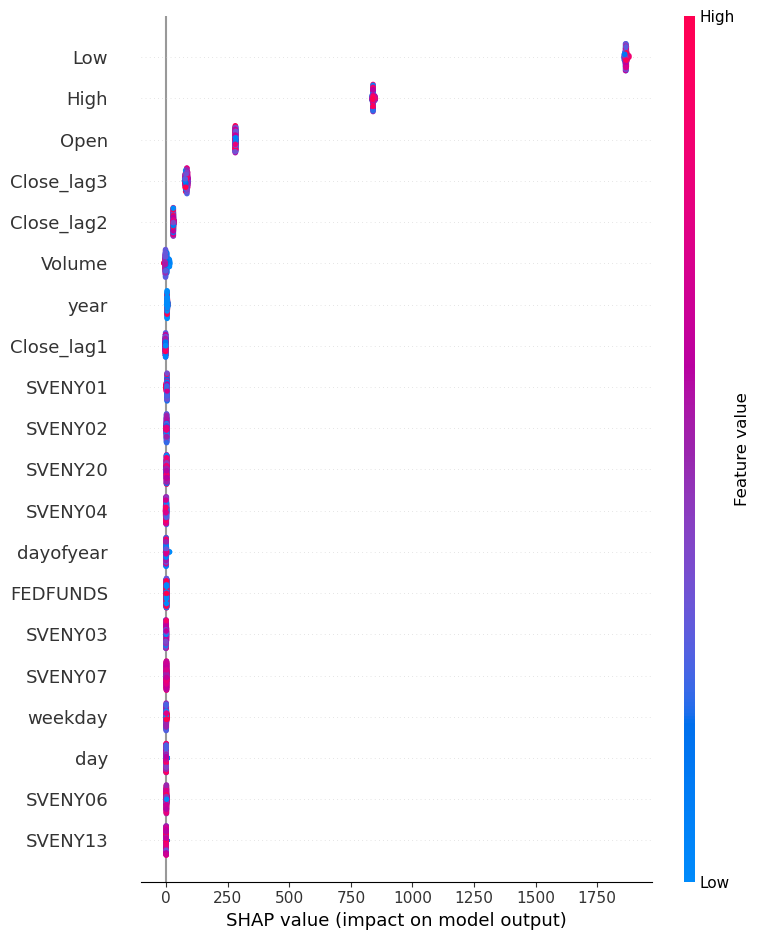

In [ ]:
import shap

explainer = shap.Explainer(xgb_model)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


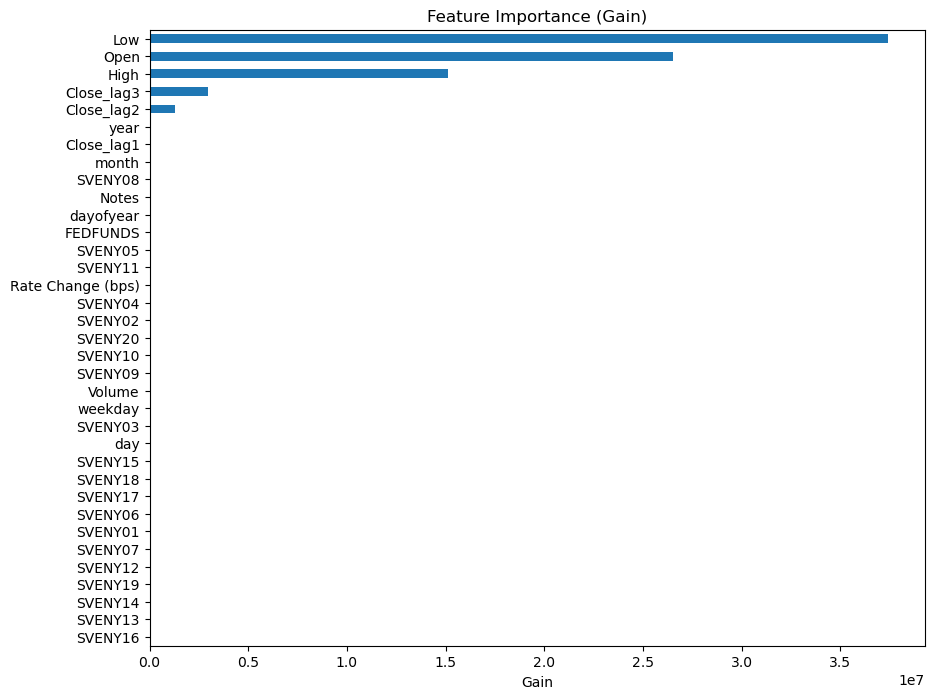

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

importance = xgb_model.get_score(importance_type='gain')

import pandas as pd
importance_series = pd.Series(importance).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importance_series.plot(kind='barh')
plt.xlabel('Gain')
plt.title('Feature Importance (Gain)')
plt.show()


#### Only predicting on ZCB data but with lags

In [ ]:
data_ZCB = df.drop(columns=['Open', 'High', 'Low', 'Volume'])

In [ ]:

split_date = pd.Timestamp('2024-01-01')

train_data = data_ZCB[data_ZCB['Date'] < split_date]
test_data = data_ZCB[data_ZCB['Date'] >= split_date]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]


In [ ]:
def create_lags(df, target_col, lags=[1,2,3]):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df

train_data = create_lags(train_data, target)
test_data = create_lags(test_data, target)

train_data = train_data.dropna()
test_data = test_data.dropna()

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]
X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_ZCB = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred_ZCB)

mean_abs_actual = abs(Y_test).mean()
relative_mae_wo_stock = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 783.6163
Relative MAE: 0.1427
Time used by XGBoost: 166.7 ms


#### Only predicting on stock data but with lags

In [ ]:
data_stock = df[['Date', 'Close', 'High', 'Low', 'Volume', 'Open']]

In [ ]:
split_date = pd.Timestamp('2024-01-01')

train_data = data_stock[data_stock['Date'] < split_date]
test_data = data_stock[data_stock['Date'] >= split_date]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]


In [ ]:
def create_lags(df, target_col, lags=[1,2,3]):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df

train_data = create_lags(train_data, target)
test_data = create_lags(test_data, target)

train_data = train_data.dropna()
test_data = test_data.dropna()

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]
X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_stock = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred_stock)

mean_abs_actual = abs(Y_test).mean()
relative_mae_stock = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 775.4225
Relative MAE: 0.1427
Time used by XGBoost: 135.9 ms


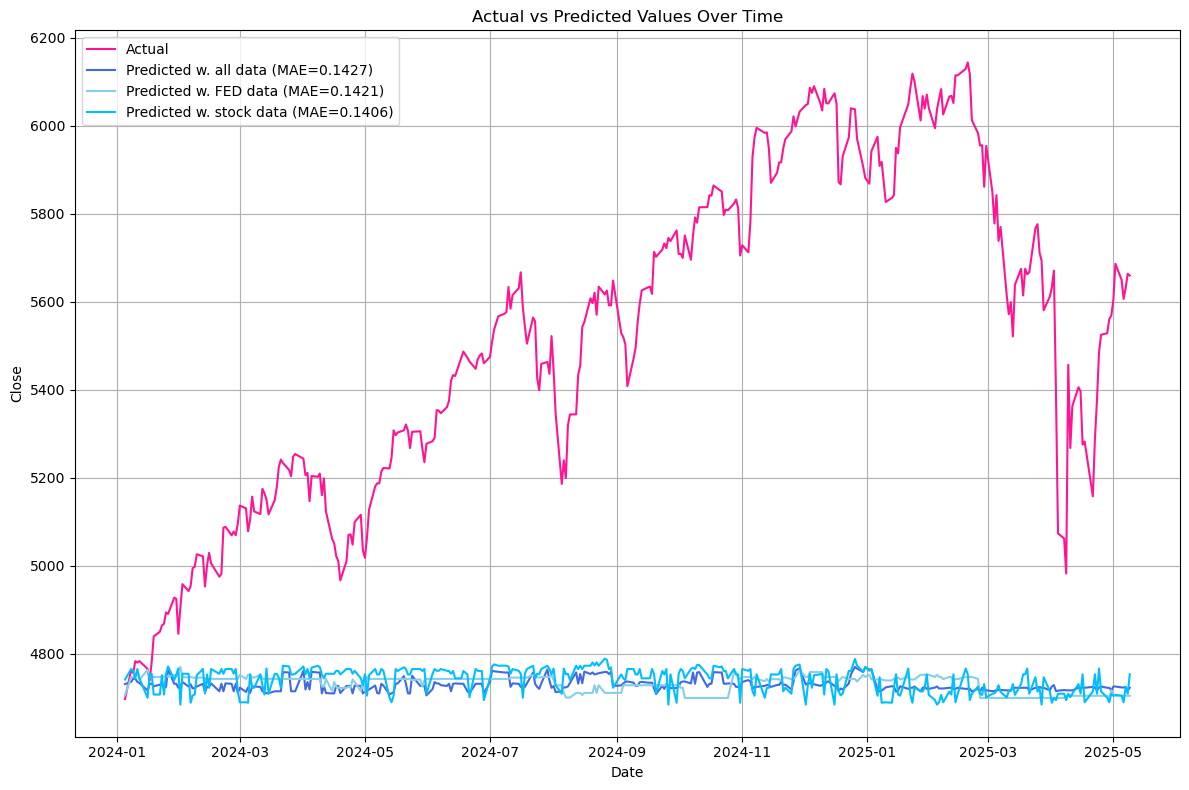

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(test_data['Date'], Y_test, label='Actual', color='deeppink')
plt.plot(test_data['Date'], y_pred, 
         label=f'Predicted w. all data (MAE={relative_mae:.4f})', 
         color='royalblue')
plt.plot(test_data['Date'], y_pred_ZCB, 
         label=f'Predicted w. FED data (MAE={relative_mae_wo_stock:.4f})', 
         color='skyblue')
plt.plot(test_data['Date'], y_pred_stock, 
         label=f'Predicted w. stock data (MAE={relative_mae_stock:.4f})', 
         color='deepskyblue')

plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close') 
plt.legend()
plt.grid(True)  
plt.tight_layout()     
plt.show()



### Predicting with XGboost for 2024

#### Predicting with stock data

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

split_start = pd.Timestamp('2024-01-01')
split_end = pd.Timestamp('2025-01-01')

train_data = data_w_SP[data_w_SP['Date'] < split_start]
test_data = data_w_SP[(data_w_SP['Date'] >= split_start) & (data_w_SP['Date'] < split_end)]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]

start = time.time()

train_data_clean = train_data.dropna()
test_data_clean = test_data.dropna()

X_train = train_data_clean.drop(columns=[target, 'Date'])
Y_train = train_data_clean[target]

X_test = test_data_clean.drop(columns=[target, 'Date'])
Y_test = test_data_clean[target]

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)


y_pred = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred)
relative_mae = mae / abs(Y_test).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")



Mean Absolute Error: 695.9177
Relative MAE: 0.1283
Time used by XGBoost: 154.0 ms


#### Predicting without stock data

In [ ]:
split_start = pd.Timestamp('2024-01-01')
split_end = pd.Timestamp('2025-01-01')

train_data = df[df['Date'] < split_start]
test_data = df[(df['Date'] >= split_start) & (df['Date'] < split_end)]

target = 'Close'


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

train_data_clean = train_data.dropna()
test_data_clean = test_data.dropna()

cols_to_drop = [target, 'Date', 'Open', 'High', 'Low', 'Volume']

X_train = train_data_clean.drop(columns=cols_to_drop)
Y_train = train_data_clean[target]

X_test = test_data_clean.drop(columns=cols_to_drop)
Y_test = test_data_clean[target]

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_ZCB = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred_ZCB)
relative_mae_wo_stock = mae / abs(Y_test).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae_wo_stock:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")




Mean Absolute Error: 1885.7352
Relative MAE: 0.3477
Time used by XGBoost: 123.2 ms


#### Predicting only stock data

In [ ]:
split_start = pd.Timestamp('2024-01-01')
split_end = pd.Timestamp('2025-01-01')

train_data = df[df['Date'] < split_start]
test_data = df[(df['Date'] >= split_start) & (df['Date'] < split_end)]

target = 'Close'


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

train_data_clean = train_data.dropna()
test_data_clean = test_data.dropna()

feature_cols = ['Open', 'High', 'Low', 'Volume']

X_train = train_data_clean[feature_cols]
Y_train = train_data_clean[target]

X_test = test_data_clean[feature_cols]
Y_test = test_data_clean[target]

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_stock = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred_stock)
relative_mae_stock = mae / abs(Y_test).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae_stock:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")




Mean Absolute Error: 678.7584
Relative MAE: 0.1251
Time used by XGBoost: 166.3 ms


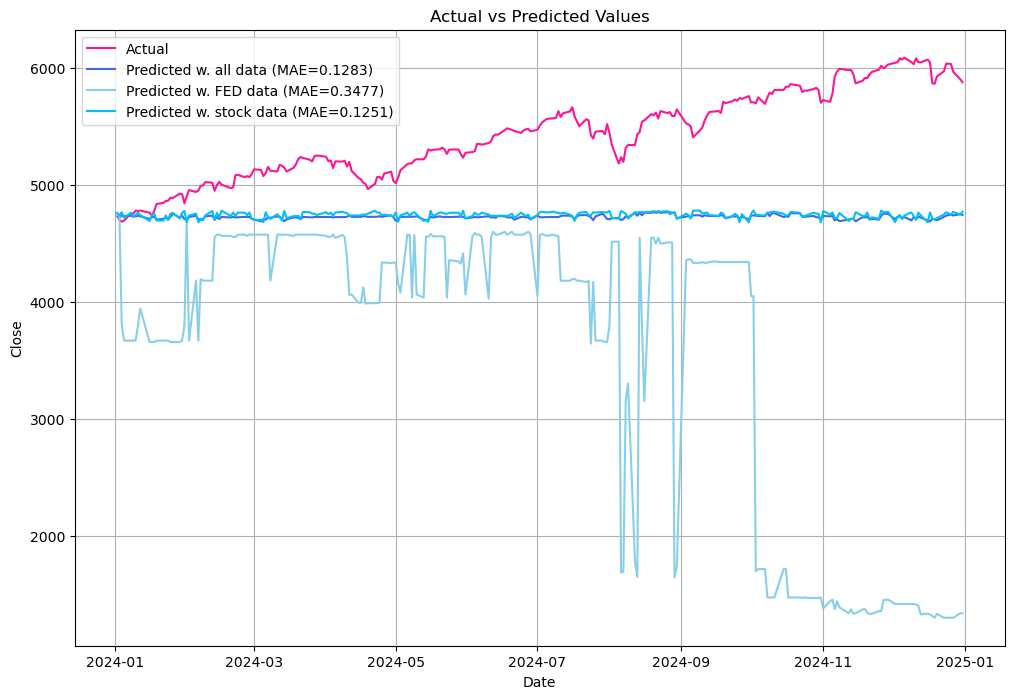

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(test_data_clean['Date'], Y_test, label='Actual', color='deeppink')
plt.plot(test_data_clean['Date'], y_pred, label=f'Predicted w. all data (MAE={relative_mae:.4f})', color='royalblue')
plt.plot(test_data_clean['Date'], y_pred_ZCB, label=f'Predicted w. FED data (MAE={relative_mae_wo_stock:.4f})', color='skyblue')
plt.plot(test_data_clean['Date'], y_pred_stock, label=f'Predicted w. stock data (MAE={relative_mae_stock:.4f})', color='deepskyblue')

plt.xlabel('Date')
plt.ylabel(target)
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


# Predicting interest rate

### BDT t-1

In [ ]:
split_date = pd.Timestamp('2025-01-01')

train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]

target = 'FEDFUNDS'

In [ ]:
train_data_day = train_data

# Create future-shifted target
train_data_day['target_t_plus_1'] = train_data_day[target].shift(-1)

In [ ]:
# Drop rows with NaNs introduced by shifting
train_data_day = train_data_day.dropna(subset=['target_t_plus_1'])

# Training/validation 80/20 split
test_split_date_week = pd.Timestamp('2018-01-01')

# Split into training and validation sets
train_df_day = train_data_day[train_data_day["Date"] < test_split_date]
val_df_day = train_data_day[train_data_day["Date"] >= test_split_date]

# Define features and target
feature_cols = [col for col in train_data_day.columns if col not in ["Date", target, 'target_t_plus_1']]
X_train_day = train_df_day[feature_cols]
y_train_day = train_df_day['target_t_plus_1']

X_val_day = val_df_day[feature_cols]
y_val_day = val_df_day['target_t_plus_1']


# Model input
# Create DMatrices for XGBoost
dtrain_day = xgb.DMatrix(X_train_day, label=y_train_day)
dvalid_day = xgb.DMatrix(X_val_day, label=y_val_day)

In [ ]:
# Drop rows with NaNs introduced by shifting
train_data_day = train_data_day.dropna(subset=['target_t_plus_1'])

# Training/validation 80/20 split
test_split_date_week = pd.Timestamp('2018-01-01')

# Split into training and validation sets
train_df_day = train_data_day[train_data_day["Date"] < test_split_date]
val_df_day = train_data_day[train_data_day["Date"] >= test_split_date]

# Define features and target
feature_cols = [col for col in train_data_day.columns if col not in ["Date", target, 'target_t_plus_1']]
X_train_day = train_df_day[feature_cols]
y_train_day = train_df_day['target_t_plus_1']

X_val_day = val_df_day[feature_cols]
y_val_day = val_df_day['target_t_plus_1']


# Model input
# Create DMatrices for XGBoost
dtrain_day = xgb.DMatrix(X_train_day, label=y_train_day)
dvalid_day = xgb.DMatrix(X_val_day, label=y_val_day)

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

# Start timer
start = time.time()

# XGBoost parameters
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain_day, 'train'), (dvalid_day, 'eval')]

# Train model with early stopping
xgb_model_day = xgb.train(
    params=params,
    dtrain=dtrain_day,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

# Predict and evaluate
y_pred_rate_day = xgb_model_day.predict(dvalid_day, iteration_range=(0, xgb_model_day.best_iteration + 1))
mae_day = mean_absolute_error(y_val_day, y_pred_rate_day)
relative_mae_day = mae_day / abs(y_val_day).mean()

print(f"Mean Absolute Error: {mae_day:.4f}")
print(f"Relative MAE: {relative_mae_day:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")
import matplotlib.pyplot as plt

# Assuming you still have test_data_clean (with dropped NAs) and predictions y_pred
# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(val_df['Date'], y_val, label='Actual', color = 'goldenrod') #, marker='o'
plt.plot(val_df['Date'], y_pred_rate, label='Predicted t-1', color = 'lightblue') # , marker='x'
#plt.plot(test_data_clean['Date'], y_pred_ZCB, label='Predicted w. ZCB data', marker='x')
#plt.plot(test_data_clean['Date'], y_pred_stock, label='Predicted w. stock data', marker='x')
plt.xlabel('Date')
plt.ylabel('Interest rate (%)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# VAE

## Betas

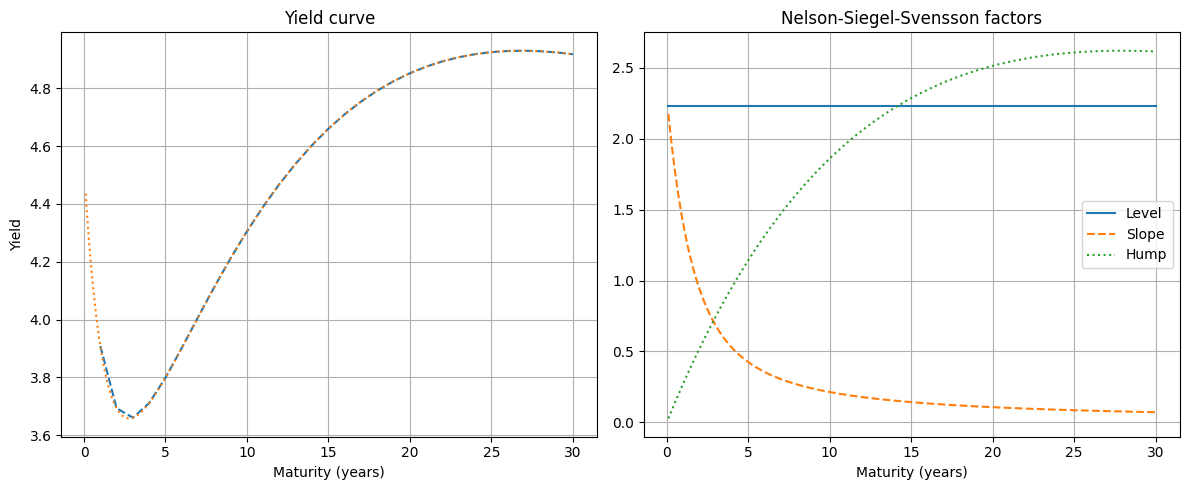

In [29]:
import numpy as np
import matplotlib.pyplot as plt


row = data1.loc[16666]

maturities = np.arange(1, 31)


yields = row[sveny_cols].values 

beta0 = row['BETA0']
beta1 = row['BETA1']
beta2 = row['BETA2']
beta3 = row['BETA3']
tau1 = row['TAU1']
tau2 = row['TAU2']

def nss_decompose(tau):
    term1 = (1 - np.exp(-tau / tau1)) / (tau / tau1)
    term2 = term1 - np.exp(-tau / tau1)
    term3 = (1 - np.exp(-tau / tau2)) / (tau / tau2) - np.exp(-tau / tau2)
    level = beta0 * np.ones_like(tau)
    slope = beta1 * term1
    hump = beta2 * term2 + beta3 * term3
    return level, slope, hump

tau = np.linspace(0.1, 30, 300)
level, slope, hump = nss_decompose(tau)
nss_curve = level + slope + hump


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(maturities, yields, linestyle='--')
plt.plot(tau, nss_curve, label='NSS fit', linestyle=':')
plt.title('Yield curve')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(tau, level, label='Level', linestyle='-')
plt.plot(tau, slope, label='Slope', linestyle='--')
plt.plot(tau, hump, label='Hump', linestyle=':')
plt.title('Nelson-Siegel-Svensson factors')
plt.xlabel('Maturity (years)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## PCA constructing Betas

### How many components

In [19]:
data_pca = data2.drop(columns=['BETA0', 'BETA1', 'BETA2', 'BETA3'], errors='ignore')

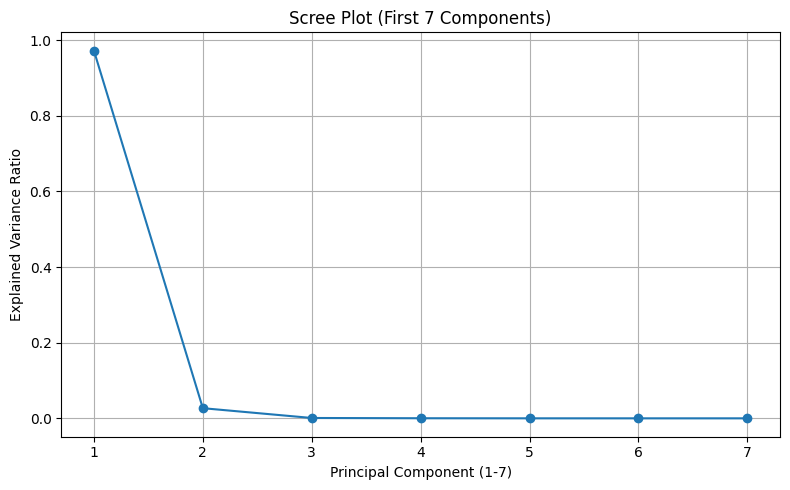

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


X = data_pca.select_dtypes(include=[np.number]).dropna()

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=7)
pca.fit(X_scaled)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, 8), explained_variance, marker='o', linestyle='-')
plt.xlabel('Principal Component (1-7)')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (First 7 Components)')
plt.grid(True)
plt.tight_layout()
plt.show()



### PCA with 3 components

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = data_pca.select_dtypes(include='number').dropna()

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Shape of PCA output:", X_pca.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)


Shape of PCA output: (10073, 3)
Explained variance ratio: [9.71920142e-01 2.68402073e-02 9.48003073e-04]


In [ ]:

print("PCA Components (loadings):")
print(pca.components_)


PCA Components (loadings):
[[ 0.20781566  0.21520252  0.21987041  0.22287819  0.22477554  0.22589578
   0.22647056  0.22667124  0.22662611  0.22642988  0.22615046  0.22583459
   0.22551269  0.22520293  0.22491455  0.22465046  0.22440924  0.22418668
   0.22397691  0.22377313]
 [ 0.53457947  0.42962807  0.333493    0.24833791  0.17359171  0.10853609
   0.0524047   0.00436546 -0.0364496  -0.07090949 -0.09984518 -0.12402723
  -0.14415052 -0.16083108 -0.17460565 -0.18593744 -0.19522326 -0.20279966
  -0.20895121 -0.21391796]
 [ 0.58122441  0.16220575 -0.08340882 -0.21934016 -0.28284171 -0.29778643
  -0.28070279 -0.24339655 -0.1943536  -0.13962499 -0.0834631  -0.02879025
   0.02244109  0.06900294  0.11017061  0.14559121  0.17516399  0.19897046
   0.21720987  0.23015998]]


In [23]:
X_scaled_approx = pca.inverse_transform(X_pca)

X_original_approx = StandardScaler().fit(X).inverse_transform(X_scaled_approx)


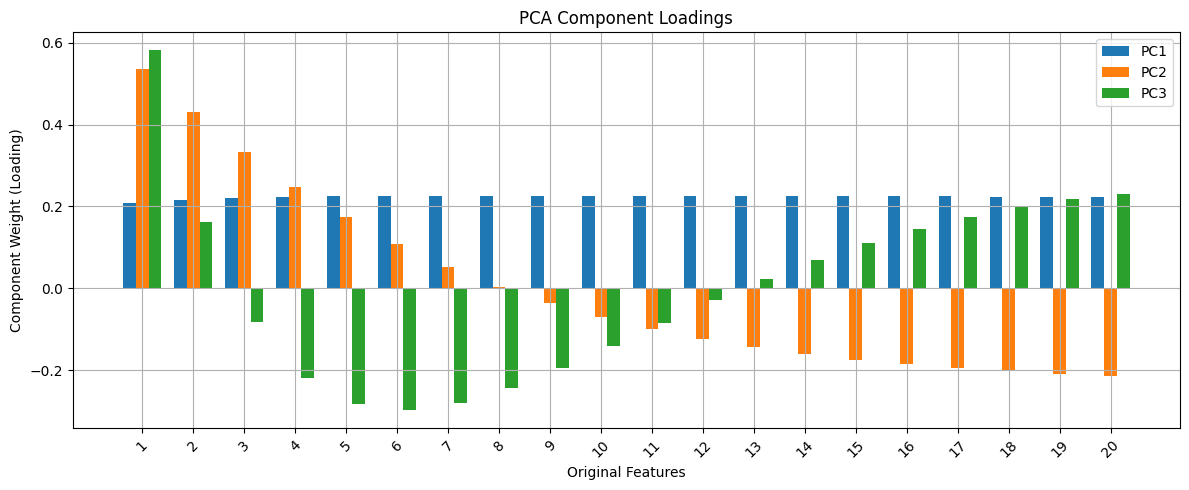

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

feature_names = data_pca.select_dtypes(include='number').columns

components_df = pd.DataFrame(pca.components_, columns=feature_names, index=['PC1', 'PC2', 'PC3'])

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.bar(np.arange(len(feature_names)) + i*0.25, components_df.iloc[i], width=0.25, label=f'PC{i+1}')

plt.xticks(np.arange(len(feature_names)) + 0.25, feature_names, rotation=45)
plt.xlabel('Original Features')
plt.ylabel('Component Weight (Loading)')
plt.title('PCA Component Loadings')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


## Defining the VAE

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data3 = data2[data2["Date"] >= "1991-01-01"].copy()
data_clean = data3.dropna().drop(columns=["Date"]).copy()
data_features = data_clean.drop(columns=['BETA0', 'BETA1', 'BETA2'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_features)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], latent_dim=2):
        super().__init__()
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.BatchNorm1d(h_dim))
            encoder_layers.append(nn.LeakyReLU())
            prev_dim = h_dim
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mean = nn.Linear(prev_dim, latent_dim)
        self.fc_logvar = nn.Linear(prev_dim, latent_dim)

        decoder_layers = []
        hidden_dims_rev = list(reversed(hidden_dims))
        prev_dim = latent_dim
        for h_dim in hidden_dims_rev:
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.BatchNorm1d(h_dim))
            decoder_layers.append(nn.LeakyReLU())
            prev_dim = h_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mean(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


def loss_fn(x, x_hat, mu, logvar, beta=0.1):
    recon = nn.functional.mse_loss(x_hat, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return recon + beta * kl


epochs = 100
batch_size = 32
input_dim = X_tensor.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tscv = TimeSeriesSplit(n_splits=5)
val_losses_per_epoch = []
train_losses_per_epoch = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_tensor)):
    print(f"Fold {fold+1}")

    X_train = X_tensor[train_idx]
    X_val = X_tensor[val_idx]

    train_loader = DataLoader(TensorDataset(X_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val), batch_size=batch_size)

    model = VAE(input_dim=input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    fold_train_losses = []
    fold_val_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            x_hat, mu, logvar = model(x)
            loss = loss_fn(x, x_hat, mu, logvar)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        fold_train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device)
                x_hat, mu, logvar = model(x)
                val_loss = loss_fn(x, x_hat, mu, logvar)
                total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        fold_val_losses.append(avg_val_loss)

    train_losses_per_epoch.append(fold_train_losses)
    val_losses_per_epoch.append(fold_val_losses)


val_losses_per_epoch = np.array(val_losses_per_epoch)
mean_val_loss = val_losses_per_epoch.mean(axis=0)
best_epoch = np.argmin(mean_val_loss)

print(f"\n📉 Best epoch: {best_epoch}")
print(f"📊 Mean validation loss first 20 epochs:\n{mean_val_loss[:20]}")


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

📉 Best epoch: 75
📊 Mean validation loss first 20 epochs:
[222.92167653 124.46444936 113.04994059  90.58807678  77.17075839
  70.87658815  64.26101762  58.33090933  51.42968878  59.36873995
  46.64953835  56.71459277  44.3621521   50.44065883  42.54343426
  46.95652008  43.62827035  45.84372749  44.8066456   39.9906877 ]


In [ ]:
start_train_loss = train_losses_per_epoch[0][0]
end_train_loss = train_losses_per_epoch[0][-1]

start_val_loss = val_losses_per_epoch[0][0]
end_val_loss = val_losses_per_epoch[0][-1]

print(f"Train loss start: {start_train_loss:.3f}, end: {end_train_loss:.3f}")
print(f"Val loss start: {start_val_loss:.3f}, end: {end_val_loss:.3f}")

best_val_loss = mean_val_loss[best_epoch]
print(f"Best validation loss at epoch {best_epoch}: {best_val_loss:.3f}")


Train loss start: 653.768, end: 18.002
Val loss start: 158.547, end: 35.552
Best validation loss at epoch 75: 34.944


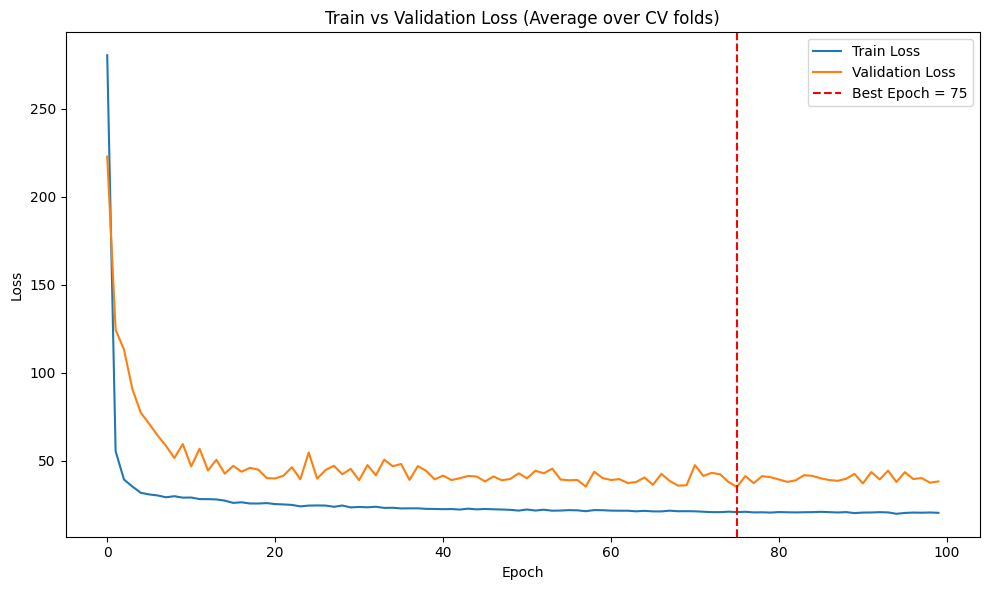

In [ ]:
train_losses_per_epoch = np.array(train_losses_per_epoch)
val_losses_per_epoch = np.array(val_losses_per_epoch)

mean_train_loss = train_losses_per_epoch.mean(axis=0)
mean_val_loss = val_losses_per_epoch.mean(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(mean_train_loss, label="Train Loss")
plt.plot(mean_val_loss, label="Validation Loss")
plt.axvline(best_epoch, color='red', linestyle='--', label=f"Best Epoch = {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (Average over CV folds)")
plt.legend()
plt.tight_layout()
plt.show()


## Comparison - reconstructed vs actual

In [ ]:
final_loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)

model = VAE(input_dim=input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(best_epoch):
    model.train()
    for batch in final_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = loss_fn(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()


model.eval()
with torch.no_grad():
    X_recon, _, _ = model(X_tensor.to(device))


rec_err = ((X_tensor - X_recon.cpu())**2).mean(dim=1).numpy()


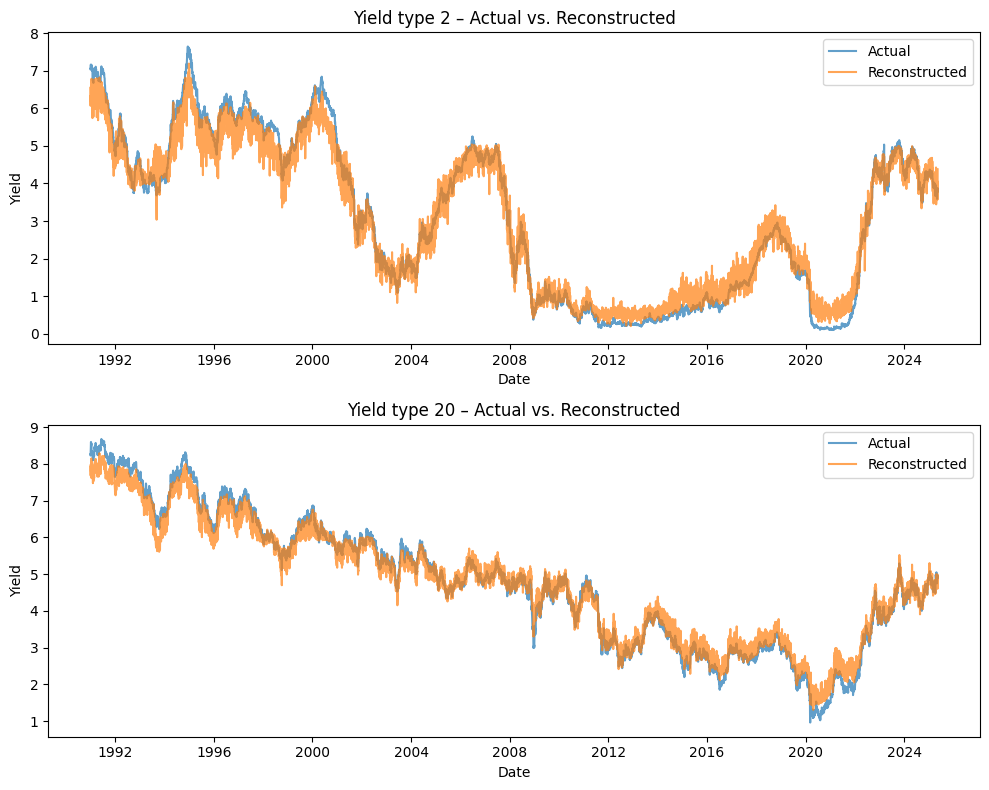

In [ ]:
data_clean = data3.dropna().copy()
dates = data_clean["Date"].reset_index(drop=True)


data_features = data_clean.drop(columns=["Date", 'BETA0', 'BETA1', 'BETA2']) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_features)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


X_reconstructed_original = scaler.inverse_transform(X_recon.cpu().numpy())
reconstructed_df = pd.DataFrame(X_reconstructed_original, columns=data_features.columns)
original_df = pd.DataFrame(scaler.inverse_transform(X_tensor.numpy()), columns=data_features.columns)


original_df["Date"] = dates
reconstructed_df["Date"] = dates


col_idx_1 = 1 
col_idx_2 = 19
col_name_1 = data_features.columns[col_idx_1]
col_name_2 = data_features.columns[col_idx_2]


plt.figure(figsize=(10, 8)) 

plt.subplot(2, 1, 1)
plt.plot(original_df["Date"], original_df[col_name_1], label="Actual", alpha=0.7)
plt.plot(reconstructed_df["Date"], reconstructed_df[col_name_1], label="Reconstructed", alpha=0.7)
plt.title(f"Yield type {col_name_1} – Actual vs. Reconstructed")
plt.xlabel("Date")
plt.ylabel("Yield")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(original_df["Date"], original_df[col_name_2], label="Actual", alpha=0.7)
plt.plot(reconstructed_df["Date"], reconstructed_df[col_name_2], label="Reconstructed", alpha=0.7)
plt.title(f"Yield type {col_name_2} – Actual vs. Reconstructed")
plt.xlabel("Date")
plt.ylabel("Yield")
plt.legend()

plt.tight_layout()
plt.show()



## Anomalies

In [ ]:

fed_df = pd.read_csv("FED_interest.csv", parse_dates=["Date"])

fed_df["Rate Change (bps)"] = pd.to_numeric(fed_df["Rate Change (bps)"], errors="coerce")

fed_change_dates = fed_df.loc[fed_df["Rate Change (bps)"] != 0, "Date"]


def overlap_score(result_df, fed_dates, window_days=3):
    anomaly_dates = result_df[result_df["anomaly"]]["Date"]
    score = 0
    for fed_date in fed_dates:
        window_start = fed_date - pd.Timedelta(days=window_days)
        window_end = fed_date + pd.Timedelta(days=window_days)
        if any((anomaly_dates >= window_start) & (anomaly_dates <= window_end)):
            score += 1
    return score



🎯 Overlap score: 6


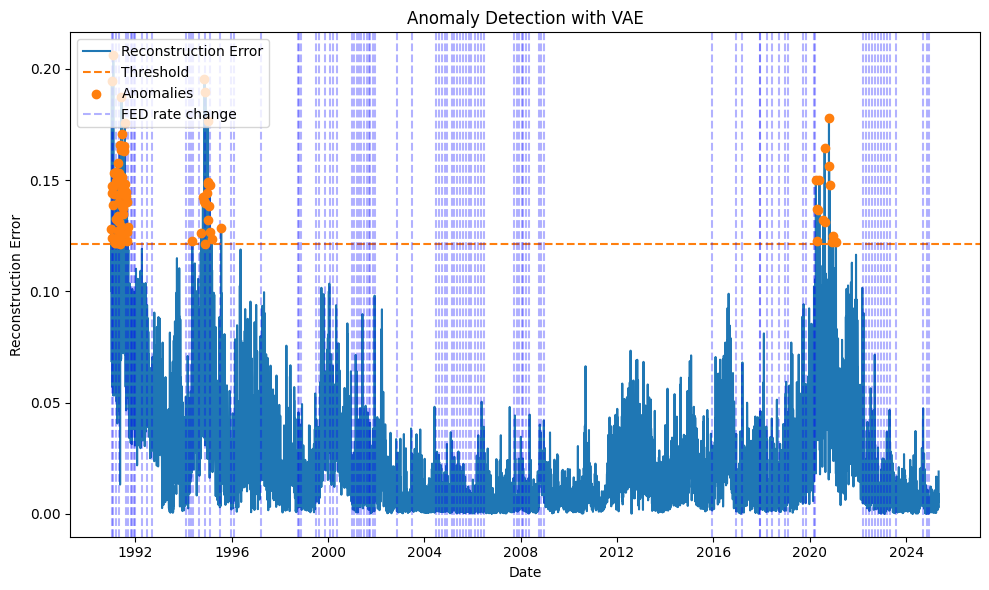

In [ ]:
threshold = np.percentile(rec_err, 99)
anomalies = rec_err > threshold


result_df = pd.DataFrame({
    "Date": data2.loc[data3.dropna().index, "Date"].reset_index(drop=True),
    "reconstruction_error": rec_err,
    "anomaly": anomalies
})



score = overlap_score(result_df, fed_change_dates, window_days=3)
print(f"\n🎯 Overlap score: {score}")

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
orange_color = default_colors[1] 

plt.figure(figsize=(10,6))
plt.plot(result_df["Date"], result_df["reconstruction_error"], label="Reconstruction Error")
plt.axhline(threshold, color=orange_color, linestyle='--', label="Threshold")
plt.scatter(result_df[result_df["anomaly"]]["Date"],
            result_df[result_df["anomaly"]]["reconstruction_error"],
            color=orange_color, label="Anomalies", zorder=5)

first_line = True
for date in fed_change_dates:
    if date >= result_df["Date"].min():
        if first_line:
            plt.axvline(date, color='blue', linestyle='--', alpha=0.3, label="FED rate change")
            first_line = False
        else:
            plt.axvline(date, color='blue', linestyle='--', alpha=0.3)

plt.legend(loc="upper left")
plt.title("Anomaly Detection with VAE")
plt.xlabel("Date")
plt.ylabel("Reconstruction Error")
plt.tight_layout()
plt.show()



In [ ]:
print(fed_df.shape)
print(data3.shape)

(12566, 5)
(8964, 24)


In [ ]:
anomaly_dates = result_df[result_df["anomaly"]]["Date"]
print(anomaly_dates)

anomaly_dates.shape

1      1991-01-03
4      1991-01-08
5      1991-01-09
9      1991-01-15
10     1991-01-16
          ...    
7437   2020-10-21
7441   2020-10-27
7465   2020-12-02
7478   2020-12-21
7506   2021-02-02
Name: Date, Length: 86, dtype: datetime64[ns]


(86,)

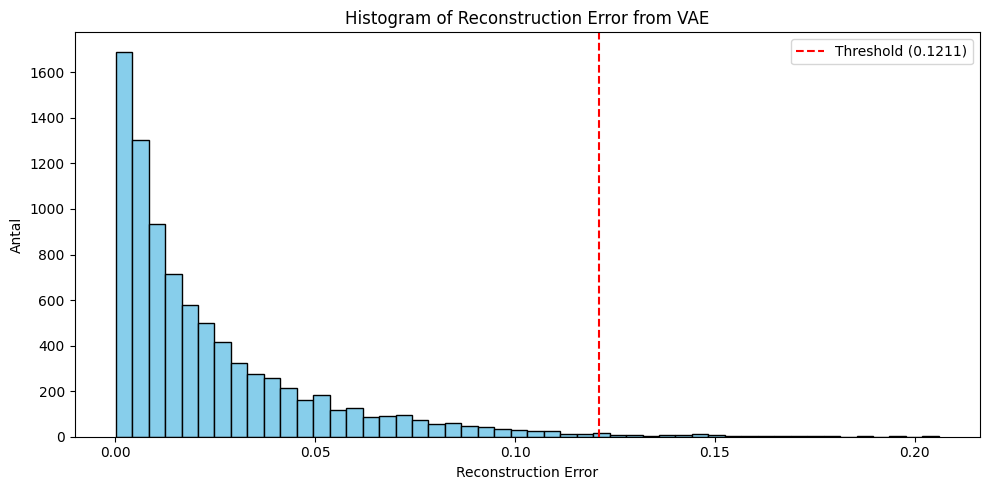

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(result_df["reconstruction_error"], bins=50, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title("Histogram of Reconstruction Error from VAE")
plt.xlabel("Reconstruction Error")
plt.ylabel("Antal")
plt.legend()
plt.tight_layout()
plt.show()


## Choosing epochs based on validation error on validation set (01-01-2018 - 01-01-2025)

Epoch 1/50 — Train Loss: 136.4051 — Val Loss: 60.0952
Epoch 2/50 — Train Loss: 47.1569 — Val Loss: 45.3708
Epoch 3/50 — Train Loss: 41.8670 — Val Loss: 49.7382
Epoch 4/50 — Train Loss: 42.3920 — Val Loss: 45.0705
Epoch 5/50 — Train Loss: 42.1663 — Val Loss: 28.8117
Epoch 6/50 — Train Loss: 41.8227 — Val Loss: 38.7920
Epoch 7/50 — Train Loss: 41.3326 — Val Loss: 43.0870
Epoch 8/50 — Train Loss: 40.0478 — Val Loss: 32.9719
Epoch 9/50 — Train Loss: 39.0390 — Val Loss: 30.3656
Epoch 10/50 — Train Loss: 39.2296 — Val Loss: 38.3681
Epoch 11/50 — Train Loss: 38.0192 — Val Loss: 31.2581
Epoch 12/50 — Train Loss: 37.9577 — Val Loss: 33.8001
Epoch 13/50 — Train Loss: 37.1147 — Val Loss: 37.3156
Epoch 14/50 — Train Loss: 35.6974 — Val Loss: 31.4605
Epoch 15/50 — Train Loss: 35.4889 — Val Loss: 29.1983
Early stopping triggered after 15 epochs


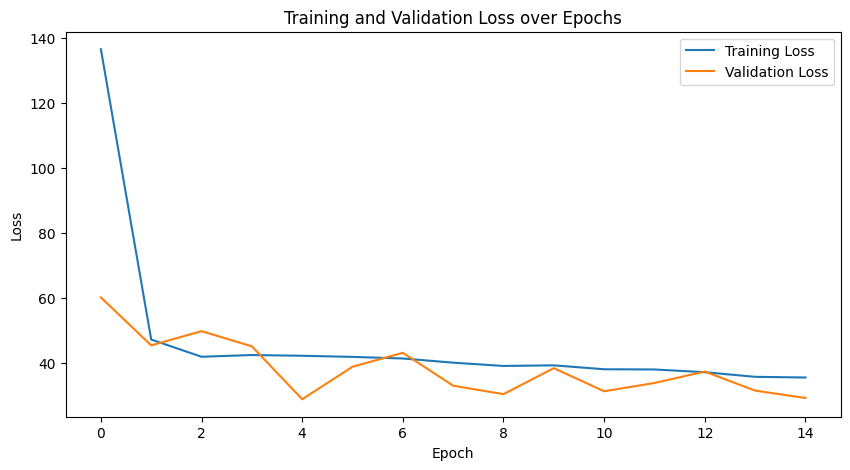

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


latent_dim = 2
beta = 0.1
hidden_dims = [64, 32]
batch_size = 32
epochs = 50
patience = 10 
learning_rate = 1e-4


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], latent_dim=2):
        super().__init__()
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h_dim))
            encoder_layers.append(nn.BatchNorm1d(h_dim))
            encoder_layers.append(nn.LeakyReLU())
            prev_dim = h_dim
        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mean = nn.Linear(prev_dim, latent_dim)
        self.fc_logvar = nn.Linear(prev_dim, latent_dim)
        decoder_layers = []
        hidden_dims_rev = list(reversed(hidden_dims))
        prev_dim = latent_dim
        for h_dim in hidden_dims_rev:
            decoder_layers.append(nn.Linear(prev_dim, h_dim))
            decoder_layers.append(nn.BatchNorm1d(h_dim))
            decoder_layers.append(nn.LeakyReLU())
            prev_dim = h_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mean(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


def loss_fn(x, x_hat, mu, logvar, beta=1):
    recon = nn.functional.mse_loss(x_hat, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return recon + beta * kl


dates = data3.loc[data3.dropna().index, "Date"].reset_index(drop=True)


split_date = pd.to_datetime("2018-01-01")

train_idx = dates < split_date
val_idx = dates >= split_date

X_train = X_tensor[train_idx.values]
X_val = X_tensor[val_idx.values]

train_dataset = TensorDataset(X_train)
val_dataset = TensorDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


model = VAE(input_dim=X_tensor.shape[1], hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

input_dim = X_tensor.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(input_dim=input_dim, hidden_dims=[64, 32], latent_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Lavere lr



best_val_loss = np.inf
epochs_no_improve = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = loss_fn(x, x_hat, mu, logvar, beta=0.1)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x_val = batch[0].to(device)
            x_hat_val, mu_val, logvar_val = model(x_val)
            val_loss = loss_fn(x_val, x_hat_val, mu_val, logvar_val, beta=0.1)
            total_val_loss += val_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs} — Train Loss: {avg_train_loss:.4f} — Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_vae_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

model.load_state_dict(torch.load("best_vae_model.pth"))

model.eval()
with torch.no_grad():
    X_recon, _, _ = model(X_tensor.to(device))
    rec_err = torch.mean((X_tensor.to(device) - X_recon) ** 2, dim=1).cpu().numpy()


plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()


🎯 Overlap score: 6 (beta=0.1, latent_dim=2)


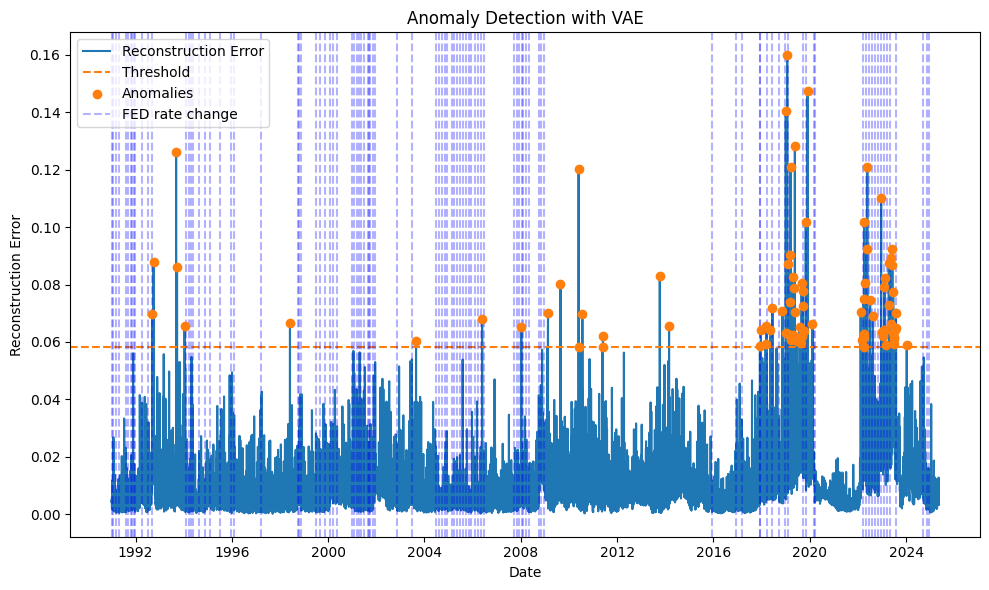

In [ ]:
threshold = np.percentile(rec_err, 99)
anomalies = rec_err > threshold


result_df = pd.DataFrame({
    "Date": data2.loc[data3.dropna().index, "Date"].reset_index(drop=True),
    "reconstruction_error": rec_err,
    "anomaly": anomalies
})


score = overlap_score(result_df, fed_change_dates, window_days=3)
print(f"\n🎯 Overlap score: {score} (beta={beta}, latent_dim={latent_dim})")

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
orange_color = default_colors[1] 

plt.figure(figsize=(10,6))
plt.plot(result_df["Date"], result_df["reconstruction_error"], label="Reconstruction Error")
plt.axhline(threshold, color=orange_color, linestyle='--', label="Threshold")
plt.scatter(result_df[result_df["anomaly"]]["Date"],
            result_df[result_df["anomaly"]]["reconstruction_error"],
            color=orange_color, label="Anomalies", zorder=5)

first_line = True
for date in fed_change_dates:
    if date >= result_df["Date"].min():
        if first_line:
            plt.axvline(date, color='blue', linestyle='--', alpha=0.3, label="FED rate change")
            first_line = False
        else:
            plt.axvline(date, color='blue', linestyle='--', alpha=0.3)

plt.legend(loc="upper left")
plt.title("Anomaly Detection with VAE")
plt.xlabel("Date")
plt.ylabel("Reconstruction Error")
plt.tight_layout()
plt.show()



clearly generalizes best on the validation set (2018-2024) hence not good for finding anomalies in the whole timeframe